Вводные:
- данные за 2021 год были внесены в файл по расчету 2022 года, т.к. различаются подходы: в 21 году выполнение/невыполнение определяется по коэффициенту (<>1), в 22 в зависимости от различия факта и цели (<>); показатель бальная оценка округляется по-разному (в 22 до 2х знаков, в 21 до 3х знаков);
- исправлена ошибка в расчете коэффициента выполнения по показателю погрузка (не было округления);
- округление сохранено;
- неправильно округляются цифры 0.077500 и 0.107500 непонятно почему.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import norm
import warnings

import decimal #для округления

Функция округления.

In [3]:
def round_dec(x, y):
    D=decimal.Decimal
    return float(D(str(x)).quantize(D(y), decimal.ROUND_HALF_UP))

Загрузим датасет.

In [4]:
df=pd.read_excel(r'/Users/mihailvardanasvili/Downloads/final_df.xlsx', sheet_name="all", header=[0,1])

In [5]:
pd.set_option('display.max_columns',None)
warnings.filterwarnings("ignore")

Изменим тип данных в столбце период.

In [6]:
# df[('Период',' ')]=df[('Период',' ')].astype('str')

Переименуем столбцы.

In [7]:
df1=df.rename(columns={' ':''})

In [8]:
df1 = df1.replace({('Дорога',''):{"ОКТ":"10ОКТ","КЛГ":"11КЛГ","МСК":"12МСК","ГОР":"13ГОР","СЕВ":"14СЕВ","СКВ":"15СКВ","ЮВС":"16ЮВС","ПРВ":"17ПРВ","КБШ":"18КБШ","СВР":"19СВР","ЮУР":"20ЮУР","ЗСБ":"21ЗСБ","КРС":"22КРС","ВСБ":"23ВСБ","ЗАБ":"24ЗАБ","ДВС":"25ДВС"}})

Составим список параметров.

In [9]:
k=list(set([k[0] for k in df1.columns[4:]]))

In [10]:
print(len(k))
k

15


['Уч. скорость',
 'КЗ',
 'Пр.ЭП',
 'ПФБ',
 'УШ',
 'Фин. рез. ПВД',
 'Погрузка грузов',
 'ДЗ',
 'Вып.расп.приг.',
 'Доля',
 'Выручка',
 'Уд. время задержки',
 'Себестоимость',
 'Кач. балл. оц.',
 'Вып.расп.пасс.']

Параметры инверсии и весов показателей.

In [29]:
type_metr = {'Вып.расп.пасс.': 1,
 'Доля': 1,
 'Вып.расп.приг.': 1,
 'КЗ': 1, #отдельное условие в приложении
 'ДЗ': -1,
 'Выручка': 1,
 'Себестоимость': -1,
 'Кач. балл. оц.': 1,
 'Уч. скорость': 1,
 'Пр.ЭП': 1,
 'Погрузка грузов': 1,
 'Фин. рез. ПВД': 1,
 'Уд. время задержки': -1,
 'УШ': 1,
 'ПФБ': - 1}
weight_metr = {'Вып.расп.пасс.': .05,
 'Доля': .05,
 'Вып.расп.приг.': .05,
 'КЗ': .025,
 'ДЗ': .025,
 'Выручка': .1,
 'Себестоимость': .1,
 'Кач. балл. оц.': .05,
 'Уч. скорость': .025,
 'Пр.ЭП': .05,
 'Погрузка грузов': .1,
 'Фин. рез. ПВД': .05,
 'Уд. время задержки': .05,
 'УШ': .025,
 'ПФБ': .25,
 'gruppk1': .75             }

Возможность органичить анализируемые признаки.

In [30]:
k1=[i for i in k if i not in ['КЗ','УШ','Себестоимость','Погрузка грузов']]

In [31]:
k2=[i for i in k if i not in k1]

In [32]:
k1

['Уч. скорость',
 'Пр.ЭП',
 'ПФБ',
 'Фин. рез. ПВД',
 'ДЗ',
 'Вып.расп.приг.',
 'Доля',
 'Выручка',
 'Уд. время задержки',
 'Кач. балл. оц.',
 'Вып.расп.пасс.']

Добавим столбцы с датой/месяцем, добавим кварталы.

In [33]:
df1['Год'] = df1['Месяц/Год'].astype('datetime64').dt.year
df1['Месяц'] = df1['Месяц/Год'].astype('datetime64').dt.month
def kvart(month):
    kv={1:1,2:1,3:1,4:2,5:2,6:2,7:3,8:3,9:3,10:4,11:4,12:4}
    return kv[month]

df1['Квартал'] = (df1['Год'] - df1['Год'].min())*4 + df1['Месяц'].apply(kvart)
df1 = df1.sort_index(axis=1)

Пересохраним неокругленные факт и цель для дальнейшего округления.

In [34]:
for p in k:
    if p == 'Погрузка грузов':
        for i in ['Факт','Цель','Цель (скорр. план)']:
            df1.loc[:,(p, i+'_ok')] = df1.loc[:,(p, i)]
    else:
        for i in ['Факт','Цель']:
            df1.loc[:,(p, i+'_ok')] = df1.loc[:,(p, i)]

Округлим факт и цель.

In [35]:
rnd='.001'
for p in k:
    # отдельно, т.к. две цели
    if p == 'Погрузка грузов':
        for i in ['Факт_ok','Цель_ok','Цель (скорр. план)_ok']:
            df1[(p,i)] = df1[(p,i)].apply(lambda x: round_dec(x, rnd))
    # отдельно, т.к. иначе округляется
    elif p == 'Уч. скорость':
        for i in ['Факт_ok','Цель_ok']:
            df1[(p,i)] = df1[(p,i)].apply(lambda x: round_dec(x, '0.1'))
    # отдельно, т.к. иначе округляется
    elif p == 'Пр.ЭП':
        for i in ['Факт_ok','Цель_ok']:
            df1[(p,i)] = df1[(p,i)].apply(lambda x: round_dec(x, '1'))
    # отдельно, т.к. иначе округляется
    elif p == 'Кач. балл. оц.':
        for i in ['Факт_ok','Цель_ok']:
            df1[(p,i)] = df1[(p,i)].apply(lambda x: round_dec(x, '0.01'))
    else:
        for i in ['Факт_ok','Цель_ok']:
            df1[(p,i)] = df1[(p,i)].apply(lambda x: round_dec(x, rnd))

Посчитаем неокругленные коэффициенты выполнения без округления факта/цели.

In [36]:
for i in k:
    if i == 'Погрузка грузов':
        df1.loc[:,(i, 'vip')] = df1.apply(lambda x: 0 if x[(i, 'Цель')]==0 
                                          else (x[(i, 'Факт')] / x[(i, 'Цель')])-1,
                                          axis =1)
        df1.loc[:,(i, 'vip_sc')] = df1.apply(lambda x: 0 if x[(i, 'Цель')]==0 
                                          else (x[(i, 'Факт')] / x[(i, 'Цель (скорр. план)')])-1,
                                          axis =1)
    elif i == 'КЗ':
        df1.loc[:,(i, 'vip')] = df1.apply(lambda x: 0 if x[(i, 'Цель')]==0 
                                          else abs(1-(x[(i, 'Факт')]/x[(i, 'Цель')])),
                                          axis =1)
    elif i == 'УШ':
        df1.loc[:,(i, 'vip')] = df1.apply(lambda x: 0 if x[(i, 'Цель')]==0 
                                          else x[(i, 'Факт')]/100,#нет округления
                                          axis =1)
    elif i == 'Фин. рез. ПВД':
        df1.loc[:,(i, 'vip')] = df1.apply(lambda x: 0 if x[(i, 'Цель')]==0 
                                          else ((x[(i, 'Факт')] - x[(i, 'Цель')])/abs(x[(i, 'Цель')])),
                                          axis =1)
    elif i == 'Уч. скорость':
        df1.loc[:,(i, 'vip')] = df1.apply(lambda x: 0 if x[(i, 'Цель')]==0 
                                          else (x[(i, 'Факт')] / x[(i, 'Цель')])-1,
                                          axis =1)
    elif i == 'Пр.ЭП':
        df1.loc[:,(i, 'vip')] = df1.apply(lambda x: 0 if x[(i, 'Цель')]==0 
                                          else (x[(i, 'Факт')] / x[(i, 'Цель')])-1,
                                          axis =1)
    elif i == 'Кач. балл. оц.':
        df1.loc[:,(i, 'vip')] = df1.apply(lambda x: 0 if x[(i, 'Цель')]==0 
                                          else (x[(i, 'Факт')] / x[(i, 'Цель')])-1,
                                          axis =1)
    else:
        df1.loc[:,(i, 'vip')] = df1.apply(lambda x: 0 if x[(i, 'Цель')]==0 
                                          else (x[(i, 'Факт')] / x[(i, 'Цель')])-1,
                                          axis =1)

Посчитаем округленные коэффициенты с округлением факта/цели.

In [37]:
for i in k:
    if i == 'Погрузка грузов':
        df1.loc[:,(i, 'vip_ok_ok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else round_dec((x[(i, 'Факт_ok')] / x[(i, 'Цель_ok')])-1,'0.001'),
                                          axis =1)
        df1.loc[:,(i, 'vip_sc_ok_ok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else round_dec((x[(i, 'Факт_ok')] / x[(i, 'Цель (скорр. план)_ok')])-1,'0.001'),
                                          axis =1)
    elif i == 'КЗ':
        df1.loc[:,(i, 'vip_ok_ok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else round_dec(abs(1-(x[(i, 'Факт_ok')]/x[(i, 'Цель_ok')])),'0.001'),
                                          axis =1)
    elif i == 'УШ':
        df1.loc[:,(i, 'vip_ok_ok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else x[(i, 'Факт_ok')]/100,#нет округления
                                          axis =1)
    elif i == 'Фин. рез. ПВД':
        df1.loc[:,(i, 'vip_ok_ok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else round_dec(((x[(i, 'Факт_ok')] - x[(i, 'Цель_ok')])/abs(x[(i, 'Цель_ok')])),'0.001'),
                                          axis =1)
    elif i == 'Уч. скорость':
        df1.loc[:,(i, 'vip_ok_ok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else round_dec((x[(i, 'Факт_ok')] / x[(i, 'Цель_ok')])-1,'0.001'),
                                          axis =1)
    elif i == 'Пр.ЭП':
        df1.loc[:,(i, 'vip_ok_ok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else round_dec((x[(i, 'Факт_ok')] / x[(i, 'Цель_ok')])-1,'0.001'),
                                          axis =1)
    elif i == 'Кач. балл. оц.':
        df1.loc[:,(i, 'vip_ok_ok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          # ПРИШЛОСЬ ТАК СДЕЛАТЬ, Т.К. НЕПРАВИЛЬНО ОКРУГЛЯЛ 0.077500 и 0.107500
                                          else round_dec((x[(i, 'Факт_ok')] / x[(i, 'Цель_ok')])-1+0.00000001,'0.001'),
                                          axis =1)
    else:
        df1.loc[:,(i, 'vip_ok_ok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else round_dec((x[(i, 'Факт_ok')] / x[(i, 'Цель_ok')])-1,'0.001'),
                                          axis =1)

Посчитаем неокругленные коэффициенты с округлением факта/цели.

In [38]:
for i in k:
    if i == 'Погрузка грузов':
        df1.loc[:,(i, 'vip_ok_neok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else (x[(i, 'Факт_ok')] / x[(i, 'Цель_ok')])-1,
                                          axis =1)
        df1.loc[:,(i, 'vip_sc_ok_neok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else (x[(i, 'Факт_ok')] / x[(i, 'Цель (скорр. план)_ok')])-1,
                                          axis =1)
    elif i == 'КЗ':
        df1.loc[:,(i, 'vip_ok_neok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else abs(1-(x[(i, 'Факт_ok')]/x[(i, 'Цель_ok')])),
                                          axis =1)
    elif i == 'УШ':
        df1.loc[:,(i, 'vip_ok_neok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else x[(i, 'Факт_ok')]/100,#нет округления
                                          axis =1)
    elif i == 'Фин. рез. ПВД':
        df1.loc[:,(i, 'vip_ok_neok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else ((x[(i, 'Факт_ok')] - x[(i, 'Цель_ok')])/abs(x[(i, 'Цель_ok')])),
                                          axis =1)
    elif i == 'Уч. скорость':
        df1.loc[:,(i, 'vip_ok_neok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else (x[(i, 'Факт_ok')] / x[(i, 'Цель_ok')])-1,
                                          axis =1)
    elif i == 'Пр.ЭП':
        df1.loc[:,(i, 'vip_ok_neok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else (x[(i, 'Факт_ok')] / x[(i, 'Цель_ok')])-1,
                                          axis =1)
    elif i == 'Кач. балл. оц.':
        df1.loc[:,(i, 'vip_ok_neok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else (x[(i, 'Факт_ok')] / x[(i, 'Цель_ok')])-1,
                                          axis =1)
    else:
        df1.loc[:,(i, 'vip_ok_neok')] = df1.apply(lambda x: 0 if x[(i, 'Цель_ok')]==0 
                                          else (x[(i, 'Факт_ok')] / x[(i, 'Цель_ok')])-1,
                                          axis =1)

Применим сортировку.

In [39]:
df1=df1.sort_values(['Дорога','Месяц/Год'])

Создаем столбец с округленными коэффициентами.

In [40]:
for i in k:
    if i == 'Погрузка грузов':
        df1[(i, 'vip_ok_ok_ok')]=df1[(i, 'vip_ok_ok')]
        df1[(i, 'vip_sc_ok_ok_ok')]=df1[(i, 'vip_sc_ok_ok')]
    else:
        df1[(i, 'vip_ok_ok_ok')]=df1[(i, 'vip_ok_ok')]

Округленные коэффициенты, равные 0, заменим на неокругленные. 

In [41]:
for i in k:
    if i == 'Погрузка грузов':
        df1.loc[df1[(i,'vip_ok_ok')]==0,(i, 'vip_ok_ok')]=df1[(i, 'vip_ok_neok')][df1[(i,'vip_ok_ok')]==0]
        df1.loc[df1[(i,'vip_sc_ok_ok')]==0,(i, 'vip_sc_ok_ok')]=df1[(i, 'vip_sc_ok_neok')][df1[(i,'vip_sc_ok_ok')]==0]
    else:
        df1.loc[df1[(i,'vip_ok_ok')]==0,(i, 'vip_ok_ok')]=df1[(i, 'vip_ok_neok')][df1[(i,'vip_ok_ok')]==0]

Инвертируем все коэффициенты.

In [42]:
for i in k:
    if i == 'Погрузка грузов':
        df1.loc[:,(i,'vip_inv_ok_ok')] = df1.loc[:,(i,'vip_ok_ok')] * type_metr[i]
        df1.loc[:,(i,'vip_inv_sc_ok_ok')] = df1.loc[:,(i,'vip_sc_ok_ok')] * type_metr[i]
        df1.loc[:,(i,'vip_inv_ok_neok')] = df1.loc[:,(i,'vip_ok_neok')] * type_metr[i]
        df1.loc[:,(i,'vip_inv_sc_ok_neok')] = df1.loc[:,(i,'vip_sc_ok_neok')] * type_metr[i]
        df1.loc[:,(i,'vip_inv_ok_ok_ok')] = df1.loc[:,(i,'vip_ok_ok_ok')] * type_metr[i]
        df1.loc[:,(i,'vip_inv_sc_ok_ok_ok')] = df1.loc[:,(i,'vip_sc_ok_ok_ok')] * type_metr[i]
        df1.loc[:,(i,'vip_inv_sc')] = df1.loc[:,(i,'vip_sc')] * type_metr[i]
        df1.loc[:,(i,'vip_inv')] = df1.loc[:,(i,'vip')] * type_metr[i]
        
    else:
        df1.loc[:,(i,'vip_inv_ok_ok')] = df1.loc[:,(i,'vip_ok_ok')] * type_metr[i]
        df1.loc[:,(i,'vip_inv_ok_ok_ok')] = df1.loc[:,(i,'vip_ok_ok_ok')] * type_metr[i]
        df1.loc[:,(i,'vip_inv_ok_neok')] = df1.loc[:,(i,'vip_ok_neok')] * type_metr[i]
        df1.loc[:,(i,'vip_inv')] = df1.loc[:,(i,'vip')] * type_metr[i]

df1 = df1.sort_index(axis=1)

### Ранжирование с разрывами как в методике (разница между минимальным и максимальным рангом - 32 единиц)

Напишем функцию для ранжирования и формирования df с баллами.

In [43]:
def ranking(per, year=0):
    global df1
    df_r=df1
    df_r=df_r[df_r[('Период','')]==per]
    for i in k:
        #положительные в диапазоне 0.95-1.05, остальные - отрицательные
        if i in ['КЗ']:
            if sum(df_r[(i,'Цель_ok')])==sum(df_r[(i,'Факт_ok')]):
                #для нулевых месяцев (январь, февраль)
                df_r.loc[(df_r[(i,'vip_inv_ok_ok')]>=0) & (df_r[(i,'Факт_ok')]==0) & (df_r[(i,'Цель_ok')]==0),(i,'rank0_ok')] = 0
                df_r.loc[(df_r[(i,'vip_inv_ok_ok')]>=0) & (df_r[(i,'Факт_ok')]==0) & (df_r[(i,'Цель_ok')]==0),(i,'rank_ok')] = 0
            else:
                #присваиваем баллы показателям в диапазоне
                df_r.loc[(df_r[(i,'vip_ok_ok')]<=0.05),(i,'rank0_ok')] = df_r[
                    (df_r[(i,'vip_ok_ok')]<=0.05)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'vip_ok_ok')]].rank(ascending=False)[(i,'vip_ok_ok')]
                #присваиваем отрицательные ранги
                df_r.loc[(df_r[(i,'vip_ok_ok')]>0.05),(i,'rank_ok')] = - df_r[
                    (df_r[(i,'vip_ok_ok')]>0.05)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'vip_ok_ok')]].rank(ascending=True)[(i,'vip_ok_ok')]
                if len(df_r.loc[(df_r[(i,'vip_ok_ok')]<=0.05),(i,'rank0_ok')])==16:
                    df_r.loc[(df_r[(i,'vip_ok_ok')]<=0.05),(i,'rank_ok')] =  df_r.loc[
                        (df_r[(i,'vip_ok_ok')]<=0.05),(i,'rank0_ok')]
                else:
                    df_r.loc[(df_r[(i,'vip_ok_ok')]<=0.05),(i,'rank_ok')] =  df_r.loc[
                        (df_r[(i,'vip_ok_ok')]<=0.05),(i,'rank0_ok')]-df_r.loc[(df_r[(i,'vip_ok_ok')]>0.05),(i,'rank_ok')].min()

            #усреднение
            #для одинаковых баллов <>0
            for d in df_r.loc[(df_r[(i,'vip_ok_ok')]>0),(i,'vip_ok_ok')][df_r.loc[(df_r[(i,'vip_ok_ok')]>0) ,(i,'vip_ok_ok')].duplicated()]:
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]>0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]>0)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]

            for d in df_r.loc[(df_r[(i,'vip_ok_ok')]<0),(i,'vip_ok_ok')][df_r.loc[(df_r[(i,'vip_ok_ok')]<0) ,(i,'vip_ok_ok')].duplicated()]:
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]<0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]<0)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]
            #для одинаковых баллов ==0
            try:    
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]<=0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]<=0)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]
            except:
                pass
            try:
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]>=0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]>=0)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]
            except:
                pass
            #усреднение завершено

        #если больше 1 - отрицательные баллы от наименьшего, если меньше - положительные от наименьшего
        elif i in ['Себестоимость']:
            #присваиваем положительные баллы от большего к меньшему для выполнивших цель дорог
            df_r.loc[(df_r[(i,'vip_ok_ok')]<=0),(i,'rank0_ok')] = df_r[
                (df_r[(i,'vip_ok_ok')]<=0)].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip_ok_ok')]].rank(ascending=True)[(i,'vip_ok_ok')]
            #присваиваем отрицательные баллы
            df_r.loc[(df_r[(i,'vip_ok_ok')]>0),(i,'rank_ok')] = - df_r[
             (df_r[(i,'vip_ok_ok')]>0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip_ok_ok')]].rank(ascending=True)[(i,'vip_ok_ok')]
            df_r.loc[(df_r[(i,'Факт_ok')]==0) | (df_r[(i,'Цель_ok')]==0),(i,'rank_ok')] = np.nan

            if len(df_r.loc[(df_r[(i,'vip_ok_ok')]<=0),(i,'rank0_ok')])==16:
                df_r.loc[(df_r[(i,'vip_ok_ok')]<=0),(i,'rank_ok')] =  df_r.loc[
                    (df_r[(i,'vip_ok_ok')]<=0),(i,'rank0_ok')]
            else:
                df_r.loc[(df_r[(i,'vip_ok_ok')]<=0),(i,'rank_ok')] =  df_r.loc[
                    (df_r[(i,'vip_ok_ok')]<=0),(i,'rank0_ok')]-df_r.loc[(df_r[(i,'vip_ok_ok')]>0),(i,'rank_ok')].min()
            
            #усреднение    
            #для одинаковых баллов <>0
            for d in df_r.loc[(df_r[(i,'vip_ok_ok')]>0),(i,'vip_ok_ok')][df_r.loc[(df_r[(i,'vip_ok_ok')]>0) ,(i,'vip_ok_ok')].duplicated()]:
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]>0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]>0)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]

            for d in df_r.loc[(df_r[(i,'vip_ok_ok')]<0),(i,'vip_ok_ok')][df_r.loc[(df_r[(i,'vip_ok_ok')]<0) ,(i,'vip_ok_ok')].duplicated()]:
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]<0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]<0)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]

            #для одинаковых баллов ==0
            try:    
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]<=0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]<=0)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]
            except:
                pass
            try:
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]>=0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]>=0)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]
            except:
                pass
            #усреднение завершено

        #если x>=1 - среднее арифметическое от присвоенных баллов, если Цель<x<1 - остальные положительные баллы
        #если x<Цель - отрицательные баллы
        elif i in ['УШ']:
            df_r.loc[(df_r[(i,'Факт_ok')]<df_r[(i,'Цель_ok')]),(i,'rank_ok')] = - df_r[
                (df_r[(i,'Факт_ok')]<df_r[(i,'Цель_ok')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip_ok_ok')]].rank(ascending=False)[(i,'vip_ok_ok')]

            df_r.loc[(df_r[(i,'Факт_ok')]>df_r[(i,'Цель_ok')]),(i,'rank0_ok')] = df_r[
                (df_r[(i,'Факт_ok')]>df_r[(i,'Цель_ok')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip_ok_ok')]].rank(ascending=True)[(i,'vip_ok_ok')]
            
            if len(df_r.loc[(df_r[(i,'Факт_ok')]>df_r[(i,'Цель_ok')]),(i,'rank0_ok')])==16:
                df_r.loc[(df_r[(i,'Факт_ok')]>df_r[(i,'Цель_ok')]),(i,'rank_ok')] =  df_r.loc[
                    (df_r[(i,'Факт_ok')]>df_r[(i,'Цель_ok')]),(i,'rank0_ok')]
            else:
                df_r.loc[(df_r[(i,'Факт_ok')]>df_r[(i,'Цель_ok')]),(i,'rank_ok')] =  df_r.loc[
                    (df_r[(i,'Факт_ok')]>df_r[(i,'Цель_ok')]),(i,'rank0_ok')]-df_r.loc[(df_r[(i,'Факт_ok')]<df_r[(i,'Цель_ok')]),(i,'rank_ok')].min()

            df_r.loc[(df_r[(i,'Факт_ok')]>100),(i,'rank_ok')] = df_r.loc[(df_r[(i,'Факт_ok')]>100),(i,'rank_ok')].mean()

            #усреднение    
            #для одинаковых баллов <>0
            for d in df_r.loc[(df_r[(i,'vip_ok_ok')]>0),(i,'vip_ok_ok')][df_r.loc[(df_r[(i,'vip_ok_ok')]>0) ,(i,'vip_ok_ok')].duplicated()]:
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]>0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]>0)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]

            for d in df_r.loc[(df_r[(i,'vip_ok_ok')]<0),(i,'vip_ok_ok')][df_r.loc[(df_r[(i,'vip_ok_ok')]<0) ,(i,'vip_ok_ok')].duplicated()]:
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]<0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]<0)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]

            #для одинаковых баллов ==0
            try:    
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]<=0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]<=0)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]
            except:
                pass
            try:
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]>=0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]>=0)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]
            except:
                pass
            #усреднение завершено

        #положительные баллы - в первую очередь для тех, кто выполнил первоначальный план, даже при условии не выполнения скорректированного
        #положительные баллы во вторую очередь тем, кто выполнил скорректированный в меньшую сторону план при невыполнении первоначального
        #отрицательные баллы - если не выполнены ни первоначальный, ни скорректированный планы
        elif i in ['Погрузка грузов']:
            #отрицательные баллы
            df_r.loc[(df_r[(i,'vip_sc_ok_ok')]<0)&(df_r[(i,'vip_ok_ok')]<0),(i,'rank0_ok')] = - df_r[
                (df_r[(i,'vip_sc_ok_ok')]<0)&(df_r[(i,'vip_ok_ok')]<0)].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip_ok_ok')]].rank(ascending=False)[(i,'vip_ok_ok')]
            #если есть отрицательные баллы
            if df_r[(i,'rank0_ok')].max()<0:
                #если выполнен скорреткированный план, но не выполнен первоначальный по дорогам, у которых план изменился в меньшую сторону
                df_r.loc[(df_r[(i,'vip_sc_ok_ok')]>=0)&(df_r[(i,'vip_ok_ok')]<0) & (df_r[(i,'Цель (скорр. план)_ok')]<df_r[(i,'Цель_ok')]),(i,'rank0_ok')] = df_r[
                    (df_r[(i,'vip_sc_ok_ok')]>=0)&(df_r[(i,'vip_ok_ok')]<0) & (df_r[(i,'Цель (скорр. план)_ok')]<df_r[(i,'Цель_ok')])].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'vip_ok_ok')]].rank(ascending=True)[(i,'vip_ok_ok')]+abs(df_r[(i,'rank0_ok')]).max()
                #если не выполнен скорректированный план, но выполнен первоначальный
                df_r.loc[(df_r[(i,'vip_sc_ok_ok')]<=0)&(df_r[(i,'vip_ok_ok')]>0) & (df_r[(i,'Цель (скорр. план)_ok')]<df_r[(i,'Цель_ok')]),(i,'rank0_ok')] = df_r[
                    (df_r[(i,'vip_sc_ok_ok')]<=0)&(df_r[(i,'vip_ok_ok')]>0) & (df_r[(i,'Цель (скорр. план)_ok')]<df_r[(i,'Цель_ok')])].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'vip_ok_ok')]].rank(ascending=True)[(i,'vip_ok_ok')]+abs(df_r[(i,'rank0_ok')]).max()
            #если нет отрицательных баллов
            else:
                #аналогично, но смотрим на неокругленное выполнение
                df_r.loc[(df_r[(i,'vip_sc_ok_ok')]>=0)&(df_r[(i,'vip_ok_neok')]<0) & (df_r[(i,'Цель (скорр. план)_ok')]<df_r[(i,'Цель_ok')]),(i,'rank0_ok')] = df_r[
                    (df_r[(i,'vip_sc_ok_ok')]>=0)&(df_r[(i,'vip_ok_neok')]<0) & (df_r[(i,'Цель (скорр. план)_ok')]<df_r[(i,'Цель_ok')])].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'vip_ok_neok')]].rank(ascending=True)[(i,'vip_ok_neok')]

                #аналогично, но смотрим на неокругленное выполнение
                df_r.loc[(df_r[(i,'vip_sc_ok_ok')]<=0)&(df_r[(i,'vip_ok_neok')]>0) & (df_r[(i,'Цель (скорр. план)_ok')]<df_r[(i,'Цель_ok')]),(i,'rank0_ok')] = df_r[
                    (df_r[(i,'vip_sc_ok_ok')]<=0)&(df_r[(i,'vip_ok_neok')]>0) & (df_r[(i,'Цель (скорр. план)_ok')]<df_r[(i,'Цель_ok')])].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'vip_ok_neok')]].rank(ascending=True)[(i,'vip_ok_neok')]

            #положительные баллы, если выполнены оба плана
            #либо если выполнен только первоначальный, но не выполнен скорректированный (бывает повышают план в таком случае, но считают все равно по первоначальному)
            #если есть отрицательные баллы
            if df_r[(i,'rank0_ok')].max()<0:
                df_r.loc[((df_r[(i,'vip_ok_ok')]>=0)&(df_r[(i,'vip_sc_ok_ok')]>0)) | ((df_r[(i,'vip_ok_ok')]>=0)&(df_r[(i,'vip_sc_ok_ok')]<0)&(df_r[(i,'Цель (скорр. план)_ok')]>df_r[(i,'Цель_ok')]))
                         ,(i,'rank_ok')] = df_r[((df_r[(i,'vip_ok_ok')]>=0)&(df_r[(i,'vip_sc_ok_ok')]>0)) | ((df_r[(i,'vip_ok_ok')]>=0)&(df_r[(i,'vip_sc_ok_ok')]<0)&(df_r[(i,'Цель (скорр. план)_ok')]>df_r[(i,'Цель_ok')]))].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip_ok_ok')]].rank(ascending=True)[(i,'vip_ok_ok')]+abs(df_r[(i,'rank0_ok')]).max()
            #если нет отрицательных баллов
            else:
                df_r.loc[((df_r[(i,'vip_ok_ok')]>=0)&(df_r[(i,'vip_sc_ok_ok')]>0)) | ((df_r[(i,'vip_ok_ok')]>=0)&(df_r[(i,'vip_sc_ok_ok')]<0)&(df_r[(i,'Цель (скорр. план)_ok')]>df_r[(i,'Цель_ok')]))
                         ,(i,'rank_ok')] = df_r[((df_r[(i,'vip_ok_ok')]>=0)&(df_r[(i,'vip_sc_ok_ok')]>0)) | ((df_r[(i,'vip_ok_ok')]>=0)&(df_r[(i,'vip_sc_ok_ok')]<0)&(df_r[(i,'Цель (скорр. план)_ok')]>df_r[(i,'Цель_ok')]))].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip_ok_ok')]].rank(ascending=True)[(i,'vip_ok_ok')]+df_r[(i,'rank0_ok')].max()

            df_r[(i,'rank_ok')].update(df_r[(i,'rank0_ok')])

            #усреднение    
            #для одинаковых баллов <>0
            for d in df_r.loc[(df_r[(i,'vip_ok_ok')]>0),(i,'vip_ok_ok')][df_r.loc[(df_r[(i,'vip_ok_ok')]>0) ,(i,'vip_ok_ok')].duplicated()]:
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]>0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]>0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]

            for d in df_r.loc[(df_r[(i,'vip_ok_ok')]<0),(i,'vip_ok_ok')][df_r.loc[(df_r[(i,'vip_ok_ok')]<0) ,(i,'vip_ok_ok')].duplicated()]:
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]<0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]<0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]

            #для одинаковых баллов ==0
            try:    
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]<=0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]<=0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]
            except:
                pass
            try:
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]>=0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]>=0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]
            except:
                pass
            #усреднение завершено
        #положительные - x>=0, иначе отрицательные
        else:
            #для нулевых месяцев по ДЗ (январь, февраль)
            if sum(df_r[(i,'Цель_ok')])==sum(df_r[(i,'Факт_ok')]):
                df_r.loc[(df_r[(i,'vip_inv_ok_ok')]>=0) & (df_r[(i,'Факт_ok')]==0) & (df_r[(i,'Цель_ok')]==0),(i,'rank0_ok')] = 0
                df_r.loc[(df_r[(i,'vip_inv_ok_ok')]>=0) & (df_r[(i,'Факт_ok')]==0) & (df_r[(i,'Цель_ok')]==0),(i,'rank_ok')] = 0
            else:
                df_r.loc[(df_r[(i,'vip_inv_ok_neok')]>=0),(i,'rank0_ok')] = df_r[
                    (df_r[(i,'vip_inv_ok_neok')]>=0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip_inv_ok_neok')]].rank(ascending=True)[(i,'vip_inv_ok_neok')]

                df_r.loc[(df_r[(i,'vip_inv_ok_neok')]<0),(i,'rank_ok')] = - df_r[
                    (df_r[(i,'vip_inv_ok_neok')]<0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip_inv_ok_neok')]].rank(ascending=False)[(i,'vip_inv_ok_neok')]

                if len(df_r.loc[(df_r[(i,'vip_inv_ok_neok')]>=0),(i,'rank0_ok')])==16:
                    df_r.loc[(df_r[(i,'vip_inv_ok_neok')]>=0),(i,'rank_ok')] =  df_r.loc[
                        (df_r[(i,'vip_inv_ok_neok')]>=0),(i,'rank0_ok')]
                else:
                    df_r.loc[(df_r[(i,'vip_inv_ok_neok')]>=0),(i,'rank_ok')] =  df_r.loc[
                        (df_r[(i,'vip_inv_ok_neok')]>=0),(i,'rank0_ok')]-df_r.loc[(df_r[(i,'vip_inv_ok_neok')]<0),(i,'rank_ok')].min()

            #усреднение    
            #для одинаковых баллов <>0
            for d in df_r.loc[(df_r[(i,'vip_ok_ok')]>0),(i,'vip_ok_ok')][df_r.loc[(df_r[(i,'vip_ok_ok')]>0) ,(i,'vip_ok_ok')].duplicated()]:
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]>0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]>0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]

            for d in df_r.loc[(df_r[(i,'vip_ok_ok')]<0),(i,'vip_ok_ok')][df_r.loc[(df_r[(i,'vip_ok_ok')]<0) ,(i,'vip_ok_ok')].duplicated()]:
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]<0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==d) & (df_r[(i,'vip_ok_ok')]<0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]

            #для одинаковых баллов ==0
            try:    
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]<=0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]<=0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]
            except:
                pass
            try:
                df_r.loc[(df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]>=0),(i,'rank_ok')] =  df_r[
                    (df_r[(i,'vip_ok_ok_ok')]==0) & (df_r[(i,'vip_ok_ok')]>=0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'rank_ok')]].transform('mean')[(i,'rank_ok')]
            except:
                pass
            #усреднение завершено
  #      df_r = df_r.drop((i,'rank0_ok'), axis=1)
    global df_ranked
    df_ranked = df_ranked.append(df_r)

С помощю цикла проранжируем дороги по периодам.

In [44]:
df_ranked=pd.DataFrame()
for per in df[('Период',' ')].unique():
    ranking(per)

Выгрузка для проверки расчета.

In [45]:
df_ranked.loc[:,('rating','')] = 0
for i in k:
    df_ranked.loc[:,('rating','')] = df_ranked.loc[:,('rating','')] + df_ranked[(i,'rank_ok')] * weight_metr[i]
df_ranked.sort_index(axis=1)

rating Вып.расп.пасс.                                              \
                   rank0_ok rank_ok       vip   vip_inv vip_inv_ok_neok   
0     8.4250            4.0    12.0  0.006897  0.006897        0.006897   
1     5.2625            9.0    16.0  0.020200  0.020200        0.020200   
2     4.4750            3.0    10.0  0.005907  0.005907        0.005907   
3    10.2250            5.0    12.0  0.007254  0.007254        0.007254   
4     5.4500            8.0    15.0  0.014232  0.014232        0.014232   
..       ...            ...     ...       ...       ...             ...   
523   4.1000            5.0    15.0  0.009664  0.009664        0.009660   
524   4.5750            NaN    -6.0 -0.004547 -0.004547       -0.004550   
525   5.7375            NaN    -4.5 -0.003386 -0.003386       -0.003390   
526   4.2875            NaN   -10.0 -0.166981 -0.166981       -0.166984   
527   5.9500            NaN    -9.0 -0.020875 -0.020875       -0.020878   

                                                                       \
    vip_inv_ok_ok vip_inv_ok_ok_ok vip_ok_neok vip_ok_ok vip_ok_ok_ok   
0           0.007            0.007    0.006897     0.007        0.007   
1           0.020            0.020    0.020200     0.020        0.020   
2           0.006            0.006    0.005907     0.006        0.006   
3           0.007            0.007    0.007254     0.007        0.007   
4           0.014            0.014    0.014232     0.014        0.014   
..            ...              ...         ...       ...          ...   
523         0.010            0.010    0.009660     0.010        0.010   
524        -0.005           -0.005   -0.004550    -0.005       -0.005   
525        -0.003           -0.003   -0.003390    -0.003       -0.003   
526        -0.167           -0.167   -0.166984    -0.167       -0.167   
527        -0.021           -0.021   -0.020878    -0.021       -0.021   

                                         Вып.расп.приг.                    \
        Факт  Факт_ok       Цель Цель_ok       rank0_ok rank_ok       vip   
0     98.696   98.696  98.020000  98.020            1.0     6.0  0.000447   
1    100.000  100.000  98.020000  98.020           10.0    15.0  0.011893   
2     98.599   98.599  98.020000  98.020            NaN    -2.0 -0.003230   
3     98.731   98.731  98.020000  98.020            9.0    14.0  0.010776   
4     99.415   99.415  98.020000  98.020            8.0    13.0  0.009232   
..       ...      ...        ...     ...            ...     ...       ...   
523   99.186   99.186  98.236667  98.237           11.0    15.0  0.012956   
524   97.790   97.790  98.236667  98.237            1.0     5.0  0.000068   
525   97.904   97.904  98.236667  98.237            NaN    -1.0 -0.001559   
526   81.833   81.833  98.236667  98.237            NaN    -4.0 -0.112766   
527   96.186   96.186  98.236667  98.237            NaN    -3.0 -0.009456   

                                                                          \
      vip_inv vip_inv_ok_neok vip_inv_ok_ok vip_inv_ok_ok_ok vip_ok_neok   
0    0.000447        0.000447      0.000447            0.000    0.000447   
1    0.011893        0.011893      0.012000            0.012    0.011893   
2   -0.003230       -0.003230     -0.003000           -0.003   -0.003230   
3    0.010776        0.010776      0.011000            0.011    0.010776   
4    0.009232        0.009232      0.009000            0.009    0.009232   
..        ...             ...           ...              ...         ...   
523  0.012956        0.012960      0.013000            0.013    0.012960   
524  0.000068        0.000071      0.000071            0.000    0.000071   
525 -0.001559       -0.001555     -0.002000           -0.002   -0.001555   
526 -0.112766       -0.112763     -0.113000           -0.113   -0.112763   
527 -0.009456       -0.009453     -0.009000           -0.009   -0.009453   

                                                               Выручка  \
    vip_ok_ok v

### Дополнительный расчет для ситуации понижения процента по ПФБ

In [46]:
x=df_ranked[df_ranked['Кол-во месяцев в периоде']==3].loc[:,(['Дорога','Период','rating'],['','',''])]
x['Признак']='В соответствии с методикой'

In [28]:
x2=df_ranked[df_ranked['Кол-во месяцев в периоде']==3].loc[:,(['Дорога','Период','rating'],['','',''])]
x2['Признак']='В соответствии с методикой с понижением доли ПФБ до 15%'

In [47]:
xyz=pd.concat([x,x2], axis=0)

In [48]:
xyz['place']=xyz.groupby([('Период',''),('Признак','')], as_index=False)['rating'].rank(ascending=True)

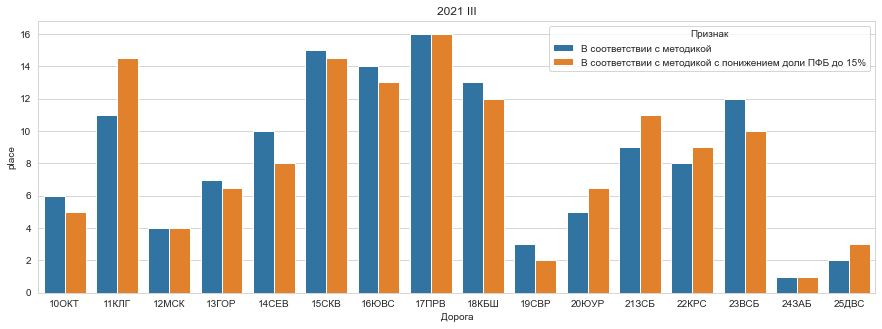

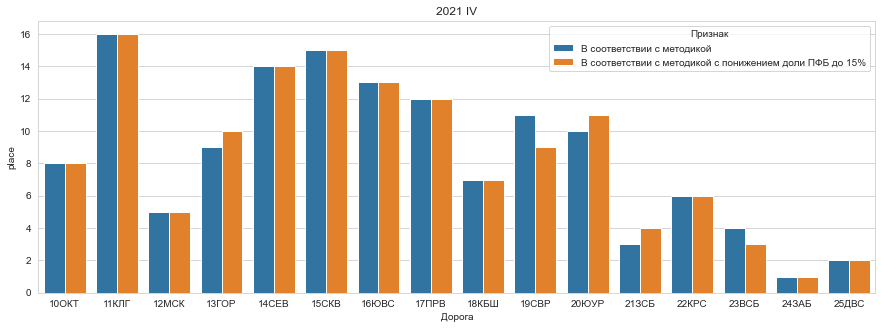

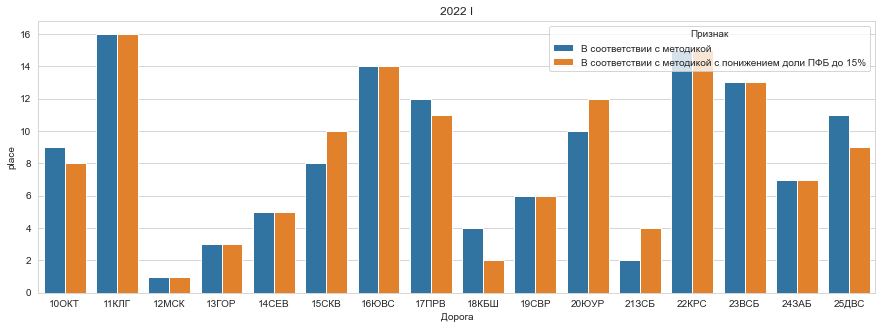

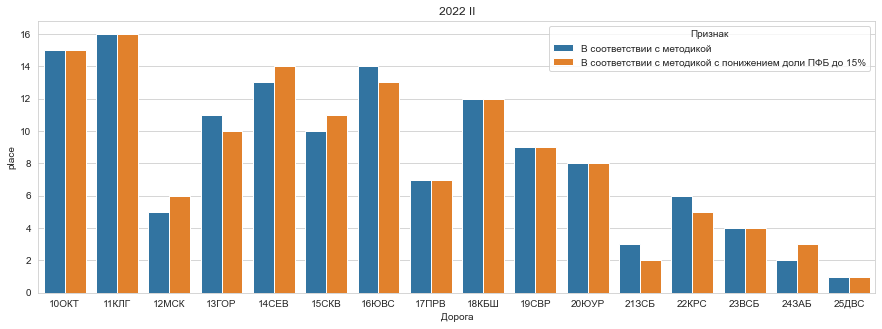

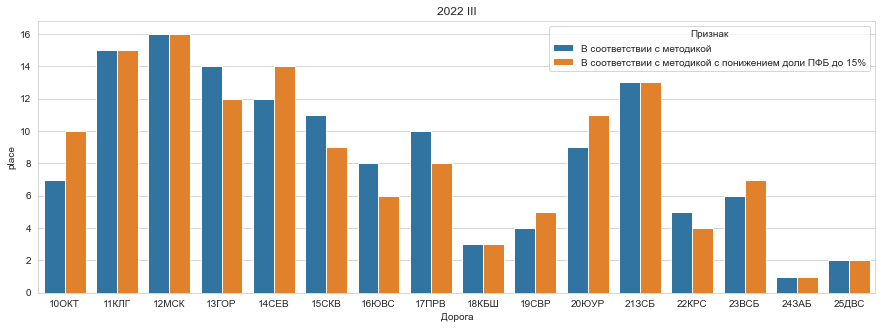

In [53]:
for i in xyz['Период'].unique():
    plt.figure(figsize=(15,5))
    sns.barplot(data=xyz[xyz['Период']==i], x='Дорога', y='place', hue='Признак')
    plt.title(i)


Text(0.5, 1.0, 'Средний рейтинг за 5 кварталов')

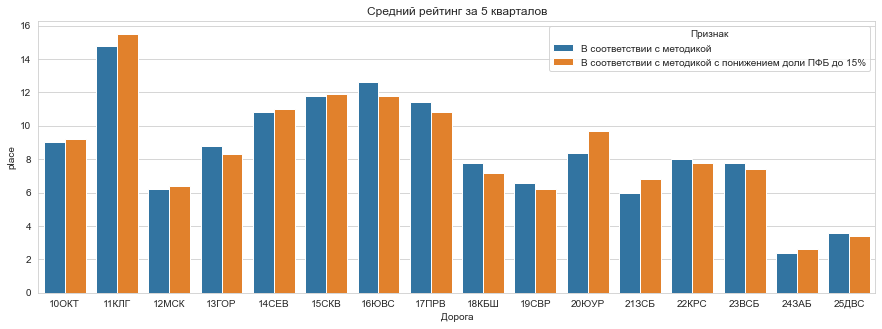

In [52]:
plt.figure(figsize=(15,5))
sns.barplot(data=xyz.groupby(['Дорога','Признак'],as_index=False)['place'].agg('mean'), x='Дорога', y='place', hue='Признак')
plt.title('Средний рейтинг за 5 кварталов')

In [55]:
x

Дорога    Период  rating                     Признак
                                                        
80   10ОКТ  2021 III  6.1750  В соответствии с методикой
81   11КЛГ  2021 III  8.1000  В соответствии с методикой
82   12МСК  2021 III  3.7875  В соответствии с методикой
83   13ГОР  2021 III  6.8750  В соответствии с методикой
84   14СЕВ  2021 III  8.0875  В соответствии с методикой
..     ...       ...     ...                         ...
507  21ЗСБ  2022 III  7.6250  В соответствии с методикой
508  22КРС  2022 III  3.0125  В соответствии с методикой
509  23ВСБ  2022 III  3.7625  В соответствии с методикой
510  24ЗАБ  2022 III  1.0250  В соответствии с методикой
511  25ДВС  2022 III  1.3750  В соответствии с методикой

[80 rows x 4 columns]

### Расчет без округления и с рангами без смещения к 16, а также с объединением в группу схожих показателей

In [57]:
df1_kvart=df1[df1['Кол-во месяцев в периоде']==3]

In [58]:
k1=[i for i in k if i not in ['КЗ','УШ','Себестоимость','Погрузка грузов']]

In [59]:
k2=[i for i in k if i not in k1]

In [60]:
type_metr = {'Вып.расп.пасс.': 1,
 'Доля': 1,
 'Вып.расп.приг.': 1,
 'КЗ': 1, #отдельное условие в приложении
 'ДЗ': -1,
 'Выручка': 1,
 'Себестоимость': -1,
 'Кач. балл. оц.': 1,
 'Уч. скорость': 1,
 'Пр.ЭП': 1,
 'Погрузка грузов': 1,
 'Фин. рез. ПВД': 1,
 'Уд. время задержки': -1,
 'УШ': 1,
 'ПФБ': - 1}
weight_metr = {'Вып.расп.пасс.': .05,
 'Доля': .05,
 'Вып.расп.приг.': .05,
 'КЗ': .025,
 'ДЗ': .025,
 'Выручка': .1,
 'Себестоимость': .1,
 'Кач. балл. оц.': .05,
 'Уч. скорость': .025,
 'Пр.ЭП': .05,
 'Погрузка грузов': .1,
 'Фин. рез. ПВД': .05,
 'Уд. время задержки': .05,
 'УШ': .025,
 'ПФБ': .25,
 'gruppk1': .75             }

df1_kvart.loc[:,('gruppk1','vip')] = 0
for i in k1:
    df1_kvart.loc[:,(i,'vip_inv_stand_gr')] = (df1_kvart[(i,'vip_inv')] - df1_kvart[(i,'vip_inv')].mean()) / df1_kvart[(i,'vip_inv')].std()
    df1_kvart.loc[:,('gruppk1','vip')] = df1_kvart.loc[:,('gruppk1','vip')] + df1_kvart[(i,'vip_inv_stand_gr')] * weight_metr[i]
df1_kvart.sort_index(axis=1)

In [61]:
plt.rcParams.update({'font.size': 14})

In [313]:
df1_kvart[[('gruppk1','vip'),('gruppk1','vip_full')]] = 0
for i in k1:
    df1_kvart[[(i,'vip_inv_mean'),(i,'vip_inv_std')]]=None
    df1_kvart[[(i,'vip_inv_mean')]] = df1_kvart.loc[:,[(i,'vip_inv'),('Дорога','')]].groupby(('Дорога',''), as_index=False)[[(i,'vip_inv')]].transform('mean')
    df1_kvart[[(i,'vip_inv_std')]] = df1_kvart.loc[:,[(i,'vip_inv'),('Дорога','')]].groupby(('Дорога',''), as_index=False)[[(i,'vip_inv')]].transform('std')
    df1_kvart[[(i,'vip_inv_std_min')]] = df1_kvart[(i,'vip_inv_std')].min()
    df1_kvart.loc[:,(i,'vip_inv_stdnormed')] = df1_kvart[(i,'vip_inv_mean')] + (df1_kvart[(i,'vip_inv')] - df1_kvart[(i,'vip_inv_mean')]) * df1_kvart[(i,'vip_inv_std_min')] / df1_kvart[(i,'vip_inv_std')]
    df1_kvart.loc[:,(i,'vip_inv_stand_gr_full')] = (df1_kvart[(i,'vip_inv_stdnormed')] - df1_kvart[(i,'vip_inv_stdnormed')].mean()) / df1_kvart[(i,'vip_inv_stdnormed')].std()
    df1_kvart.loc[:,(i,'vip_inv_stand_gr')] = (df1_kvart[(i,'vip_inv')] - df1_kvart[(i,'vip_inv')].mean()) / df1_kvart[(i,'vip_inv')].std()
    df1_kvart.loc[:,('gruppk1','vip_full')] = df1_kvart.loc[:,('gruppk1','vip_full')] + df1_kvart[(i,'vip_inv_stand_gr_full')] * weight_metr[i]
    df1_kvart.loc[:,('gruppk1','vip')] = df1_kvart.loc[:,('gruppk1','vip')] + df1_kvart[(i,'vip_inv_stand_gr')] * weight_metr[i]
df1_kvart.sort_index(axis=1)

gruppk1           Вып.расп.пасс.                                         \
          vip  vip_full            vip   vip_inv vip_inv_mean vip_inv_ok_neok   
80   0.036155  0.038458       0.005295  0.005295    -0.000727        0.005295   
192 -0.027775  0.002367      -0.008000 -0.008000    -0.000727       -0.008000   
288  0.110468  0.145365      -0.008901 -0.008901    -0.000727       -0.008901   
384  0.217304  0.125177       0.006818  0.006818    -0.000727        0.006818   
496 -0.172685 -0.151565       0.001153  0.001153    -0.000727        0.001153   
..        ...       ...            ...       ...          ...             ...   
95  -0.074097 -0.194240      -0.004448 -0.004448    -0.019000       -0.004448   
207 -0.155273 -0.196851      -0.029063 -0.029063    -0.019000       -0.029063   
303  0.125946 -0.023782      -0.011058 -0.011058    -0.019000       -0.011058   
399 -0.101331 -0.203143      -0.013656 -0.013656    -0.019000       -0.013656   
511 -0.393461 -0.357813      -0.036773 -0.036773    -0.019000       -0.036773   

                                                                           \
    vip_inv_ok_ok vip_inv_ok_ok_ok vip_inv_stand_gr vip_inv_stand_gr_full   
80          0.005            0.005         0.311861              0.285312   
192        -0.008           -0.008         0.033751              0.154468   
288        -0.009           -0.009         0.014898              0.145598   
384         0.007            0.007         0.343717              0.300299   
496         0.001            0.001         0.225225              0.244552   
..            ...              ...              ...                   ...   
95         -0.004           -0.004         0.108053             -0.160269   
207        -0.029           -0.029        -0.406863             -0.293042   
303        -0.011           -0.011        -0.030222             -0.195924   
399        -0.014           -0.014        -0.084561             -0.209935   
511        -0.037           -0.037        -0.568135             -0.334627   

                                                                         \
    vip_inv_std vip_inv_std_min vip_inv_stdnormed vip_ok_neok vip_ok_ok   
80     0.007356        0.002846      1.602799e-03    0.005295     0.005   
192    0.007356        0.002846     -3.540976e-03   -0.008000    -0.008   
288    0.007356        0.002846     -3.889676e-03   -0.008901    -0.009   
384    0.007356        0.002846      2.192002e-03    0.006818     0.007   
496    0.007356        0.002846      4.363713e-07    0.001153     0.001   
..          ...             ...               ...         ...       ...   
95     0.013421        0.002846     -1.591400e-02   -0.004448    -0.004   
207    0.013421        0.002846     -2.113364e-02   -0.029063    -0.029   
303    0.013421        0.002846     -1.731568e-02   -0.011058    -0.011   
399    0.013421        0.002846     -1.786650e-02   -0.013656    -0.014   
511    0.013421        0.002846     -2.276844e-02   -0.036773    -0.037   

                                                Вып.расп.приг.            \
    vip_ok_ok_ok    Факт Факт_ok   Цель Цель_ok            vip   vip_inv   
80         0.005  98.539  98.539  98.02   98.02       0.003270  0.003270   
192       -0.008  97.960  97.960  98.75   98.75      -0.001525 -0.001525   
288       -0.009  97.871  97.871  98.75   98.75       0.003110  0.003110   
384        0.007  98.648  98.648  97.98   97.98       0.008122  0.008122   
496        0.001  98.093  98.093  97.98   97.98       0.007217  0.007217   
..           ...     ...     ...    ...     ...            ...       ...   
95        -0.004  97.584  97.584  98.02   98.02       0.001848  0.001848   
207       -0.029  95.880  95.880  98.75   98.75      -0.027239 -0.027239   
303       -0.011  97.658  97.658  98.75   98.75      -0.019158 -0.019158   
399       -0.014  96.642  96.642  97.98   97.98      -0.001880 -0.001880   
511       -0.037  94.377  94.377  97.98   97.98      -0.008650

In [314]:
def ranking2(per, year=0):
    global df1_kvart
    df_r_bir=df1_kvart
    df_r_bir=df_r_bir[df_r_bir[('Период','')]==per]
    for i in k2:
        #положительные в диапазоне 0.95-1.05, остальные - отрицательные
        if i in ['КЗ']:
            if sum(df_r_bir[(i,'Цель')])==sum(df_r_bir[(i,'Факт')]):
                #для нулевых месяцев (январь, февраль)
                df_r_bir.loc[(df_r_bir[(i,'vip_inv')]>=0) & (df_r_bir[(i,'Факт')]==0) & (df_r_bir[(i,'Цель')]==0),(i,'rank0')] = 0
                df_r_bir.loc[(df_r_bir[(i,'vip_inv')]>=0) & (df_r_bir[(i,'Факт')]==0) & (df_r_bir[(i,'Цель')]==0),(i,'rank')] = 0
            else:
                #присваиваем баллы показателям в диапазоне
                df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank0')] = df_r_bir[
                    (df_r_bir[(i,'vip')]<=0.05)].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=False)[(i,'vip')]
                #присваиваем отрицательные ранги
                df_r_bir.loc[(df_r_bir[(i,'vip')]>0.05),(i,'rank')] = - df_r_bir[
                    (df_r_bir[(i,'vip')]>0.05)].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
                if len(df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank0')])==16:
                    df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank')] =  df_r_bir.loc[
                        (df_r_bir[(i,'vip')]<=0.05),(i,'rank0')]
                else:
                    df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank')] =  df_r_bir.loc[
                                                                                (df_r_bir[(i,'vip')]<=0.05),(i,'rank0')]-df_r_bir.loc[(df_r_bir[(i,'vip')]>0.05),(i,'rank')].min()

        #если больше 1 - отрицательные баллы от наименьшего, если меньше - положительные от наименьшего
        elif i in ['Себестоимость']:
            #присваиваем положительные баллы от большего к меньшему для выполнивших цель дорог
            df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank0')] = df_r_bir[
                (df_r_bir[(i,'vip')]<=0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
            #присваиваем отрицательные баллы
            df_r_bir.loc[(df_r_bir[(i,'vip')]>0),(i,'rank')] = - df_r_bir[
                (df_r_bir[(i,'vip')]>0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
            df_r_bir.loc[(df_r_bir[(i,'Факт')]==0) | (df_r_bir[(i,'Цель')]==0),(i,'rank')] = np.nan

            if len(df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank0')])==16:
                df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank')] =  df_r_bir.loc[
                    (df_r_bir[(i,'vip')]<=0),(i,'rank0')]
            else:
                df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank')] =  df_r_bir.loc[
                                                                         (df_r_bir[(i,'vip')]<=0),(i,'rank0')]-df_r_bir.loc[(df_r_bir[(i,'vip')]>0),(i,'rank')].min()

        #если x>=1 - среднее арифметическое от присвоенных баллов, если Цель<x<1 - остальные положительные баллы
        #если x<Цель - отрицательные баллы
        elif i in ['УШ']:
            df_r_bir.loc[(df_r_bir[(i,'Факт')]<df_r_bir[(i,'Цель')]),(i,'rank')] = - df_r_bir[
                (df_r_bir[(i,'Факт')]<df_r_bir[(i,'Цель')])].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=False)[(i,'vip')]

            df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                (df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')])].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]

            if len(df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')])==16:
                df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank')] =  df_r_bir.loc[
                    (df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')]
            else:
                df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank')] =  df_r_bir.loc[
                                                                                            (df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')]-df_r_bir.loc[(df_r_bir[(i,'Факт')]<df_r_bir[(i,'Цель')]),(i,'rank')].min()

            df_r_bir.loc[(df_r_bir[(i,'Факт')]>100),(i,'rank')] = df_r_bir.loc[(df_r_bir[(i,'Факт')]>100),(i,'rank')].mean()

        #положительные баллы - в первую очередь для тех, кто выполнил первоначальный план, даже при условии не выполнения скорректированного
        #положительные баллы во вторую очередь тем, кто выполнил скорректированный в меньшую сторону план при невыполнении первоначального
        #отрицательные баллы - если не выполнены ни первоначальный, ни скорректированный планы
        elif i in ['Погрузка грузов']:
            #отрицательные баллы
            df_r_bir.loc[(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'vip')]<0),(i,'rank0')] = - df_r_bir[
                (df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'vip')]<0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=False)[(i,'vip')]
            #если есть отрицательные баллы
            if df_r_bir[(i,'rank0')].max()<0:
                #если выполнен скорреткированный план, но не выполнен первоначальный по дорогам, у которых план изменился в меньшую сторону
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                                                                                                                                                                (df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+abs(df_r_bir[(i,'rank0')]).max()
                #если не выполнен скорректированный план, но выполнен первоначальный
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                                                                                                                                                                (df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+abs(df_r_bir[(i,'rank0')]).max()
            #если нет отрицательных баллов
            else:
                #аналогично, но смотрим на неокругленное выполнение
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                    (df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]

                #аналогично, но смотрим на неокругленное выполнение
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                    (df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]

            #положительные баллы, если выполнены оба плана
            #либо если выполнен только первоначальный, но не выполнен скорректированный (бывает повышают план в таком случае, но считают все равно по первоначальному)
            #если есть отрицательные баллы
            if df_r_bir[(i,'rank0')].max()<0:
                df_r_bir.loc[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))
                ,(i,'rank')] = df_r_bir[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+abs(df_r_bir[(i,'rank0')]).max()
            #если нет отрицательных баллов
            else:
                df_r_bir.loc[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))
                ,(i,'rank')] = df_r_bir[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+df_r_bir[(i,'rank0')].max()
            df_r_bir[(i,'rank')].update(df_r_bir[(i,'rank0')])
            #             df_r_bir = df_r_bir.drop((i,'rank0'), axis=1)
            #положительные - x>=0, иначе отрицательные
        df_r_bir[(i, 'rank')] = df_r_bir[(i, 'rank')] - df_r_bir[(i, 'rank')].mean()

    for i in ['gruppk1']:
        #для нулевых месяцев по ДЗ (январь, февраль)
        df_r_bir.loc[:,(i,'rank')] = df_r_bir.groupby(('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
    global df_r_biranked
    df_r_biranked = df_r_biranked.append(df_r_bir)

In [315]:
df_r_biranked=pd.DataFrame()
for per in df1_kvart[('Период','')].unique():
    ranking2(per)

In [317]:
df_r_biranked.loc[:,('rating','')] = 0
for i in k2+['gruppk1']:
    df_r_biranked.loc[:,('rating','')] = df_r_biranked.loc[:,('rating','')] + df_r_biranked[(i,'rank')] * weight_metr[i]
df_r_biranked.sort_index(axis=1)

gruppk1                       rating Вып.расп.пасс.            \
       rank       vip  vip_full                     vip   vip_inv   
80      9.0  0.036155  0.038458   7.3250       0.005295  0.005295   
81      1.0 -0.527179  0.651409   3.0375       0.019404  0.019404   
82      5.0 -0.067700 -0.003305   4.5500       0.005091  0.005091   
83     13.0  0.081589  0.169709  11.1250       0.006744  0.006744   
84      6.0 -0.037955  0.138727   6.1750       0.009376  0.009376   
..      ...       ...       ...      ...            ...       ...   
507    12.0  0.004056 -0.193402  11.1875       0.010584  0.010584   
508     5.0 -0.292941 -0.076860   6.0875      -0.018014 -0.018014   
509     7.0 -0.250190 -0.277241   7.2125      -0.008839 -0.008839   
510     1.0 -2.614472 -1.428053   2.4000      -0.348398 -0.348398   
511     2.0 -0.393461 -0.357813   3.5000      -0.036773 -0.036773   

                                                                 \
    vip_inv_mean vip_inv_ok_neok vip_inv_ok_ok vip_inv_ok_ok_ok   
80     -0.000727        0.005295         0.005            0.005   
81      0.012657        0.019404         0.019            0.019   
82     -0.002797        0.005091         0.005            0.005   
83      0.002631        0.006744         0.007            0.007   
84      0.007802        0.009376         0.009            0.009   
..           ...             ...           ...              ...   
507     0.009381        0.010584         0.011            0.011   
508    -0.003727       -0.018014        -0.018           -0.018   
509    -0.003276       -0.008839        -0.009           -0.009   
510    -0.158078       -0.348398        -0.348           -0.348   
511    -0.019000       -0.036773        -0.037           -0.037   

                                                                        \
    vip_inv_stand_gr vip_inv_stand_gr_full vip_inv_std vip_inv_std_min   
80          0.311861              0.285312    0.007356        0.002846   
81          0.607009              0.652135    0.005704        0.002846   
82          0.307592              0.259583    0.006625        0.002846   
83          0.342165              0.379056    0.004405        0.002846   
84          0.397225              0.460858    0.006380        0.002846   
..               ...                   ...         ...             ...   
507         0.422498              0.513764    0.002846        0.002846   
508        -0.175725              0.031778    0.008768        0.002846   
509         0.016210              0.084874    0.005276        0.002846   
510        -7.086888             -3.892970    0.118348        0.002846   
511        -0.568135             -0.334627    0.013421        0.002846   

                                                                          \
    vip_inv_stdnormed vip_ok_neok vip_ok_ok vip_ok_ok_ok    Факт Факт_ok   
80           0.001603    0.005295     0.005        0.005  98.539  98.539   
81           0.016023    0.019404     0.019        0.019  99.922  99.922   
82           0.000591    0.005091     0.005        0.005  98.519  98.519   
83           0.005288    0.006744     0.007        0.007  98.681  98.681   
84           0.008504    0.009376     0.009        0.009  98.939  98.939   
..                ...         ...       ...          ...     ...     ...   
507          0.010584    0.010584     0.011        0.011  99.017  99.017   
508         -0.008364   -0.018014    -0.018       -0.018  96.215  96.215   
509         -0.006277   -0.008839    -0.009       -0.009  97.114  97.114   
510         -0.162655   -0.348398    -0.348       -0.348  63.844  63.844   
511         -0.022768   -0.036773    -0.037       -0.037  94.377  94.377   

                   Вып.расп.приг.                                         \
      Цель Цель_ok            vip   vip_inv vip_inv_mean vip_inv_ok_neok   
80   98.02   98.02       0.003270  0.003270     0.004039        0.003270   
81   98.02   98.02       0.012452  0.012452     0.0138

In [318]:
x=df_ranked[df_ranked['Кол-во месяцев в периоде']==3].loc[:,(['Дорога','Период','rating'],['','',''])]
x['Признак']='В соответствии с методикой'

In [319]:
x2=df_r_biranked[df_r_biranked['Кол-во месяцев в периоде']==3].loc[:,(['Дорога','Период','rating'],['','',''])]
x2['Признак']='С объединением показателей в группу'

In [320]:
xyz=pd.concat([x,x2], axis=0)

In [321]:
xyz['place']=xyz.groupby([('Период',''),('Признак','')], as_index=False)['rating'].rank(ascending=True)

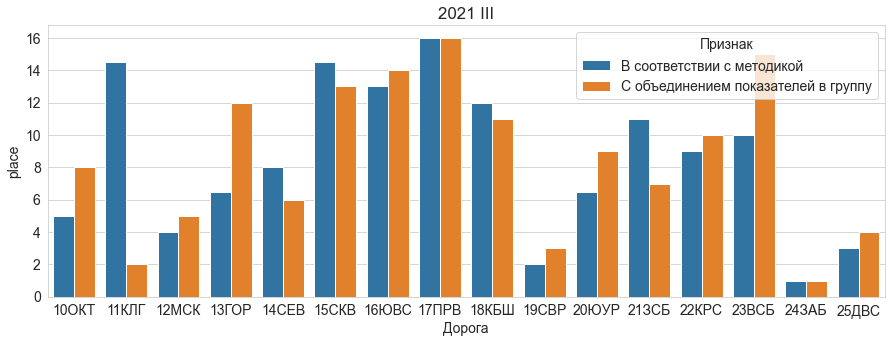

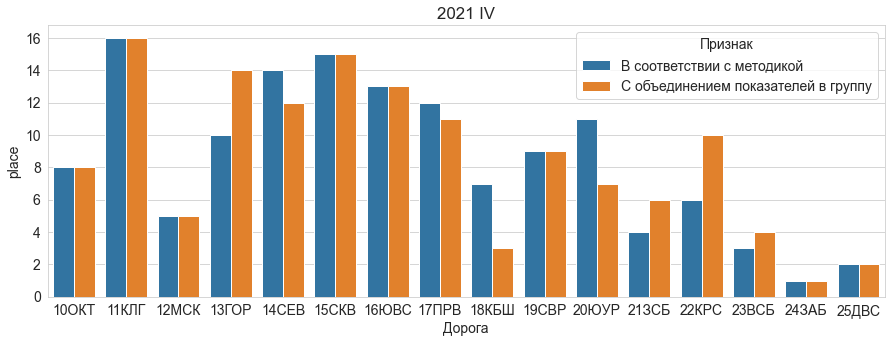

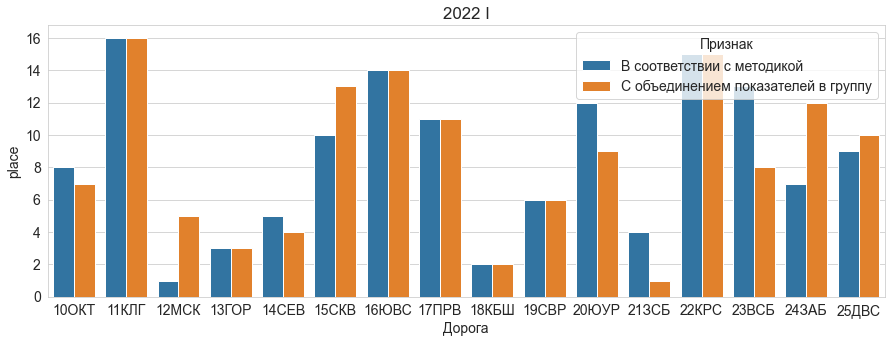

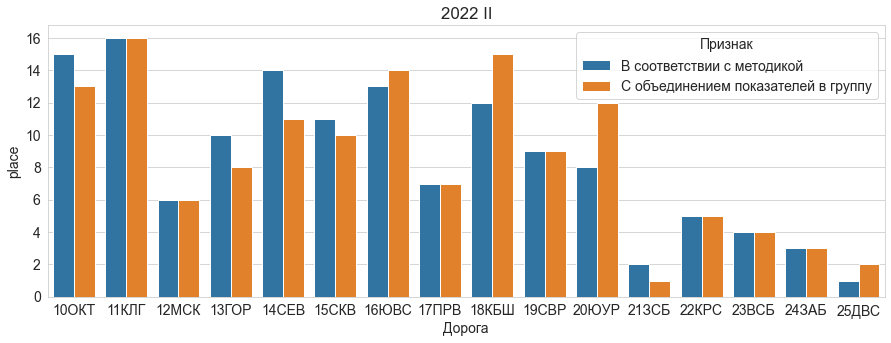

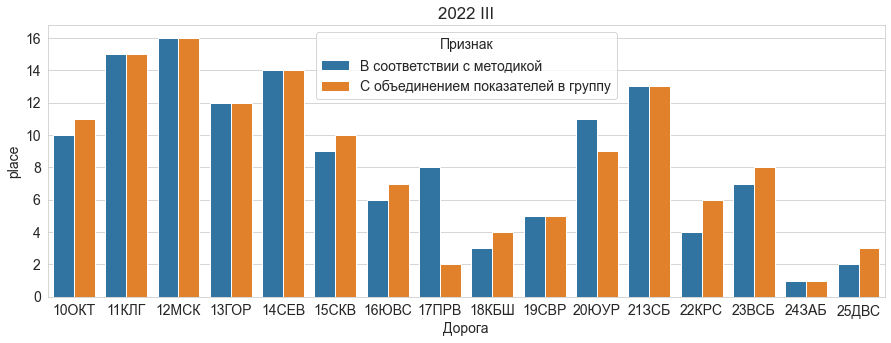

In [322]:
for i in xyz['Период'].unique():
    plt.figure(figsize=(15,5))
    sns.barplot(data=xyz[xyz['Период']==i], x='Дорога', y='place', hue='Признак')
    plt.title(i)


### ПЕРЕХОД к новой шкале

In [62]:
for i in k1:
    df1_kvart [(i,'otkl')] = df1_kvart[(i,'Факт')] - df1_kvart[(i, 'Цель')]
    df1_kvart[(i,'upper_bor')] = df1_kvart.groupby(('Дорога',''),as_index=False)[[(i,'otkl')]].transform(lambda x: x[df1_kvart[(i,'otkl')]>0].median())[(i,'otkl')] + df1_kvart[(i, 'Цель')]
    df1_kvart.loc[df1_kvart[(i,'upper_bor')].isna(),(i,'upper_bor')] = df1_kvart[df1_kvart[(i,'upper_bor')].isna()][(i,'Цель')]

    df1_kvart[(i,'lower_bor')]= df1_kvart.groupby(('Дорога',''),as_index=False)[[(i,'otkl')]].transform(lambda x: x[df1_kvart[(i,'otkl')]<=0].median())[(i,'otkl')] + df1_kvart[(i,'Цель')]
    df1_kvart.loc[df1_kvart[(i,'lower_bor')].isna(),(i,'lower_bor')] = df1_kvart[df1_kvart[(i,'lower_bor')].isna()][(i,'Цель')]

#    df1_kvart.loc[:,(i,'vip_inv')] = df1_kvart.loc[:,(i,'Факт')] / df1_kvart.loc[:,(i,'Цель')] - 1


df1_kvart.sort_index(axis=1)


Вып.расп.пасс.                                                       \
         lower_bor   otkl upper_bor       vip   vip_inv vip_inv_ok_neok   
80         97.1855  0.519    98.539  0.005295  0.005295        0.005295   
192        97.9155 -0.790    99.269 -0.008000 -0.008000       -0.008000   
288        97.9155 -0.879    99.269 -0.008901 -0.008901       -0.008901   
384        97.1455  0.668    98.499  0.006818  0.006818        0.006818   
496        97.1455  0.113    98.499  0.001153  0.001153        0.001153   
..             ...    ...       ...       ...       ...             ...   
95         96.6820 -0.436    98.020 -0.004448 -0.004448       -0.004448   
207        97.4120 -2.870    98.750 -0.029063 -0.029063       -0.029063   
303        97.4120 -1.092    98.750 -0.011058 -0.011058       -0.011058   
399        96.6420 -1.338    97.980 -0.013656 -0.013656       -0.013656   
511        96.6420 -3.603    97.980 -0.036773 -0.036773       -0.036773   

                                                                               \
    vip_inv_ok_ok vip_inv_ok_ok_ok vip_ok_neok vip_ok_ok vip_ok_ok_ok    Факт   
80          0.005            0.005    0.005295     0.005        0.005  98.539   
192        -0.008           -0.008   -0.008000    -0.008       -0.008  97.960   
288        -0.009           -0.009   -0.008901    -0.009       -0.009  97.871   
384         0.007            0.007    0.006818     0.007        0.007  98.648   
496         0.001            0.001    0.001153     0.001        0.001  98.093   
..            ...              ...         ...       ...          ...     ...   
95         -0.004           -0.004   -0.004448    -0.004       -0.004  97.584   
207        -0.029           -0.029   -0.029063    -0.029       -0.029  95.880   
303        -0.011           -0.011   -0.011058    -0.011       -0.011  97.658   
399        -0.014           -0.014   -0.013656    -0.014       -0.014  96.642   
511        -0.037           -0.037   -0.036773    -0.037       -0.037  94.377   

                           Вып.расп.приг.                             \
    Факт_ok   Цель Цель_ok      lower_bor   otkl upper_bor       vip   
80   98.539  98.02   98.02         98.310  0.322    98.976  0.003270   
192  97.960  98.75   98.75         98.240 -0.150    98.906 -0.001525   
288  97.871  98.75   98.75         98.240  0.306    98.906  0.003110   
384  98.648  97.98   97.98         98.230  0.799    98.896  0.008122   
496  98.093  97.98   97.98         98.230  0.710    98.896  0.007217   
..      ...    ...     ...            ...    ...       ...       ...   
95   97.584  98.02   98.02         97.092  0.182    98.642  0.001848   
207  95.880  98.75   98.75         97.022 -2.680    98.572 -0.027239   
303  97.658  98.75   98.75         97.022 -1.885    98.572 -0.019158   
399  96.642  97.98   97.98         97.012 -0.185    98.562 -0.001880   
511  94.377  97.98   97.98         97.012 -0.851    98.562 -0.008650   

                                                                          \
      vip_inv vip_inv_ok_neok vip_inv_ok_ok vip_inv_ok_ok_ok vip_ok_neok   
80   0.003270        0.003270         0.003            0.003    0.003270   
192 -0.001525       -0.001525        -0.002           -0.002   -0.001525   
288  0.003110        0.003110         0.003            0.003    0.003110   
384  0.008122        0.008122         0.008            0.008    0.008122   
496  0.007217        0.007217         0.007            0.007    0.007217   
..        ...             ...           ...              ...         ...   
95   0.001848        0.001848         0.002            0.002    0.001848   
207 -0.027239       -0.027239        -0.027           -0.027   -0.027239   
303 -0.019158       -0.019158        -0.019           -0.019   -0.019158   
399 -0.001880       -0.001880        -0.002           -0.002   -0.001880   
511 -0.008650       -0.008650        -0.009           -0.009   -0.008650   

                                                

In [63]:
def ranking2(per, year=0):
    global df1_kvart
    df_r_bir=df1_kvart
    df_r_bir=df_r_bir[df_r_bir[('Период','')]==per]
    for i in k2:
        #положительные в диапазоне 0.95-1.05, остальные - отрицательные
        if i in ['КЗ']:
            if sum(df_r_bir[(i,'Цель')])==sum(df_r_bir[(i,'Факт')]):
                #для нулевых месяцев (январь, февраль)
                df_r_bir.loc[(df_r_bir[(i,'vip_inv')]>=0) & (df_r_bir[(i,'Факт')]==0) & (df_r_bir[(i,'Цель')]==0),(i,'rank0')] = 0
                df_r_bir.loc[(df_r_bir[(i,'vip_inv')]>=0) & (df_r_bir[(i,'Факт')]==0) & (df_r_bir[(i,'Цель')]==0),(i,'rank')] = 0
            else:
                #присваиваем баллы показателям в диапазоне
                df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank0')] = df_r_bir[
                    (df_r_bir[(i,'vip')]<=0.05)].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=False)[(i,'vip')]
                #присваиваем отрицательные ранги
                df_r_bir.loc[(df_r_bir[(i,'vip')]>0.05),(i,'rank')] = - df_r_bir[
                    (df_r_bir[(i,'vip')]>0.05)].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
                if len(df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank0')])==16:
                    df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank')] =  df_r_bir.loc[
                        (df_r_bir[(i,'vip')]<=0.05),(i,'rank0')]
                else:
                    df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank')] =  df_r_bir.loc[
                                                                                (df_r_bir[(i,'vip')]<=0.05),(i,'rank0')]-df_r_bir.loc[(df_r_bir[(i,'vip')]>0.05),(i,'rank')].min()

        #если больше 1 - отрицательные баллы от наименьшего, если меньше - положительные от наименьшего
        elif i in ['Себестоимость']:
            #присваиваем положительные баллы от большего к меньшему для выполнивших цель дорог
            df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank0')] = df_r_bir[
                (df_r_bir[(i,'vip')]<=0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
            #присваиваем отрицательные баллы
            df_r_bir.loc[(df_r_bir[(i,'vip')]>0),(i,'rank')] = - df_r_bir[
                (df_r_bir[(i,'vip')]>0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
            df_r_bir.loc[(df_r_bir[(i,'Факт')]==0) | (df_r_bir[(i,'Цель')]==0),(i,'rank')] = np.nan

            if len(df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank0')])==16:
                df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank')] =  df_r_bir.loc[
                    (df_r_bir[(i,'vip')]<=0),(i,'rank0')]
            else:
                df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank')] =  df_r_bir.loc[
                                                                         (df_r_bir[(i,'vip')]<=0),(i,'rank0')]-df_r_bir.loc[(df_r_bir[(i,'vip')]>0),(i,'rank')].min()

        #если x>=1 - среднее арифметическое от присвоенных баллов, если Цель<x<1 - остальные положительные баллы
        #если x<Цель - отрицательные баллы
        elif i in ['УШ']:
            df_r_bir.loc[(df_r_bir[(i,'Факт')]<df_r_bir[(i,'Цель')]),(i,'rank')] = - df_r_bir[
                (df_r_bir[(i,'Факт')]<df_r_bir[(i,'Цель')])].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=False)[(i,'vip')]

            df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                (df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')])].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]

            if len(df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')])==16:
                df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank')] =  df_r_bir.loc[
                    (df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')]
            else:
                df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank')] =  df_r_bir.loc[
                                                                                            (df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')]-df_r_bir.loc[(df_r_bir[(i,'Факт')]<df_r_bir[(i,'Цель')]),(i,'rank')].min()

            df_r_bir.loc[(df_r_bir[(i,'Факт')]>100),(i,'rank')] = df_r_bir.loc[(df_r_bir[(i,'Факт')]>100),(i,'rank')].mean()

        #положительные баллы - в первую очередь для тех, кто выполнил первоначальный план, даже при условии не выполнения скорректированного
        #положительные баллы во вторую очередь тем, кто выполнил скорректированный в меньшую сторону план при невыполнении первоначального
        #отрицательные баллы - если не выполнены ни первоначальный, ни скорректированный планы
        elif i in ['Погрузка грузов']:
            #отрицательные баллы
            df_r_bir.loc[(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'vip')]<0),(i,'rank0')] = - df_r_bir[
                (df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'vip')]<0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=False)[(i,'vip')]
            #если есть отрицательные баллы
            if df_r_bir[(i,'rank0')].max()<0:
                #если выполнен скорреткированный план, но не выполнен первоначальный по дорогам, у которых план изменился в меньшую сторону
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                                                                                                                                                                (df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+abs(df_r_bir[(i,'rank0')]).max()
                #если не выполнен скорректированный план, но выполнен первоначальный
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                                                                                                                                                                (df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+abs(df_r_bir[(i,'rank0')]).max()
            #если нет отрицательных баллов
            else:
                #аналогично, но смотрим на неокругленное выполнение
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                    (df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]

                #аналогично, но смотрим на неокругленное выполнение
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                    (df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]

            #положительные баллы, если выполнены оба плана
            #либо если выполнен только первоначальный, но не выполнен скорректированный (бывает повышают план в таком случае, но считают все равно по первоначальному)
            #если есть отрицательные баллы
            if df_r_bir[(i,'rank0')].max()<0:
                df_r_bir.loc[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))
                ,(i,'rank')] = df_r_bir[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+abs(df_r_bir[(i,'rank0')]).max()
            #если нет отрицательных баллов
            else:
                df_r_bir.loc[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))
                ,(i,'rank')] = df_r_bir[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+df_r_bir[(i,'rank0')].max()
            df_r_bir[(i,'rank')].update(df_r_bir[(i,'rank0')])
            #             df_r_bir = df_r_bir.drop((i,'rank0'), axis=1)
            #положительные - x>=0, иначе отрицательные
        df_r_bir[(i, 'rank')] = df_r_bir[(i, 'rank')] - df_r_bir[(i, 'rank')].mean()

    for i in k1:
        if type_metr[i]==-1:
            df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')],(i,'rank')] = - df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')],(i,'vip_inv')].rank(ascending=False) - (16 - df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')],(i,'vip_inv')].rank(ascending=False)).min()
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'upper_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'Цель')]),(i,'rank')] = - df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'upper_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'Цель')]),(i,'vip_inv')].rank(ascending=False)
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'lower_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'Цель')]),(i,'rank')] = df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'lower_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'Цель')]),(i,'vip_inv')].rank(ascending=True)
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')]),(i,'rank')] = df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')]) ,(i,'vip_inv')].rank(ascending=True) + (16 - df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')]) ,(i,'vip_inv')].rank(ascending=True).max())
        else:
            df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')],(i,'rank')] = df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')]) ,(i,'vip_inv')].rank(ascending=True) + (16 - df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')]) ,(i,'vip_inv')].rank(ascending=True).max())
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'upper_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'Цель')]),(i,'rank')] = df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'upper_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'Цель')]),(i,'vip_inv')].rank(ascending=True)
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'lower_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'Цель')]),(i,'rank')] = - df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'lower_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'Цель')]),(i,'vip_inv')].rank(ascending=False)
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')]),(i,'rank')] = - df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')],(i,'vip_inv')].rank(ascending=False) - (16 - df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')],(i,'vip_inv')].rank(ascending=False)).min()
    global df_r_biranked
    df_r_biranked = df_r_biranked.append(df_r_bir)

In [65]:
df_r_biranked=pd.DataFrame()
for per in df1_kvart[('Период','')].unique():
    ranking2(per)

In [66]:
df_r_biranked.loc[:,('rating','')] = 0
for i in k2 + k1:
    df_r_biranked.loc[:,('rating','')] = df_r_biranked.loc[:,('rating','')] + df_r_biranked[(i,'rank')] * weight_metr[i]
df_r_biranked.sort_index(axis=1)

rating Вып.расп.пасс.                                              \
                 lower_bor    otkl  rank upper_bor       vip   vip_inv   
80   3.6625        97.1855   0.519   4.0   98.5390  0.005295  0.005295   
81   4.5375        98.0200   1.902  16.0   99.3070  0.019404  0.019404   
82   1.0375        97.0655   0.499  12.0   98.0400  0.005091  0.005091   
83   3.8125        97.6700   0.661  13.0   98.4750  0.006744  0.006744   
84   5.5125        97.8340   0.919   5.0   99.1135  0.009376  0.009376   
..      ...            ...     ...   ...       ...       ...       ...   
507  3.1875        97.9800   1.037   5.0   99.0170  0.010584  0.010584   
508 -0.4125        97.4300  -1.765 -13.0   98.2705 -0.018014 -0.018014   
509 -0.6375        97.4405  -0.866 -11.0   98.4320 -0.008839 -0.008839   
510 -4.6250        86.6300 -34.136 -16.0   97.9800 -0.348398 -0.348398   
511 -3.9500        96.6420  -3.603 -15.0   97.9800 -0.036773 -0.036773   

                                                                          \
    vip_inv_ok_neok vip_inv_ok_ok vip_inv_ok_ok_ok vip_ok_neok vip_ok_ok   
80         0.005295         0.005            0.005    0.005295     0.005   
81         0.019404         0.019            0.019    0.019404     0.019   
82         0.005091         0.005            0.005    0.005091     0.005   
83         0.006744         0.007            0.007    0.006744     0.007   
84         0.009376         0.009            0.009    0.009376     0.009   
..              ...           ...              ...         ...       ...   
507        0.010584         0.011            0.011    0.010584     0.011   
508       -0.018014        -0.018           -0.018   -0.018014    -0.018   
509       -0.008839        -0.009           -0.009   -0.008839    -0.009   
510       -0.348398        -0.348           -0.348   -0.348398    -0.348   
511       -0.036773        -0.037           -0.037   -0.036773    -0.037   

                                                Вып.расп.приг.                \
    vip_ok_ok_ok    Факт Факт_ok   Цель Цель_ok      lower_bor    otkl  rank   
80         0.005  98.539  98.539  98.02   98.02         98.310   0.322   4.0   
81         0.019  99.922  99.922  98.02   98.02         98.460   1.226  11.0   
82         0.005  98.519  98.519  98.02   98.02         96.965  -0.486  -2.0   
83         0.007  98.681  98.681  98.02   98.02         98.460   0.907   8.0   
84         0.009  98.939  98.939  98.02   98.02         98.460   0.706   7.0   
..           ...     ...     ...    ...     ...            ...     ...   ...   
507        0.011  99.017  99.017  97.98   97.98         98.380   1.256  15.0   
508       -0.018  96.215  96.215  97.98   97.98         97.475  -0.905  -2.0   
509       -0.009  97.114  97.114  97.98   97.98         97.929  -0.542 -15.0   
510       -0.348  63.844  63.844  97.98   97.98         88.211 -18.157 -16.0   
511       -0.037  94.377  94.377  97.98   97.98         97.012  -0.851  -1.0   

                                                                 \
    upper_bor       vip   vip_inv vip_inv_ok_neok vip_inv_ok_ok   
80    98.9760  0.003270  0.003270        0.003270         0.003   
81    99.8760  0.012452  0.012452        0.012452         0.012   
82    98.5885 -0.004936 -0.004936       -0.004936        -0.005   
83    99.3670  0.009212  0.009212        0.009212         0.009   
84    99.2500  0.007170  0.007170        0.007170         0.007   
..        ...       ...       ...             ...           ...   
507   99.6080  0.012767  0.012767        0.012767         0.013   
508   98.8530 -0.009199 -0.009199       -0.009199        -0.009   
509   98.7490 -0.005509 -0.005509       -0.005509        -0.006   
510   98.3800 -0.184560 -0.184560       -0.184560        -0.185   
511   98.5620 -0.008650 -0.008650       -0.008650        -0.009   

                                                                         \
    vip_inv_ok_ok_ok vip_ok_neok vip_ok_ok vip_ok_ok_ok    Факт Ф

In [318]:
x=df_ranked[df_ranked['Кол-во месяцев в периоде']==3].loc[:,(['Дорога','Период','rating'],['','',''])]
x['Признак']='В соответствии с методикой'

In [71]:
x2=df_r_biranked[df_r_biranked['Кол-во месяцев в периоде']==3].loc[:,(['Дорога','Период','rating'],['','',''])]
x2['Признак']='С обновленной шкалой'

In [72]:
xyz=pd.concat([x,x2], axis=0)

In [73]:
xyz['place']=xyz.groupby([('Период',''),('Признак','')], as_index=False)['rating'].rank(ascending=True)

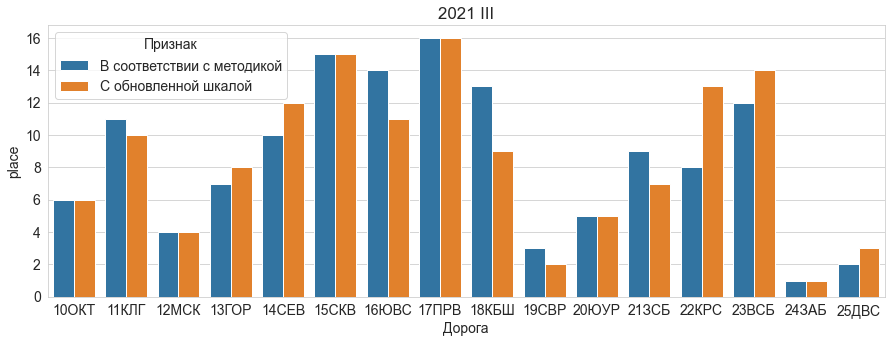

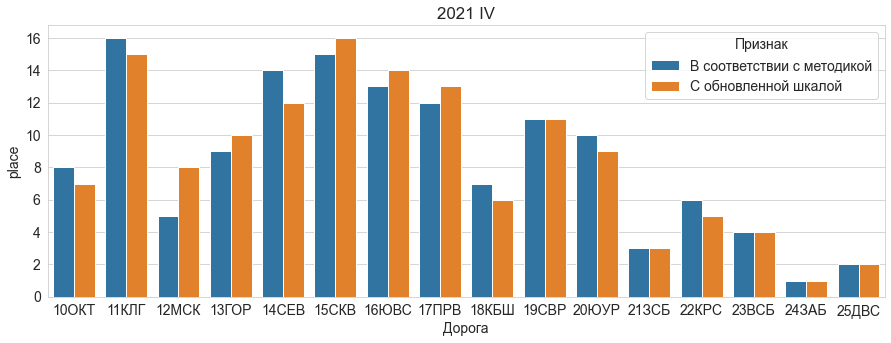

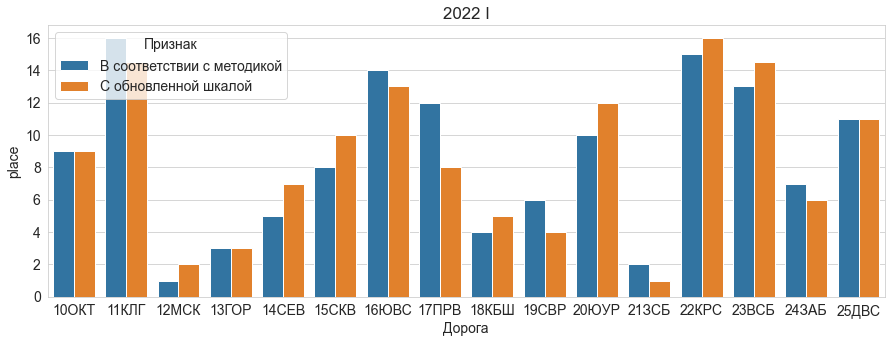

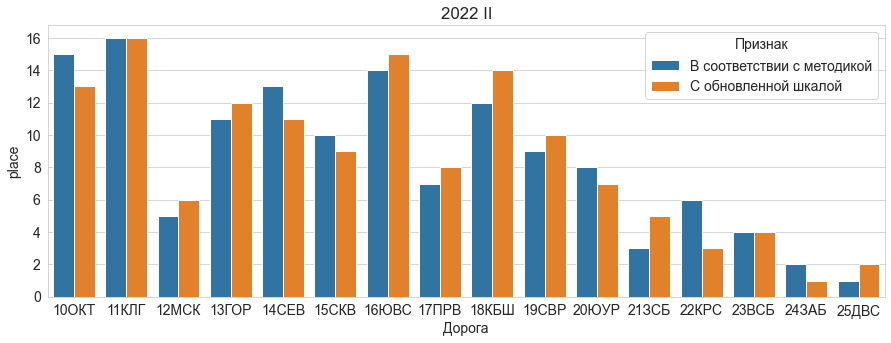

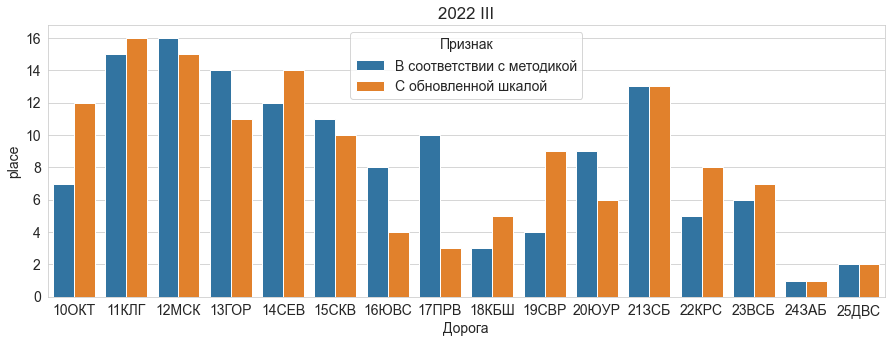

In [74]:
for i in xyz['Период'].unique():
    plt.figure(figsize=(15,5))
    sns.barplot(data=xyz[xyz['Период']==i], x='Дорога', y='place', hue='Признак')
    plt.title(i)


Text(0.5, 1.0, 'Средний рейтинг за 5 кварталов')

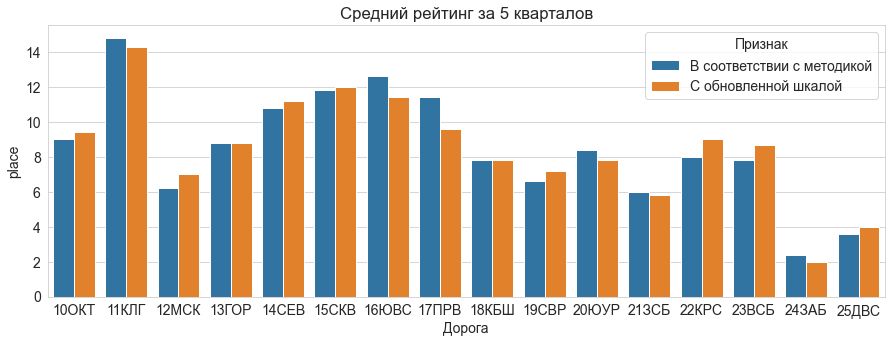

In [75]:
plt.figure(figsize=(15,5))
sns.barplot(data=xyz.groupby(['Дорога','Признак'],as_index=False)['place'].agg('mean'), x='Дорога', y='place', hue='Признак')
plt.title('Средний рейтинг за 5 кварталов')

### Расчет без округления, с рангами от 1 до 16 и стандартизированным выполнением

In [44]:
def ranking3(per, year=0):
    global df1_kvart
    df_r_bir=df1_kvart
    df_r_bir=df_r_bir[df_r_bir[('Период','')]==per]
    for i in k2:
        #положительные в диапазоне 0.95-1.05, остальные - отрицательные
        if i in ['КЗ']:
            if sum(df_r_bir[(i,'Цель')])==sum(df_r_bir[(i,'Факт')]):
                #для нулевых месяцев (январь, февраль)
                df_r_bir.loc[(df_r_bir[(i,'vip_inv')]>=0) & (df_r_bir[(i,'Факт')]==0) & (df_r_bir[(i,'Цель')]==0),
                             (i,'rank')] = 0
                df_r_bir.loc[(df_r_bir[(i,'vip_inv')]>=0) & (df_r_bir[(i,'Факт')]==0) & (df_r_bir[(i,'Цель')]==0),
                             (i,'rank')] = 0
            else:
                #присваиваем баллы показателям в диапазоне
                df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank')] = df_r_bir[
                    (df_r_bir[(i,'vip')]<=0.05)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=False)[(i,'vip')]
                #присваиваем отрицательные ранги
                df_r_bir.loc[(df_r_bir[(i,'vip')]>0.05),(i,'rank')] = - df_r_bir[
                    (df_r_bir[(i,'vip')]>0.05)].groupby(
                        ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]

        #если больше 1 - отрицательные баллы от наименьшего, если меньше - положительные от наименьшего
        elif i in ['Себестоимость']:
            #присваиваем положительные баллы от большего к меньшему для выполнивших цель дорог
            df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank')] = df_r_bir[
                (df_r_bir[(i,'vip')]<=0)].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
            #присваиваем отрицательные баллы
            df_r_bir.loc[(df_r_bir[(i,'vip')]>0),(i,'rank')] = - df_r_bir[
             (df_r_bir[(i,'vip')]>0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
            df_r_bir.loc[(df_r_bir[(i,'Факт')]==0) | (df_r_bir[(i,'Цель')]==0),(i,'rank')] = np.nan

         

        #если x>=1 - среднее арифметическое от присвоенных баллов, если Цель<x<1 - остальные положительные баллы
        #если x<Цель - отрицательные баллы
        elif i in ['УШ']:
            df_r_bir.loc[(df_r_bir[(i,'Факт')]<df_r_bir[(i,'Цель')]),(i,'rank')] = - df_r_bir[
                (df_r_bir[(i,'Факт')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=False)[(i,'vip')]

            df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank')] = df_r_bir[
                (df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
            df_r_bir.loc[(df_r_bir[(i,'Факт')]>100),(i,'rank')] = df_r_bir.loc[(df_r_bir[(i,'Факт')]>100),(i,'rank')].mean()

        #положительные баллы - в первую очередь для тех, кто выполнил первоначальный план, даже при условии не выполнения скорректированного
        #положительные баллы во вторую очередь тем, кто выполнил скорректированный в меньшую сторону план при невыполнении первоначального
        #отрицательные баллы - если не выполнены ни первоначальный, ни скорректированный планы
        elif i in ['Погрузка грузов']:
            #отрицательные баллы
            df_r_bir.loc[(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'vip')]<0),(i,'rank')] = - df_r_bir[
                (df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'vip')]<0)].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=False)[(i,'vip')]
            #если есть отрицательные баллы
     
            df_r_bir.loc[(df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0)
                 & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank')] = df_r_bir[
                    (df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) 
                        & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                            ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]

            #положительные баллы, если выполнены оба плана
            #либо если выполнен только первоначальный, но не выполнен скорректированный (бывает повышают план в таком случае, но считают все равно по первоначальному)
            #если есть отрицательные баллы
            df_r_bir.loc[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))
                     ,(i,'rank')] = df_r_bir[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))].groupby(
            ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+abs(df_r_bir[(i,'rank')]).max()
            df_r_bir[(i,'rank')].update(df_r_bir[(i,'rank0')])

#             df_r_bir[(i,'rank')].update(df_r_bir[(i,'rank')])
#             df_r_bir = df_r_bir.drop((i,'rank0'), axis=1)            
        #положительные - x>=0, иначе отрицательные
    for i in ['gruppk1']:
        #для нулевых месяцев по ДЗ (январь, февраль)
        df_r_bir.loc[:,(i,'rank')] = df_r_bir.groupby(('Месяц/Год',''), as_index=False)[[(i,'vip_full')]].rank(ascending=True)[(i,'vip_full')]
    global df_r_stdnormed
    df_r_stdnormed = df_r_stdnormed.append(df_r_bir)

In [45]:
df_r_stdnormed=pd.DataFrame()
for per in df1_kvart[('Период','')].unique():
    ranking3(per)

In [46]:
df_r_stdnormed.loc[:,('rating','')] = 0
for i in k2+['gruppk1']:
    df_r_stdnormed.loc[:,('rating','')] = df_r_stdnormed.loc[:,('rating','')] + df_r_stdnormed[(i,'rank')] * weight_metr[i]
df_r_stdnormed.sort_index(axis=1)

gruppk1                       rating Вып.расп.пасс.            \
       rank       vip  vip_full                     vip   vip_inv   
80      6.0 -0.003196 -0.018715   5.0750       0.005295  0.005295   
81     16.0 -0.176136  0.689880  14.2875       0.019404  0.019404   
82      7.0 -0.062146  0.007503   6.0500       0.005091  0.005091   
83     12.0  0.053879  0.118042  10.3750       0.006744  0.006744   
84     11.0 -0.100265  0.074248   9.9250       0.009376  0.009376   
..      ...       ...       ...      ...            ...       ...   
507     6.0  0.017488 -0.164720   6.6875       0.010584  0.010584   
508     9.0 -0.239099 -0.070332   9.0875      -0.018014 -0.018014   
509     4.0 -0.208780 -0.263593   4.9625      -0.008839 -0.008839   
510     1.0 -1.892891 -1.015189   2.4000      -0.348398 -0.348398   
511     3.0 -0.325642 -0.323435   4.2500      -0.036773 -0.036773   

                                                                 \
    vip_inv_mean vip_inv_ok_neok vip_inv_ok_ok vip_inv_ok_ok_ok   
80     -0.000727        0.005295         0.005            0.005   
81      0.012657        0.019404         0.019            0.019   
82     -0.002797        0.005091         0.005            0.005   
83      0.002631        0.006744         0.007            0.007   
84      0.007802        0.009376         0.009            0.009   
..           ...             ...           ...              ...   
507     0.009381        0.010584         0.011            0.011   
508    -0.003727       -0.018014        -0.018           -0.018   
509    -0.003276       -0.008839        -0.009           -0.009   
510    -0.158078       -0.348398        -0.348           -0.348   
511    -0.019000       -0.036773        -0.037           -0.037   

                                                                        \
    vip_inv_stand_gr vip_inv_stand_gr_full vip_inv_std vip_inv_std_min   
80          0.311861              0.285312    0.007356        0.002846   
81          0.607009              0.652135    0.005704        0.002846   
82          0.307592              0.259583    0.006625        0.002846   
83          0.342165              0.379056    0.004405        0.002846   
84          0.397225              0.460858    0.006380        0.002846   
..               ...                   ...         ...             ...   
507         0.422498              0.513764    0.002846        0.002846   
508        -0.175725              0.031778    0.008768        0.002846   
509         0.016210              0.084874    0.005276        0.002846   
510        -7.086888             -3.892970    0.118348        0.002846   
511        -0.568135             -0.334627    0.013421        0.002846   

                                                                          \
    vip_inv_stdnormed vip_ok_neok vip_ok_ok vip_ok_ok_ok    Факт Факт_ok   
80           0.001603    0.005295     0.005        0.005  98.539  98.539   
81           0.016023    0.019404     0.019        0.019  99.922  99.922   
82           0.000591    0.005091     0.005        0.005  98.519  98.519   
83           0.005288    0.006744     0.007        0.007  98.681  98.681   
84           0.008504    0.009376     0.009        0.009  98.939  98.939   
..                ...         ...       ...          ...     ...     ...   
507          0.010584    0.010584     0.011        0.011  99.017  99.017   
508         -0.008364   -0.018014    -0.018       -0.018  96.215  96.215   
509         -0.006277   -0.008839    -0.009       -0.009  97.114  97.114   
510         -0.162655   -0.348398    -0.348       -0.348  63.844  63.844   
511         -0.022768   -0.036773    -0.037       -0.037  94.377  94.377   

                   Вып.расп.приг.                                         \
      Цель Цель_ok            vip   vip_inv vip_inv_mean vip_inv_ok_neok   
80   98.02   98.02       0.003270  0.003270     0.004039        0.003270   
81   98.02   98.02       0.012452  0.012452     0.0138

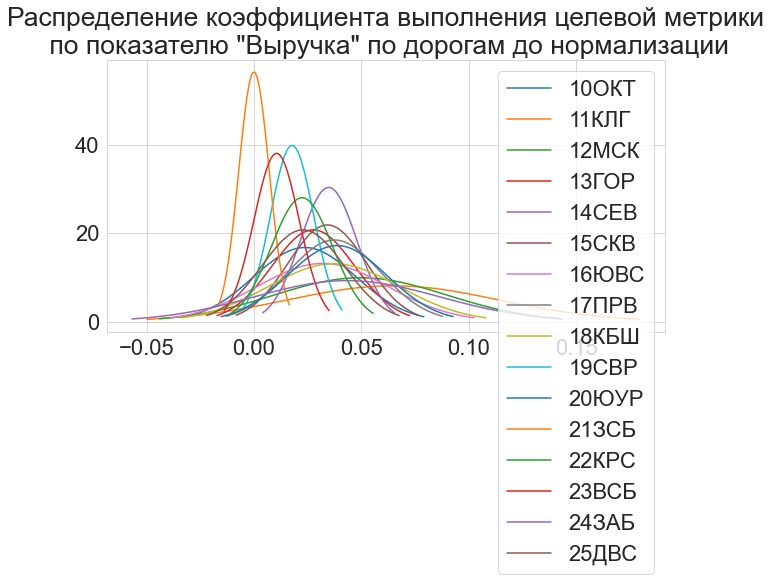

In [47]:
for i in ['Выручка']:
    plt.figure(figsize=(10,5))
    for j in df_r_stdnormed["Дорога"].unique():
        dff=df_r_stdnormed[df_r_stdnormed[("Дорога",'')]==j][(i,'vip_inv')]
        x = np.linspace(norm.ppf(0.01,dff.mean(),dff.std()),
                        norm.ppf(0.99, dff.mean(),dff.std()), 100)
        #        print (f'{min(x):.3f} - минимальное значение, {max(x):.3f} - максимальное значение, среднее значение - {dff.mean():.3f} по дороге {j}')
        sns.lineplot(x=x,y=norm.pdf(x,dff.mean(),dff.std()), label = j)
    plt.title('Распределение коэффициента выполнения целевой метрики\n по показателю "Выручка" по дорогам до нормализации')
#        plt.axvline(dff.mean())

In [ ]:
df_r_stdnormed.sort_index(axis=1)
for i in ['Выручка']:
    plt.figure(figsize=(10, 5))
    for j in df_r_stdnormed["Дорога"].unique():
        dff = df_r_stdnormed[df_r_stdnormed[("Дорога", '')] == j][(i, 'vip_inv_stdnormed')]
        x = np.linspace(norm.ppf(0.01, dff.mean(), dff.std()),
                        norm.ppf(0.99, dff.mean(), dff.std()), 100)
        #        print (f'{min(x):.3f} - минимальное значение, {max(x):.3f} - максимальное значение, среднее значение - {dff.mean():.3f} по дороге {j}')
        sns.lineplot(x=x, y=norm.pdf(x, dff.mean(), dff.std()), label=j)
        plt.title('Распределение коэффициента выполнения целевой метрики\n по показателю "Выручка" по дорогам после нормализации')

### Работа с ПФБ

In [80]:
pfb=pd.read_pickle(r'/Users/mihailvardanasvili/Downloads/pfb_pr.pkl')

pfb = pfb[(pfb['r_road']!='Инфраструктура ОАО "РЖД"') & (pfb['year']>=2019)]
#pfb2['year2'] = pfb2['year']
#pfb2['year'] = pfb2['year']-2019

pfb['year2'] = pfb['year']
pfb['year'] = pfb['year']-2018

In [81]:
pfb=pfb.sort_values(['r_road', 'year'])

In [82]:
#pfb2 = pfb2.replace({'r_road':{"ОКТ":"10ОКТ","КЛГ":"11КЛГ","МСК":"12МСК","ГОР":"13ГОР","СЕВ":"14СЕВ","СКВ":"15СКВ","ЮВС":"16ЮВС","ПРВ":"17ПРВ","КБШ":"18КБШ","СВР":"19СВР","ЮУР":"20ЮУР","ЗСБ":"21ЗСБ","КРС":"22КРС","ВСБ":"23ВСБ","ЗАБ":"24ЗАБ","ДВС":"25ДВС"}})
pfb = pfb.replace({'r_road':{"ОКТ":"10ОКТ","КЛГ":"11КЛГ","МСК":"12МСК","ГРК":"13ГОР","СЕВ":"14СЕВ","СКВ":"15СКВ","ЮВСТ":"16ЮВС","ПРВ":"17ПРВ","КБШ":"18КБШ","СВРД":"19СВР","ЮУР":"20ЮУР","ЗСБ":"21ЗСБ","КРС":"22КРС","ВСБ":"23ВСБ","ЗАБ":"24ЗАБ","ДВС":"25ДВС"}})

In [83]:
def f(x, y_max, y_min):
    a=((y_max-y_min)/(1-1/12))
    b=y_max-a/1
    return (a/x+b)

In [84]:
#y_min = 8.18
for i in list(pfb['r_road'].unique()):
 #   y_min = float(pfb[(pfb['r_road']==i) & (pfb['year2']==2030)]['basic'].values)
    y_max= float(pfb[(pfb['r_road']==i) & (pfb['year2']==2019)]['basic'].values)
    y_min = (y_max - 14.7) / y_max * 8.18 /2 + 8.18
    y2= f(pfb[pfb['r_road']==i]['year'], y_max, y_min)
    pfb.loc[(pfb['r_road']==i),'modif'] = pfb[pfb['r_road']==i]['year'].apply(lambda x: f(x, y_max, y_min))
import matplotlib.colors as mcolors

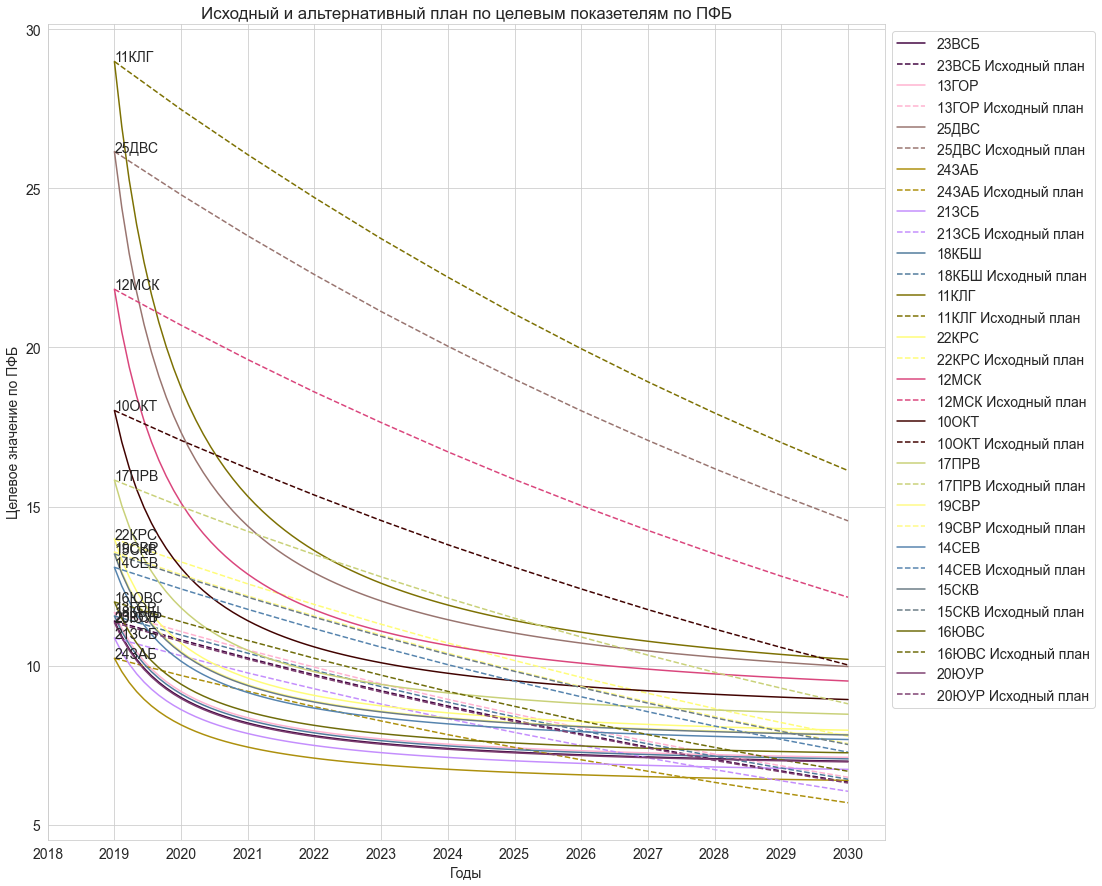

In [85]:

x=np.linspace(1,12,100)
plt.figure(figsize=(15,15))
#y_min = 8.18

for i, col in zip(list(pfb['r_road'].unique()),list(mcolors.XKCD_COLORS.values())[50:66]):
    y_max= float(pfb[(pfb['r_road']==i) & (pfb['year2']==2019)]['basic'].values)
 #   y_min = float(pfb[(pfb['r_road']==i) & (pfb['year2']==2030)]['basic'].values)
    y_min = (y_max - 14.7) / y_max * 8.18 /2 + 8.18
#    print(y_max)
    y = f(x, y_max, y_min)
  #  y2= f(pfb[pfb['r_road']==i]['basic'], y_max, y_min)
   # pfb.loc[pfb['r_road']==i,'modif'] = y2
    sns.lineplot(x=x, y=y, label = i, color=col)
    sns.lineplot(data = pfb[(pfb['r_road']==i)], x='year', y='basic', label = i +' Исходный план', linestyle='--', color=col)
    plt.grid()
    plt.title('Исходный и альтернативный план по целевым показетелям по ПФБ')
    plt.xlabel('Годы')
    plt.ylabel('Целевое значение по ПФБ')
    plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12],labels=[2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030])
    plt.legend( bbox_to_anchor=(1,1))
for i in pfb['r_road'].unique():
    plt.annotate(i, xy=(1, pfb[(pfb['year']==1) & (pfb['r_road']==i) ]['basic']))

In [86]:
df1_kvart2 = df1_kvart.merge(pfb.rename({'year2':('Год',''),'r_road':('Дорога',''),'basic':('basic',''),'modif':('modif','')}, axis=1)[[('Дорога',''),('Год',''),('basic',''),('modif','')]], on=[('Дорога',''),('Год','')])

In [87]:
df1_kvart2

Вып.расп.пасс.                                                           \
              vip   vip_inv vip_inv_ok_neok vip_inv_ok_ok vip_inv_ok_ok_ok   
0        0.005295  0.005295        0.005295         0.005            0.005   
1       -0.008000 -0.008000       -0.008000        -0.008           -0.008   
2       -0.008901 -0.008901       -0.008901        -0.009           -0.009   
3        0.006818  0.006818        0.006818         0.007            0.007   
4        0.001153  0.001153        0.001153         0.001            0.001   
..            ...       ...             ...           ...              ...   
75      -0.004448 -0.004448       -0.004448        -0.004           -0.004   
76      -0.029063 -0.029063       -0.029063        -0.029           -0.029   
77      -0.011058 -0.011058       -0.011058        -0.011           -0.011   
78      -0.013656 -0.013656       -0.013656        -0.014           -0.014   
79      -0.036773 -0.036773       -0.036773        -0.037           -0.037   

                                                                      \
   vip_ok_neok vip_ok_ok vip_ok_ok_ok    Факт Факт_ok   Цель Цель_ok   
0     0.005295     0.005        0.005  98.539  98.539  98.02   98.02   
1    -0.008000    -0.008       -0.008  97.960  97.960  98.75   98.75   
2    -0.008901    -0.009       -0.009  97.871  97.871  98.75   98.75   
3     0.006818     0.007        0.007  98.648  98.648  97.98   97.98   
4     0.001153     0.001        0.001  98.093  98.093  97.98   97.98   
..         ...       ...          ...     ...     ...    ...     ...   
75   -0.004448    -0.004       -0.004  97.584  97.584  98.02   98.02   
76   -0.029063    -0.029       -0.029  95.880  95.880  98.75   98.75   
77   -0.011058    -0.011       -0.011  97.658  97.658  98.75   98.75   
78   -0.013656    -0.014       -0.014  96.642  96.642  97.98   97.98   
79   -0.036773    -0.037       -0.037  94.377  94.377  97.98   97.98   

   Вып.расп.приг.                                                           \
              vip   vip_inv vip_inv_ok_neok vip_inv_ok_ok vip_inv_ok_ok_ok   
0        0.003270  0.003270        0.003270         0.003            0.003   
1       -0.001525 -0.001525       -0.001525        -0.002           -0.002   
2        0.003110  0.003110        0.003110         0.003            0.003   
3        0.008122  0.008122        0.008122         0.008            0.008   
4        0.007217  0.007217        0.007217         0.007            0.007   
..            ...       ...             ...           ...              ...   
75       0.001848  0.001848        0.001848         0.002            0.002   
76      -0.027239 -0.027239       -0.027239        -0.027           -0.027   
77      -0.019158 -0.019158       -0.019158        -0.019           -0.019   
78      -0.001880 -0.001880       -0.001880        -0.002           -0.002   
79      -0.008650 -0.008650       -0.008650        -0.009           -0.009   

                                                                      \
   vip_ok_neok vip_ok_ok vip_ok_ok_ok    Факт Факт_ok   Цель Цель_ok   
0     0.003270     0.003        0.003  98.782  98.782  98.46   98.46   
1    -0.001525    -0.002       -0.002  98.240  98.240  98.39   98.39   
2     0.003110     0.003        0.003  98.696  98.696  98.39   98.39   
3     0.008122     0.008        0.008  99.179  99.179  98.38   98.38   
4     0.007217     0.007        0.007  99.090  99.090  98.38   98.38   
..         ...       ...          ...     ...     ...    ...     ...   
75    0.001848     0.002        0.002  98.642  98.642  98.46   98.46   
76   -0.027239    -0.027       -0.027  95.710  95.710  98.39   98.39   
77   -0.019158    -0.019       -0.019  96.505  96.505  98.39   98.39   
78   -0.001880    -0.002       -0.002  98.195  98.195  98.38   98.38   
79   -0.008650    -0.009       -0.009  97.529  97.529  98.38   98.38   

     Выручка                                                           \
         vip   vip_inv vip

In [88]:
df1_kvart2[('ПФБ','Цель_мод')] = df1_kvart2[('ПФБ','Цель')] * df1_kvart2[('modif','')] / df1_kvart2[('basic','')]
df1_kvart2 = df1_kvart2.sort_index(axis=1)
df1_kvart2.loc[:,('ПФБ','vip')] = df1_kvart2.loc[:,('ПФБ','Факт')] / df1_kvart2.loc[:,('ПФБ','Цель_мод')] - 1

### Расчет с учетом новой шкалы и группировки показателей

In [89]:
k1=[i for i in k if i not in ['КЗ','УШ','Себестоимость','Погрузка грузов']]

In [90]:
k2=[i for i in k if i not in k1]

In [91]:
type_metr = {'Вып.расп.пасс.': 1,
 'Доля': 1,
 'Вып.расп.приг.': 1,
 'КЗ': 1, #отдельное условие в приложении
 'ДЗ': -1,
 'Выручка': 1,
 'Себестоимость': -1,
 'Кач. балл. оц.': 1,
 'Уч. скорость': 1,
 'Пр.ЭП': 1,
 'Погрузка грузов': 1,
 'Фин. рез. ПВД': 1,
 'Уд. время задержки': -1,
 'УШ': 1,
 'ПФБ': - 1,
 'gruppk1': 1            }
weight_metr = {'Вып.расп.пасс.': .05,
 'Доля': .05,
 'Вып.расп.приг.': .05,
 'КЗ': .025,
 'ДЗ': .025,
 'Выручка': .1,
 'Себестоимость': .1,
 'Кач. балл. оц.': .05,
 'Уч. скорость': .025,
 'Пр.ЭП': .05,
 'Погрузка грузов': .1,
 'Фин. рез. ПВД': .05,
 'Уд. время задержки': .05,
 'УШ': .025,
 'ПФБ': .25,
 'gruppk1': .75             }

In [92]:
for i in k1:
    df1_kvart2.loc[:,(i,'vip_inv')] = df1_kvart2.loc[:,(i,'vip')] * type_metr[i]
df1_kvart2.loc[:,('ПФБ','vip_inv')] = df1_kvart2.loc[:,('ПФБ','vip')] * type_metr[i]

In [93]:
for i in k1:
    if i=='ПФБ':
        cel='Цель'
    else:
        cel='Цель'
    df1_kvart2 [(i,'otkl')] = df1_kvart2[(i,'Факт')] - df1_kvart2[(i,cel)]
    df1_kvart2[(i,'upper_bor')] = df1_kvart2.groupby(('Дорога',''),as_index=False)[[(i,'otkl')]].transform(lambda x: x[df1_kvart2[(i,'otkl')]>0].median())[(i,'otkl')] + df1_kvart2[(i, cel)]
    df1_kvart2.loc[df1_kvart2[(i,'upper_bor')].isna(),(i,'upper_bor')] = df1_kvart2[df1_kvart2[(i,'upper_bor')].isna()][(i,cel)]
    df1_kvart2[(i,'lower_bor')]= df1_kvart2.groupby(('Дорога',''),as_index=False)[[(i,'otkl')]].transform(lambda x: x[df1_kvart2[(i,'otkl')]<=0].median())[(i,'otkl')] + df1_kvart2[(i,cel)]
    df1_kvart2.loc[df1_kvart2[(i,'lower_bor')].isna(),(i,'lower_bor')] = df1_kvart2[df1_kvart2[(i,'lower_bor')].isna()][(i,cel)]
df1_kvart2.sort_index(axis=1)


basic      modif Вып.расп.пасс.                                       \
                          lower_bor   otkl upper_bor       vip   vip_inv   
0   16.20  11.411666        97.1855  0.519    98.539  0.005295  0.005295   
1   16.20  11.411666        97.9155 -0.790    99.269 -0.008000 -0.008000   
2   15.36  10.585624        97.9155 -0.879    99.269 -0.008901 -0.008901   
3   15.36  10.585624        97.1455  0.668    98.499  0.006818  0.006818   
4   15.36  10.585624        97.1455  0.113    98.499  0.001153  0.001153   
..    ...        ...            ...    ...       ...       ...       ...   
75  23.51  14.386706        96.6820 -0.436    98.020 -0.004448 -0.004448   
76  23.51  14.386706        97.4120 -2.870    98.750 -0.029063 -0.029063   
77  22.29  12.915044        97.4120 -1.092    98.750 -0.011058 -0.011058   
78  22.29  12.915044        96.6420 -1.338    97.980 -0.013656 -0.013656   
79  22.29  12.915044        96.6420 -3.603    97.980 -0.036773 -0.036773   

                                                                         \
   vip_inv_ok_neok vip_inv_ok_ok vip_inv_ok_ok_ok vip_ok_neok vip_ok_ok   
0         0.005295         0.005            0.005    0.005295     0.005   
1        -0.008000        -0.008           -0.008   -0.008000    -0.008   
2        -0.008901        -0.009           -0.009   -0.008901    -0.009   
3         0.006818         0.007            0.007    0.006818     0.007   
4         0.001153         0.001            0.001    0.001153     0.001   
..             ...           ...              ...         ...       ...   
75       -0.004448        -0.004           -0.004   -0.004448    -0.004   
76       -0.029063        -0.029           -0.029   -0.029063    -0.029   
77       -0.011058        -0.011           -0.011   -0.011058    -0.011   
78       -0.013656        -0.014           -0.014   -0.013656    -0.014   
79       -0.036773        -0.037           -0.037   -0.036773    -0.037   

                                               Вып.расп.приг.         \
   vip_ok_ok_ok    Факт Факт_ok   Цель Цель_ok      lower_bor   otkl   
0         0.005  98.539  98.539  98.02   98.02         98.310  0.322   
1        -0.008  97.960  97.960  98.75   98.75         98.240 -0.150   
2        -0.009  97.871  97.871  98.75   98.75         98.240  0.306   
3         0.007  98.648  98.648  97.98   97.98         98.230  0.799   
4         0.001  98.093  98.093  97.98   97.98         98.230  0.710   
..          ...     ...     ...    ...     ...            ...    ...   
75       -0.004  97.584  97.584  98.02   98.02         97.092  0.182   
76       -0.029  95.880  95.880  98.75   98.75         97.022 -2.680   
77       -0.011  97.658  97.658  98.75   98.75         97.022 -1.885   
78       -0.014  96.642  96.642  97.98   97.98         97.012 -0.185   
79       -0.037  94.377  94.377  97.98   97.98         97.012 -0.851   

                                                                \
   upper_bor       vip   vip_inv vip_inv_ok_neok vip_inv_ok_ok   
0     98.976  0.003270  0.003270        0.003270         0.003   
1     98.906 -0.001525 -0.001525       -0.001525        -0.002   
2     98.906  0.003110  0.003110        0.003110         0.003   
3     98.896  0.008122  0.008122        0.008122         0.008   
4     98.896  0.007217  0.007217        0.007217         0.007   
..       ...       ...       ...             ...           ...   
75    98.642  0.001848  0.001848        0.001848         0.002   
76    98.572 -0.027239 -0.027239       -0.027239        -0.027   
77    98.572 -0.019158 -0.019158       -0.019158        -0.019   
78    98.562 -0.001880 -0.001880       -0.001880        -0.002   
79    98.562 -0.008650 -0.008650       -0.008650        -0.009   

                                                                               \
   vip_inv_ok_ok_ok vip_ok_neok vip_ok_ok vip_ok_ok_ok    Факт Факт_ok   Цель   
0             0.003    0.003270     0.003        0.003  98.782  98.782  98.46   


In [94]:
df1_kvart2[[('gruppk1','vip_inv'), ('gruppk1','vip_full'), ('gruppk1','zeros'), ('gruppk1','Цель'), ('gruppk1','Факт')]] = 0
for i in k1:
    if i=='ПФБ':
        cel='Цель'
    else:
        cel='Цель'
    df1_kvart2[[(i,'vip_inv_mean'),(i,'vip_inv_std')]]=None
    df1_kvart2[[(i,'vip_inv_mean')]] = df1_kvart2.loc[:,[(i,'vip_inv'),('Дорога','')]].groupby(('Дорога',''), as_index=False)[[(i,'vip_inv')]].transform('mean')
    df1_kvart2[[(i,'vip_inv_std')]] = df1_kvart2.loc[:,[(i,'vip_inv'),('Дорога','')]].groupby(('Дорога',''), as_index=False)[[(i,'vip_inv')]].transform('std')
    df1_kvart2[[(i,'vip_inv_std_min')]] = df1_kvart2[(i,'vip_inv_std')].min()
    df1_kvart2[(i,'vip_inv_stdnormed')] = df1_kvart2[(i,'vip_inv_mean')] + (df1_kvart2[(i,'vip_inv')] - df1_kvart2[(i,'vip_inv_mean')]) * df1_kvart2[(i,'vip_inv_std_min')] / df1_kvart2[(i,'vip_inv_std')]
    df1_kvart2[(i,'vip_inv_stand_gr_full')] = (df1_kvart2[(i,'vip_inv_stdnormed')] - df1_kvart2[(i,'vip_inv_stdnormed')].mean()) / df1_kvart2[(i,'vip_inv_stdnormed')].std()
    df1_kvart2.loc[:,(i,'vip_inv_stand_gr')] = (df1_kvart2[(i,'vip_inv')] - df1_kvart2[(i,'vip_inv')].mean()) / df1_kvart2[(i,'vip_inv')].std()

    df1_kvart2.loc[:,('gruppk1','vip_full')] = df1_kvart2.loc[:,('gruppk1','vip_full')] + df1_kvart2[(i,'vip_inv_stand_gr_full')] * weight_metr[i]
    df1_kvart2.loc[:,('gruppk1','vip_inv')] = df1_kvart2.loc[:,('gruppk1','vip_inv')] + df1_kvart2[(i,'vip_inv_stand_gr')] * weight_metr[i]

    df1_kvart2.loc[:,(i,'zeros_stand_gr')] = (0 - df1_kvart2[(i,'vip_inv')].mean()) / df1_kvart2[(i,'vip_inv')].std()
    df1_kvart2.loc[:,('gruppk1','zeros')] = df1_kvart2.loc[:,('gruppk1','zeros')] + df1_kvart2[(i,'zeros_stand_gr')] * weight_metr[i] * type_metr[i]

    df1_kvart2.loc[:,(i,'fact_stand_gr')] = (df1_kvart2[(i,'Факт')] - pd.concat([df1_kvart2[(i,'Факт')],df1_kvart2[(i,cel)]], axis=0).mean()) / pd.concat([df1_kvart2[(i,'Факт')],df1_kvart2[(i,cel)]], axis=0).std()
    df1_kvart2.loc[:,('gruppk1','Факт')] = df1_kvart2.loc[:,('gruppk1','Факт')] + df1_kvart2[(i,'fact_stand_gr')] * weight_metr[i] * type_metr[i]

    df1_kvart2.loc[:,(i,'cel_stand_gr')] = (df1_kvart2[(i,cel)] - pd.concat([df1_kvart2[(i,'Факт')],df1_kvart2[(i,cel)]], axis=0).mean()) / pd.concat([df1_kvart2[(i,'Факт')],df1_kvart2[(i,cel)]], axis=0).std()
    df1_kvart2.loc[:,('gruppk1','Цель')] = df1_kvart2.loc[:,('gruppk1','Цель')] + df1_kvart2[(i,'cel_stand_gr')] * weight_metr[i] * type_metr[i]


df1_kvart2.sort_index(axis=1)

basic   gruppk1                                              modif  \
           vip_full   vip_inv     zeros      Факт      Цель              
0   16.20 -0.198801 -0.142247  0.013231  0.173376 -0.009885  11.411666   
1   16.20 -0.159522 -0.107003  0.013231  0.057837 -0.045408  11.411666   
2   15.36 -0.119204 -0.103563  0.013231  0.040202 -0.072905  10.585624   
3   15.36 -0.116536  0.033362  0.013231  0.214734 -0.016929  10.585624   
4   15.36 -0.034893  0.115167  0.013231 -0.022923  0.046310  10.585624   
..    ...       ...       ...       ...       ...       ...        ...   
75  23.51  0.111903  0.206200  0.013231 -0.467831 -0.386140  14.386706   
76  23.51 -0.132971 -0.362657  0.013231 -0.241726 -0.396273  14.386706   
77  22.29  0.022311 -0.115138  0.013231 -0.240037 -0.651573  12.915044   
78  22.29  0.030718  0.036843  0.013231 -0.382667 -0.349550  12.915044   
79  22.29  0.057033  0.110269  0.013231 -0.782314 -0.360280  12.915044   

   Вып.расп.пасс.                                                     \
     cel_stand_gr fact_stand_gr lower_bor   otkl upper_bor       vip   
0        0.058151      0.212102   97.1855  0.519    98.539  0.005295   
1        0.274691      0.040353   97.9155 -0.790    99.269 -0.008000   
2        0.274691      0.013953   97.9155 -0.879    99.269 -0.008901   
3        0.046286      0.244435   97.1455  0.668    98.499  0.006818   
4        0.046286      0.079805   97.1455  0.113    98.499  0.001153   
..            ...           ...       ...    ...       ...       ...   
75       0.058151     -0.071180   96.6820 -0.436    98.020 -0.004448   
76       0.274691     -0.576639   97.4120 -2.870    98.750 -0.029063   
77       0.274691     -0.049230   97.4120 -1.092    98.750 -0.011058   
78       0.046286     -0.350607   96.6420 -1.338    97.980 -0.013656   
79       0.046286     -1.022475   96.6420 -3.603    97.980 -0.036773   

                                                                          \
     vip_inv vip_inv_mean vip_inv_ok_neok vip_inv_ok_ok vip_inv_ok_ok_ok   
0   0.005295    -0.000727        0.005295         0.005            0.005   
1  -0.008000    -0.000727       -0.008000        -0.008           -0.008   
2  -0.008901    -0.000727       -0.008901        -0.009           -0.009   
3   0.006818    -0.000727        0.006818         0.007            0.007   
4   0.001153    -0.000727        0.001153         0.001            0.001   
..       ...          ...             ...           ...              ...   
75 -0.004448    -0.019000       -0.004448        -0.004           -0.004   
76 -0.029063    -0.019000       -0.029063        -0.029           -0.029   
77 -0.011058    -0.019000       -0.011058        -0.011           -0.011   
78 -0.013656    -0.019000       -0.013656        -0.014           -0.014   
79 -0.036773    -0.019000       -0.036773        -0.037           -0.037   

                                                                       \
   vip_inv_stand_gr vip_inv_stand_gr_full vip_inv_std vip_inv_std_min   
0          0.311861              0.285312    0.007356        0.002846   
1          0.033751              0.154468    0.007356        0.002846   
2          0.014898              0.145598    0.007356        0.002846   
3          0.343717              0.300299    0.007356        0.002846   
4          0.225225              0.244552    0.007356        0.002846   
..              ...                   ...         ...             ...   
75         0.108053             -0.160269    0.013421        0.002846   
76        -0.406863             -0.293042    0.013421        0.002846   
77        -0.030222             -0.195924    0.013421        0.002846   
78        -0.084561             -0.209935    0.013421        0.002846   
79        -0.568135             -0.334627    0.013421        0.002846   

                                                                        \
   vip_inv_stdnormed vip_ok_neok vip_ok_ok vip_ok_ok_ok zeros_stand_gr   
0       1.602799e

In [95]:
for i in ['gruppk1']:
    df1_kvart2 [(i,'otkl')] = df1_kvart2[(i,'Факт')] - df1_kvart2[(i, 'Цель')]
    df1_kvart2[(i,'upper_bor')] = df1_kvart2.groupby(('Дорога',''),as_index=False)[[(i,'otkl')]].transform(lambda x: x[df1_kvart2[(i,'otkl')]>0].median())[(i,'otkl')] + df1_kvart2[(i, 'Цель')]
    df1_kvart2.loc[df1_kvart2[(i,'upper_bor')].isna(),(i,'upper_bor')] = df1_kvart2[df1_kvart2[(i,'upper_bor')].isna()][(i,'Цель')]

    df1_kvart2[(i,'lower_bor')]= df1_kvart2.groupby(('Дорога',''),as_index=False)[[(i,'otkl')]].transform(lambda x: x[df1_kvart2[(i,'otkl')]<=0].median())[(i,'otkl')] + df1_kvart2[(i,'Цель')]
    df1_kvart2.loc[df1_kvart2[(i,'lower_bor')].isna(),(i,'lower_bor')] = df1_kvart2[df1_kvart2[(i,'lower_bor')].isna()][(i,'Цель')]

#    df1_kvart2.loc[:,(i,'vip_inv')] = df1_kvart2.loc[:,(i,'Факт')] / df1_kvart2.loc[:,(i,'Цель')] - 1


df1_kvart2.sort_index(axis=1)


basic   gruppk1                                                    \
          lower_bor      otkl upper_bor  vip_full   vip_inv     zeros   
0   16.20 -0.079118  0.183261  0.138299 -0.198801 -0.142247  0.013231   
1   16.20 -0.114641  0.103245  0.102776 -0.159522 -0.107003  0.013231   
2   15.36 -0.142138  0.113107  0.075279 -0.119204 -0.103563  0.013231   
3   15.36 -0.086162  0.231662  0.131255 -0.116536  0.033362  0.013231   
4   15.36 -0.022923 -0.069233  0.194493 -0.034893  0.115167  0.013231   
..    ...       ...       ...       ...       ...       ...       ...   
75  23.51 -0.467831 -0.081690 -0.103099  0.111903  0.206200  0.013231   
76  23.51 -0.477964  0.154548 -0.113232 -0.132971 -0.362657  0.013231   
77  22.29 -0.733263  0.411536 -0.368531  0.022311 -0.115138  0.013231   
78  22.29 -0.431241 -0.033117 -0.066509  0.030718  0.036843  0.013231   
79  22.29 -0.441970 -0.422034 -0.077238  0.057033  0.110269  0.013231   

                            modif Вып.расп.пасс.                          \
        Факт      Цель              cel_stand_gr fact_stand_gr lower_bor   
0   0.173376 -0.009885  11.411666       0.058151      0.212102   97.1855   
1   0.057837 -0.045408  11.411666       0.274691      0.040353   97.9155   
2   0.040202 -0.072905  10.585624       0.274691      0.013953   97.9155   
3   0.214734 -0.016929  10.585624       0.046286      0.244435   97.1455   
4  -0.022923  0.046310  10.585624       0.046286      0.079805   97.1455   
..       ...       ...        ...            ...           ...       ...   
75 -0.467831 -0.386140  14.386706       0.058151     -0.071180   96.6820   
76 -0.241726 -0.396273  14.386706       0.274691     -0.576639   97.4120   
77 -0.240037 -0.651573  12.915044       0.274691     -0.049230   97.4120   
78 -0.382667 -0.349550  12.915044       0.046286     -0.350607   96.6420   
79 -0.782314 -0.360280  12.915044       0.046286     -1.022475   96.6420   

                                                                      \
     otkl upper_bor       vip   vip_inv vip_inv_mean vip_inv_ok_neok   
0   0.519    98.539  0.005295  0.005295    -0.000727        0.005295   
1  -0.790    99.269 -0.008000 -0.008000    -0.000727       -0.008000   
2  -0.879    99.269 -0.008901 -0.008901    -0.000727       -0.008901   
3   0.668    98.499  0.006818  0.006818    -0.000727        0.006818   
4   0.113    98.499  0.001153  0.001153    -0.000727        0.001153   
..    ...       ...       ...       ...          ...             ...   
75 -0.436    98.020 -0.004448 -0.004448    -0.019000       -0.004448   
76 -2.870    98.750 -0.029063 -0.029063    -0.019000       -0.029063   
77 -1.092    98.750 -0.011058 -0.011058    -0.019000       -0.011058   
78 -1.338    97.980 -0.013656 -0.013656    -0.019000       -0.013656   
79 -3.603    97.980 -0.036773 -0.036773    -0.019000       -0.036773   

                                                                          \
   vip_inv_ok_ok vip_inv_ok_ok_ok vip_inv_stand_gr vip_inv_stand_gr_full   
0          0.005            0.005         0.311861              0.285312   
1         -0.008           -0.008         0.033751              0.154468   
2         -0.009           -0.009         0.014898              0.145598   
3          0.007            0.007         0.343717              0.300299   
4          0.001            0.001         0.225225              0.244552   
..           ...              ...              ...                   ...   
75        -0.004           -0.004         0.108053             -0.160269   
76        -0.029           -0.029        -0.406863             -0.293042   
77        -0.011           -0.011        -0.030222             -0.195924   
78        -0.014           -0.014        -0.084561             -0.209935   
79        -0.037           -0.037        -0.568135             -0.334627   

                                                                        \
   vip_inv_std vip_inv_std_min vip_inv_stdnormed vip_ok_neok vip_

In [96]:
def ranking4(per, year=0):
    global df1_kvart2
    df_r_bir = df1_kvart2
    df_r_bir = df_r_bir[df_r_bir[('Период', '')] == per]
    for i in k2:
        #положительные в диапазоне 0.95-1.05, остальные - отрицательные
        if i in ['КЗ']:
            if sum(df_r_bir[(i,'Цель')])==sum(df_r_bir[(i,'Факт')]):
                #для нулевых месяцев (январь, февраль)
                df_r_bir.loc[(df_r_bir[(i,'vip_inv')]>=0) & (df_r_bir[(i,'Факт')]==0) & (df_r_bir[(i,'Цель')]==0),(i,'rank0')] = 0
                df_r_bir.loc[(df_r_bir[(i,'vip_inv')]>=0) & (df_r_bir[(i,'Факт')]==0) & (df_r_bir[(i,'Цель')]==0),(i,'rank')] = 0
            else:
                #присваиваем баллы показателям в диапазоне
                df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank0')] = df_r_bir[
                    (df_r_bir[(i,'vip')]<=0.05)].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=False)[(i,'vip')]
                #присваиваем отрицательные ранги
                df_r_bir.loc[(df_r_bir[(i,'vip')]>0.05),(i,'rank')] = - df_r_bir[
                    (df_r_bir[(i,'vip')]>0.05)].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
                if len(df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank0')])==16:
                    df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank')] =  df_r_bir.loc[
                        (df_r_bir[(i,'vip')]<=0.05),(i,'rank0')]
                else:
                    df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank')] =  df_r_bir.loc[
                                                                                (df_r_bir[(i,'vip')]<=0.05),(i,'rank0')]-df_r_bir.loc[(df_r_bir[(i,'vip')]>0.05),(i,'rank')].min()

        #если больше 1 - отрицательные баллы от наименьшего, если меньше - положительные от наименьшего
        elif i in ['Себестоимость']:
            #присваиваем положительные баллы от большего к меньшему для выполнивших цель дорог
            df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank0')] = df_r_bir[
                (df_r_bir[(i,'vip')]<=0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
            #присваиваем отрицательные баллы
            df_r_bir.loc[(df_r_bir[(i,'vip')]>0),(i,'rank')] = - df_r_bir[
                (df_r_bir[(i,'vip')]>0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
            df_r_bir.loc[(df_r_bir[(i,'Факт')]==0) | (df_r_bir[(i,'Цель')]==0),(i,'rank')] = np.nan

            if len(df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank0')])==16:
                df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank')] =  df_r_bir.loc[
                    (df_r_bir[(i,'vip')]<=0),(i,'rank0')]
            else:
                df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank')] =  df_r_bir.loc[
                                                                         (df_r_bir[(i,'vip')]<=0),(i,'rank0')]-df_r_bir.loc[(df_r_bir[(i,'vip')]>0),(i,'rank')].min()

        #если x>=1 - среднее арифметическое от присвоенных баллов, если Цель<x<1 - остальные положительные баллы
        #если x<Цель - отрицательные баллы
        elif i in ['УШ']:
            df_r_bir.loc[(df_r_bir[(i,'Факт')]<df_r_bir[(i,'Цель')]),(i,'rank')] = - df_r_bir[
                (df_r_bir[(i,'Факт')]<df_r_bir[(i,'Цель')])].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=False)[(i,'vip')]

            df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                (df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')])].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]

            if len(df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')])==16:
                df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank')] =  df_r_bir.loc[
                    (df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')]
            else:
                df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank')] =  df_r_bir.loc[
                                                                                            (df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')]-df_r_bir.loc[(df_r_bir[(i,'Факт')]<df_r_bir[(i,'Цель')]),(i,'rank')].min()

            df_r_bir.loc[(df_r_bir[(i,'Факт')]>100),(i,'rank')] = df_r_bir.loc[(df_r_bir[(i,'Факт')]>100),(i,'rank')].mean()

        #положительные баллы - в первую очередь для тех, кто выполнил первоначальный план, даже при условии не выполнения скорректированного
        #положительные баллы во вторую очередь тем, кто выполнил скорректированный в меньшую сторону план при невыполнении первоначального
        #отрицательные баллы - если не выполнены ни первоначальный, ни скорректированный планы
        elif i in ['Погрузка грузов']:
            #отрицательные баллы
            df_r_bir.loc[(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'vip')]<0),(i,'rank0')] = - df_r_bir[
                (df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'vip')]<0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=False)[(i,'vip')]
            #если есть отрицательные баллы
            if df_r_bir[(i,'rank0')].max()<0:
                #если выполнен скорреткированный план, но не выполнен первоначальный по дорогам, у которых план изменился в меньшую сторону
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                                                                                                                                                                (df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+abs(df_r_bir[(i,'rank0')]).max()
                #если не выполнен скорректированный план, но выполнен первоначальный
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                                                                                                                                                                (df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+abs(df_r_bir[(i,'rank0')]).max()
            #если нет отрицательных баллов
            else:
                #аналогично, но смотрим на неокругленное выполнение
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                    (df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]

                #аналогично, но смотрим на неокругленное выполнение
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                    (df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]

            #положительные баллы, если выполнены оба плана
            #либо если выполнен только первоначальный, но не выполнен скорректированный (бывает повышают план в таком случае, но считают все равно по первоначальному)
            #если есть отрицательные баллы
            if df_r_bir[(i,'rank0')].max()<0:
                df_r_bir.loc[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))
                ,(i,'rank')] = df_r_bir[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+abs(df_r_bir[(i,'rank0')]).max()
            #если нет отрицательных баллов
            else:
                df_r_bir.loc[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))
                ,(i,'rank')] = df_r_bir[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+df_r_bir[(i,'rank0')].max()
            df_r_bir[(i,'rank')].update(df_r_bir[(i,'rank0')])
            #             df_r_bir = df_r_bir.drop((i,'rank0'), axis=1)
            #положительные - x>=0, иначе отрицательные
        df_r_bir[(i, 'rank')] = df_r_bir[(i, 'rank')] - df_r_bir[(i, 'rank')].mean()

    for i in ['gruppk1']:
        #для нулевых месяцев по ДЗ (январь, февраль)
        if type_metr[i]==-1:
            df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')],(i,'rank')] = - df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')],(i,'vip_inv')].rank(ascending=False) - (16 - df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')],(i,'vip_inv')].rank(ascending=False)).min()
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'upper_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'Цель')]),(i,'rank')] = - df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'upper_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'Цель')]),(i,'vip_inv')].rank(ascending=False)
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'lower_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'Цель')]),(i,'rank')] = df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'lower_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'Цель')]),(i,'vip_inv')].rank(ascending=True)
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')]),(i,'rank')] = df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')]) ,(i,'vip_inv')].rank(ascending=True) + (16 - df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')]) ,(i,'vip_inv')].rank(ascending=True).max())
        else:
            df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')],(i,'rank')] = df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')]) ,(i,'vip_inv')].rank(ascending=True) + (16 - df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')]) ,(i,'vip_inv')].rank(ascending=True).max())
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'upper_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'Цель')]),(i,'rank')] = df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'upper_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'Цель')]),(i,'vip_inv')].rank(ascending=True)
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'lower_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'Цель')]),(i,'rank')] = - df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'lower_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'Цель')]),(i,'vip_inv')].rank(ascending=False)
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')]),(i,'rank')] = - df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')],(i,'vip_inv')].rank(ascending=False) - (16 - df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')],(i,'vip_inv')].rank(ascending=False)).min()
 #   display(df_r_bir)
    global df_r_full
    df_r_full = df_r_full.append(df_r_bir)

In [97]:
df_r_full = pd.DataFrame()
for per in df1_kvart2[('Период','')].unique():
    ranking4(per)

In [98]:
df_r_full.loc[:,('rating','')] = 0
for i in k2+['gruppk1']:
    df_r_full.loc[:,('rating','')] = df_r_full.loc[:,('rating','')] + df_r_full.loc[:,(i,'rank')] * weight_metr[i]
df_r_full.sort_index(axis=1)

basic   gruppk1                                                          \
          lower_bor      otkl  rank upper_bor  vip_full   vip_inv     zeros   
0   16.20 -0.079118  0.183261  14.0  0.138299 -0.198801 -0.142247  0.013231   
5   26.06 -0.882791 -0.873091  -1.0  0.846673  1.093164  1.554679  0.013231   
10  19.62 -0.374448  0.001454   4.0 -0.216136  0.181781  0.017193  0.013231   
15  10.49  0.071918  0.140724  15.0  0.233410 -0.154964 -0.081796  0.013231   
20  11.77 -0.057610  0.151841  11.0  0.096618 -0.227583 -0.360882  0.013231   
..    ...       ...       ...   ...       ...       ...       ...       ...   
59   9.27  0.696549  0.108985  15.0  0.805254 -0.132769  0.032035  0.013231   
64  11.92 -0.147279 -0.183620  -3.0  0.125640 -0.074746 -0.039957  0.013231   
69   9.71 -0.081635 -0.136445  -4.0  0.175191 -0.282398 -0.085863  0.013231   
74   8.71 -0.898157 -2.227466 -12.0 -0.128637  0.511964  0.771912  0.013231   
79  22.29 -0.441970 -0.422034 -14.0 -0.077238  0.057033  0.110269  0.013231   

                            modif   rating Вып.расп.пасс.                \
        Факт      Цель                       cel_stand_gr fact_stand_gr   
0   0.173376 -0.009885  11.411666   9.5125       0.058151      0.212102   
5  -0.882791 -0.009700  15.321693  -0.0250       0.058151      0.622343   
10 -0.262745 -0.264198  12.874258   2.2375       0.058151      0.206170   
15  0.261414  0.120691   8.359507  11.0625       0.058151      0.254224   
20  0.099398 -0.052444   9.153238   8.3625       0.058151      0.330755   
..       ...       ...        ...      ...            ...           ...   
59  0.817657  0.708672   7.490013  11.7875       0.046286      0.353892   
64 -0.147279  0.036341   9.062201  -1.5625       0.046286     -0.477268   
69 -0.081635  0.054810   7.796770  -2.6875       0.046286     -0.210597   
74 -2.436378 -0.208912   7.090533  -9.2000       0.046286    -10.079505   
79 -0.782314 -0.360280  12.915044 -10.1500       0.046286     -1.022475   

                                                                 \
   lower_bor    otkl upper_bor       vip   vip_inv vip_inv_mean   
0    97.1855   0.519   98.5390  0.005295  0.005295    -0.000727   
5    98.0200   1.902   99.3070  0.019404  0.019404     0.012657   
10   97.0655   0.499   98.0400  0.005091  0.005091    -0.002797   
15   97.6700   0.661   98.4750  0.006744  0.006744     0.002631   
20   97.8340   0.919   99.1135  0.009376  0.009376     0.007802   
..       ...     ...       ...       ...       ...          ...   
59   97.9800   1.037   99.0170  0.010584  0.010584     0.009381   
64   97.4300  -1.765   98.2705 -0.018014 -0.018014    -0.003727   
69   97.4405  -0.866   98.4320 -0.008839 -0.008839    -0.003276   
74   86.6300 -34.136   97.9800 -0.348398 -0.348398    -0.158078   
79   96.6420  -3.603   97.9800 -0.036773 -0.036773    -0.019000   

                                                                    \
   vip_inv_ok_neok vip_inv_ok_ok vip_inv_ok_ok_ok vip_inv_stand_gr   
0         0.005295         0.005            0.005         0.311861   
5         0.019404         0.019            0.019         0.607009   
10        0.005091         0.005            0.005         0.307592   
15        0.006744         0.007            0.007         0.342165   
20        0.009376         0.009            0.009         0.397225   
..             ...           ...              ...              ...   
59        0.010584         0.011            0.011         0.422498   
64       -0.018014        -0.018           -0.018        -0.175725   
69       -0.008839        -0.009           -0.009         0.016210   
74       -0.348398        -0.348           -0.348        -7.086888   
79       -0.036773        -0.037           -0.037        -0.568135   

                                                                        \
   vip_inv_stand_gr_full vip_inv_std vip_inv_std_min vip_inv_stdnormed   
0               0.285312    0.007356        0.002846          0.00160

In [103]:
x=df_ranked[df_ranked['Кол-во месяцев в периоде']==3].loc[:,(['Дорога','Период','rating'],['','',''])]
x['Признак']='В соответствии с методикой'

In [99]:
x2=df_r_full[df_r_full['Кол-во месяцев в периоде']==3].loc[:,(['Дорога','Период','rating'],['','',''])]
x2['Признак']='С объединением показателей в группу и новой шкалой'

In [104]:
xyz=pd.concat([x,x2], axis=0)

In [105]:
xyz['place']=xyz.groupby([('Период',''),('Признак','')], as_index=False)['rating'].rank(ascending=True)

In [106]:
xyz['mean_rank'] = xyz.groupby(['Дорога', 'Признак'])['place'].transform('mean')

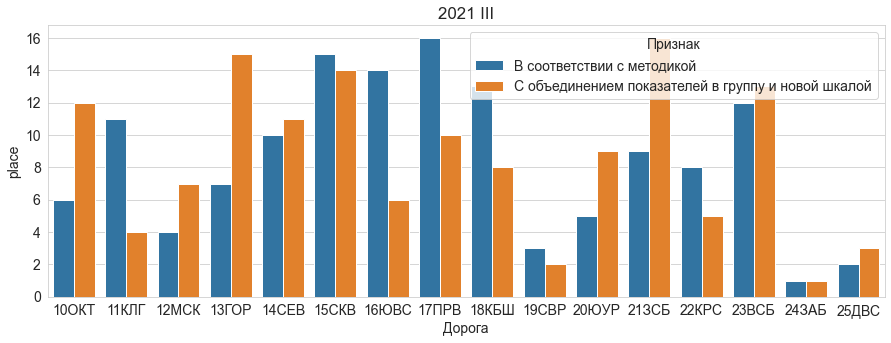

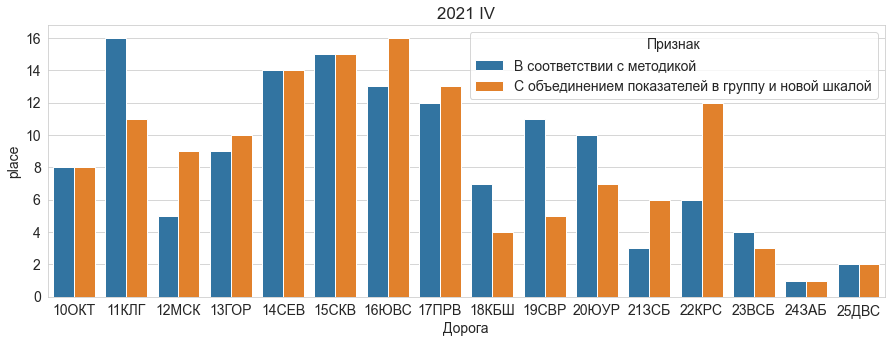

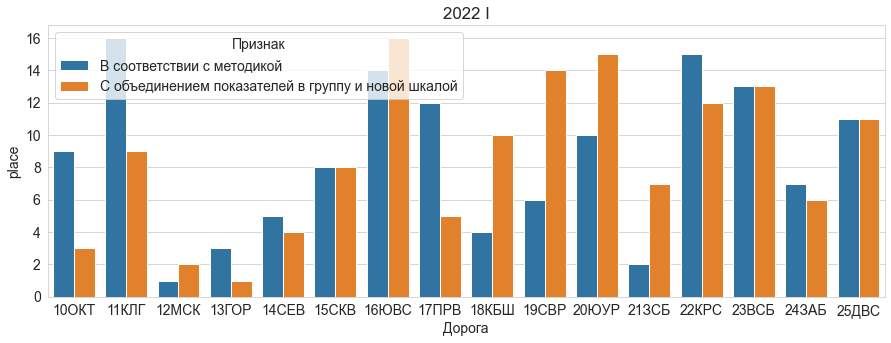

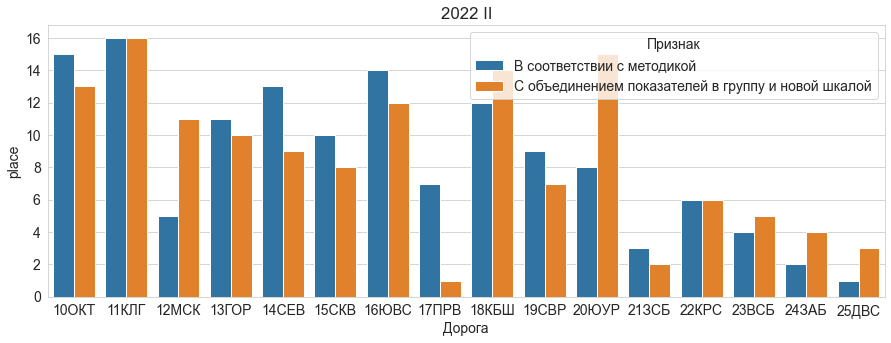

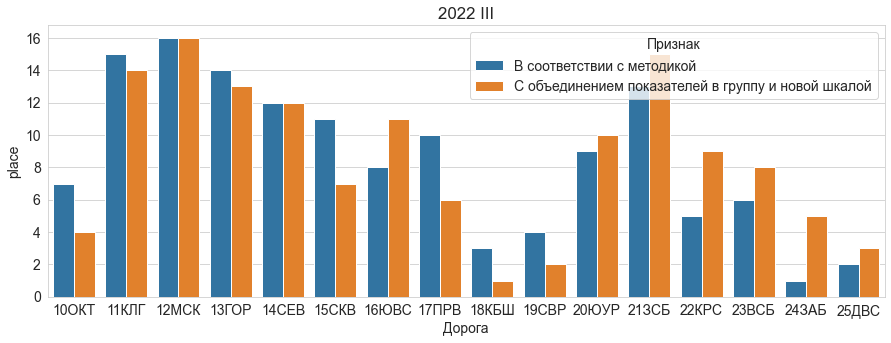

In [107]:
for i in xyz['Период'].unique():
    plt.figure(figsize=(15,5))
    sns.barplot(data=xyz[xyz['Период']==i], x='Дорога', y='place', hue='Признак')
    plt.title(i)

Text(0.5, 1.0, 'Средний рейтинг с применением изменений шкалы и объединенем показателей в группу')

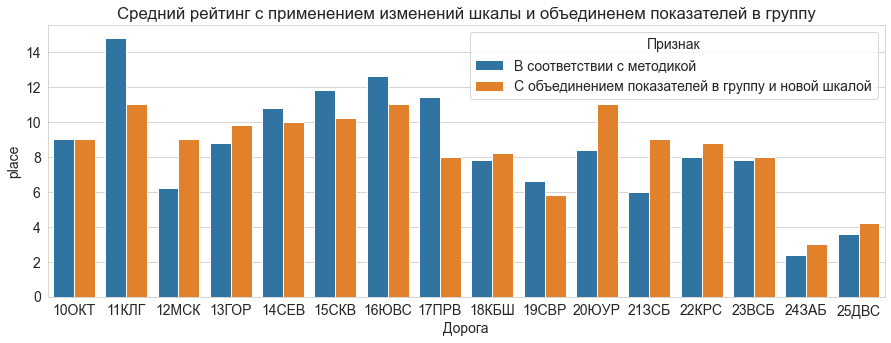

In [696]:
plt.figure(figsize=(15,5))
sns.barplot(data=xyz.groupby(['Дорога','Признак'],as_index=False)['place'].agg('mean'), x='Дорога', y='place', hue='Признак')
plt.title('Средний рейтинг с применением изменений шкалы и объединенем показателей в группу')

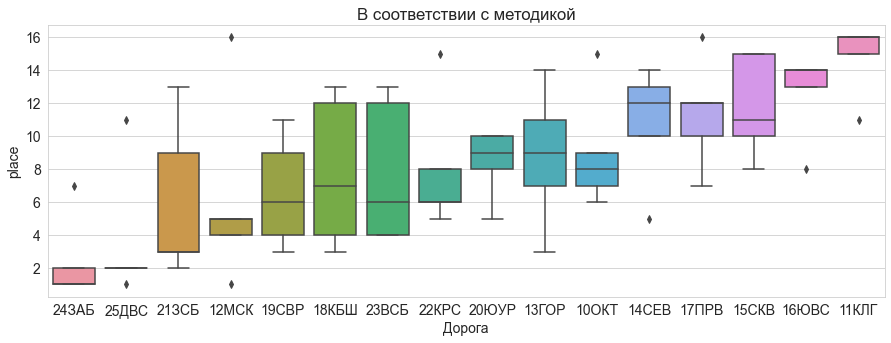

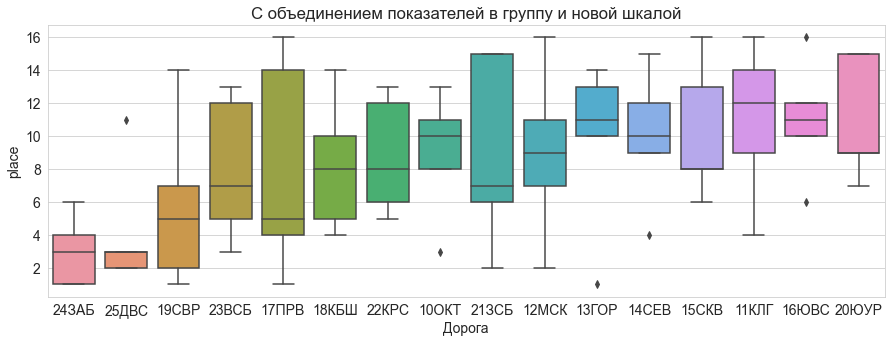

In [697]:
for i in xyz['Признак'].unique():
    plt.figure(figsize=(15,5))
    sns.boxplot(data=xyz[xyz['Признак']==i].sort_values('mean_rank'), x='Дорога', y='place')
    plt.title(i)

### Применение всех изменений

In [108]:
for i in k1:
    if i=='ПФБ':
        cel='Цель_мод'
    else:
        cel='Цель'
    df1_kvart2 [(i,'otkl')] = df1_kvart2[(i,'Факт')] - df1_kvart2[(i,cel)]
    df1_kvart2[(i,'upper_bor')] = df1_kvart2.groupby(('Дорога',''),as_index=False)[[(i,'otkl')]].transform(lambda x: x[df1_kvart2[(i,'otkl')]>0].median())[(i,'otkl')] + df1_kvart2[(i, cel)]
    df1_kvart2.loc[df1_kvart2[(i,'upper_bor')].isna(),(i,'upper_bor')] = df1_kvart2[df1_kvart2[(i,'upper_bor')].isna()][(i,cel)]
    df1_kvart2[(i,'lower_bor')]= df1_kvart2.groupby(('Дорога',''),as_index=False)[[(i,'otkl')]].transform(lambda x: x[df1_kvart2[(i,'otkl')]<=0].median())[(i,'otkl')] + df1_kvart2[(i,cel)]
    df1_kvart2.loc[df1_kvart2[(i,'lower_bor')].isna(),(i,'lower_bor')] = df1_kvart2[df1_kvart2[(i,'lower_bor')].isna()][(i,cel)]
df1_kvart2.sort_index(axis=1)


basic   gruppk1                                                    \
          lower_bor      otkl upper_bor  vip_full   vip_inv     zeros   
0   16.20 -0.079118  0.183261  0.138299 -0.198801 -0.142247  0.013231   
1   16.20 -0.114641  0.103245  0.102776 -0.159522 -0.107003  0.013231   
2   15.36 -0.142138  0.113107  0.075279 -0.119204 -0.103563  0.013231   
3   15.36 -0.086162  0.231662  0.131255 -0.116536  0.033362  0.013231   
4   15.36 -0.022923 -0.069233  0.194493 -0.034893  0.115167  0.013231   
..    ...       ...       ...       ...       ...       ...       ...   
75  23.51 -0.467831 -0.081690 -0.103099  0.111903  0.206200  0.013231   
76  23.51 -0.477964  0.154548 -0.113232 -0.132971 -0.362657  0.013231   
77  22.29 -0.733263  0.411536 -0.368531  0.022311 -0.115138  0.013231   
78  22.29 -0.431241 -0.033117 -0.066509  0.030718  0.036843  0.013231   
79  22.29 -0.441970 -0.422034 -0.077238  0.057033  0.110269  0.013231   

                            modif Вып.расп.пасс.                          \
        Факт      Цель              cel_stand_gr fact_stand_gr lower_bor   
0   0.173376 -0.009885  11.411666       0.058151      0.212102   97.1855   
1   0.057837 -0.045408  11.411666       0.274691      0.040353   97.9155   
2   0.040202 -0.072905  10.585624       0.274691      0.013953   97.9155   
3   0.214734 -0.016929  10.585624       0.046286      0.244435   97.1455   
4  -0.022923  0.046310  10.585624       0.046286      0.079805   97.1455   
..       ...       ...        ...            ...           ...       ...   
75 -0.467831 -0.386140  14.386706       0.058151     -0.071180   96.6820   
76 -0.241726 -0.396273  14.386706       0.274691     -0.576639   97.4120   
77 -0.240037 -0.651573  12.915044       0.274691     -0.049230   97.4120   
78 -0.382667 -0.349550  12.915044       0.046286     -0.350607   96.6420   
79 -0.782314 -0.360280  12.915044       0.046286     -1.022475   96.6420   

                                                                      \
     otkl upper_bor       vip   vip_inv vip_inv_mean vip_inv_ok_neok   
0   0.519    98.539  0.005295  0.005295    -0.000727        0.005295   
1  -0.790    99.269 -0.008000 -0.008000    -0.000727       -0.008000   
2  -0.879    99.269 -0.008901 -0.008901    -0.000727       -0.008901   
3   0.668    98.499  0.006818  0.006818    -0.000727        0.006818   
4   0.113    98.499  0.001153  0.001153    -0.000727        0.001153   
..    ...       ...       ...       ...          ...             ...   
75 -0.436    98.020 -0.004448 -0.004448    -0.019000       -0.004448   
76 -2.870    98.750 -0.029063 -0.029063    -0.019000       -0.029063   
77 -1.092    98.750 -0.011058 -0.011058    -0.019000       -0.011058   
78 -1.338    97.980 -0.013656 -0.013656    -0.019000       -0.013656   
79 -3.603    97.980 -0.036773 -0.036773    -0.019000       -0.036773   

                                                                          \
   vip_inv_ok_ok vip_inv_ok_ok_ok vip_inv_stand_gr vip_inv_stand_gr_full   
0          0.005            0.005         0.311861              0.285312   
1         -0.008           -0.008         0.033751              0.154468   
2         -0.009           -0.009         0.014898              0.145598   
3          0.007            0.007         0.343717              0.300299   
4          0.001            0.001         0.225225              0.244552   
..           ...              ...              ...                   ...   
75        -0.004           -0.004         0.108053             -0.160269   
76        -0.029           -0.029        -0.406863             -0.293042   
77        -0.011           -0.011        -0.030222             -0.195924   
78        -0.014           -0.014        -0.084561             -0.209935   
79        -0.037           -0.037        -0.568135             -0.334627   

                                                                        \
   vip_inv_std vip_inv_std_min vip_inv_stdnormed vip_ok_neok vip_

In [109]:
df1_kvart2[[('gruppk1','vip_inv'), ('gruppk1','vip_full'), ('gruppk1','zeros'), ('gruppk1','Цель'), ('gruppk1','Факт')]] = 0
for i in k1:
    if i=='ПФБ':
        cel='Цель_мод'
    else:
        cel='Цель'
    df1_kvart2[[(i,'vip_inv_mean'),(i,'vip_inv_std')]]=None
    df1_kvart2[(i,'vip_inv_mean')] = df1_kvart2.loc[:,[(i,'vip_inv'),('Дорога','')]].groupby(('Дорога',''), as_index=False)[[(i,'vip_inv')]].transform('mean')[(i,'vip_inv')]
    df1_kvart2[[(i,'vip_inv_std')]] = df1_kvart2.loc[:,[(i,'vip_inv'),('Дорога','')]].groupby(('Дорога',''), as_index=False)[[(i,'vip_inv')]].transform('std')
    df1_kvart2[[(i,'vip_inv_std_min')]] = df1_kvart2[(i,'vip_inv_std')].min()
    df1_kvart2[(i,'vip_inv_stdnormed')] = df1_kvart2[(i,'vip_inv_mean')] + (df1_kvart2[(i,'vip_inv')] - df1_kvart2[(i,'vip_inv_mean')]) * df1_kvart2[(i,'vip_inv_std_min')] / df1_kvart2[(i,'vip_inv_std')]
    df1_kvart2[(i,'vip_inv_stand_gr_full')] = (df1_kvart2[(i,'vip_inv_stdnormed')] - df1_kvart2[(i,'vip_inv_stdnormed')].mean()) / df1_kvart2[(i,'vip_inv_stdnormed')].std()
    df1_kvart2.loc[:,(i,'vip_inv_stand_gr')] = (df1_kvart2[(i,'vip_inv')] - df1_kvart2[(i,'vip_inv')].mean()) / df1_kvart2[(i,'vip_inv')].std()

    df1_kvart2.loc[:,('gruppk1','vip_full')] = df1_kvart2.loc[:,('gruppk1','vip_full')] + df1_kvart2[(i,'vip_inv_stand_gr_full')] * weight_metr[i]
    df1_kvart2.loc[:,('gruppk1','vip_inv')] = df1_kvart2.loc[:,('gruppk1','vip_inv')] + df1_kvart2[(i,'vip_inv_stand_gr')] * weight_metr[i]

    df1_kvart2.loc[:,(i,'zeros_stand_gr')] = (0 - df1_kvart2[(i,'vip_inv')].mean()) / df1_kvart2[(i,'vip_inv')].std()
    df1_kvart2.loc[:,('gruppk1','zeros')] = df1_kvart2.loc[:,('gruppk1','zeros')] + df1_kvart2[(i,'zeros_stand_gr')] * weight_metr[i] * type_metr[i]

    df1_kvart2.loc[:,(i,'fact_stand_gr')] = (df1_kvart2[(i,'Факт')] - pd.concat([df1_kvart2[(i,'Факт')],df1_kvart2[(i,cel)]], axis=0).mean()) / pd.concat([df1_kvart2[(i,'Факт')],df1_kvart2[(i,cel)]], axis=0).std()
    df1_kvart2.loc[:,('gruppk1','Факт')] = df1_kvart2.loc[:,('gruppk1','Факт')] + df1_kvart2[(i,'fact_stand_gr')] * weight_metr[i] * type_metr[i]

    df1_kvart2.loc[:,(i,'cel_stand_gr')] = (df1_kvart2[(i,cel)] - pd.concat([df1_kvart2[(i,'Факт')],df1_kvart2[(i,cel)]], axis=0).mean()) / pd.concat([df1_kvart2[(i,'Факт')],df1_kvart2[(i,cel)]], axis=0).std()
    df1_kvart2.loc[:,('gruppk1','Цель')] = df1_kvart2.loc[:,('gruppk1','Цель')] + df1_kvart2[(i,'cel_stand_gr')] * weight_metr[i] * type_metr[i]


df1_kvart2.sort_index(axis=1)

basic   gruppk1                                                    \
          lower_bor      otkl upper_bor  vip_full   vip_inv     zeros   
0   16.20 -0.079118  0.183261  0.138299 -0.198801 -0.142247  0.013231   
1   16.20 -0.114641  0.103245  0.102776 -0.159522 -0.107003  0.013231   
2   15.36 -0.142138  0.113107  0.075279 -0.119204 -0.103563  0.013231   
3   15.36 -0.086162  0.231662  0.131255 -0.116536  0.033362  0.013231   
4   15.36 -0.022923 -0.069233  0.194493 -0.034893  0.115167  0.013231   
..    ...       ...       ...       ...       ...       ...       ...   
75  23.51 -0.467831 -0.081690 -0.103099  0.111903  0.206200  0.013231   
76  23.51 -0.477964  0.154548 -0.113232 -0.132971 -0.362657  0.013231   
77  22.29 -0.733263  0.411536 -0.368531  0.022311 -0.115138  0.013231   
78  22.29 -0.431241 -0.033117 -0.066509  0.030718  0.036843  0.013231   
79  22.29 -0.441970 -0.422034 -0.077238  0.057033  0.110269  0.013231   

                            modif Вып.расп.пасс.                          \
        Факт      Цель              cel_stand_gr fact_stand_gr lower_bor   
0   0.089459  0.098582  11.411666       0.058151      0.212102   97.1855   
1  -0.039841  0.063683  11.411666       0.274691      0.040353   97.9155   
2  -0.035608  0.043864  10.585624       0.274691      0.013953   97.9155   
3   0.138638  0.095391  10.585624       0.046286      0.244435   97.1455   
4  -0.157461  0.159325  10.585624       0.046286      0.079805   97.1455   
..       ...       ...        ...            ...           ...       ...   
75 -0.636642 -0.165468  14.386706       0.058151     -0.071180   96.6820   
76 -0.359913 -0.124776  14.386706       0.274691     -0.576639   97.4120   
77 -0.364537 -0.299716  12.915044       0.274691     -0.049230   97.4120   
78 -0.534436 -0.083065  12.915044       0.046286     -0.350607   96.6420   
79 -1.003973 -0.079324  12.915044       0.046286     -1.022475   96.6420   

                                                                      \
     otkl upper_bor       vip   vip_inv vip_inv_mean vip_inv_ok_neok   
0   0.519    98.539  0.005295  0.005295    -0.000727        0.005295   
1  -0.790    99.269 -0.008000 -0.008000    -0.000727       -0.008000   
2  -0.879    99.269 -0.008901 -0.008901    -0.000727       -0.008901   
3   0.668    98.499  0.006818  0.006818    -0.000727        0.006818   
4   0.113    98.499  0.001153  0.001153    -0.000727        0.001153   
..    ...       ...       ...       ...          ...             ...   
75 -0.436    98.020 -0.004448 -0.004448    -0.019000       -0.004448   
76 -2.870    98.750 -0.029063 -0.029063    -0.019000       -0.029063   
77 -1.092    98.750 -0.011058 -0.011058    -0.019000       -0.011058   
78 -1.338    97.980 -0.013656 -0.013656    -0.019000       -0.013656   
79 -3.603    97.980 -0.036773 -0.036773    -0.019000       -0.036773   

                                                                          \
   vip_inv_ok_ok vip_inv_ok_ok_ok vip_inv_stand_gr vip_inv_stand_gr_full   
0          0.005            0.005         0.311861              0.285312   
1         -0.008           -0.008         0.033751              0.154468   
2         -0.009           -0.009         0.014898              0.145598   
3          0.007            0.007         0.343717              0.300299   
4          0.001            0.001         0.225225              0.244552   
..           ...              ...              ...                   ...   
75        -0.004           -0.004         0.108053             -0.160269   
76        -0.029           -0.029        -0.406863             -0.293042   
77        -0.011           -0.011        -0.030222             -0.195924   
78        -0.014           -0.014        -0.084561             -0.209935   
79        -0.037           -0.037        -0.568135             -0.334627   

                                                                        \
   vip_inv_std vip_inv_std_min vip_inv_stdnormed vip_ok_neok vip_

In [110]:
for i in ['gruppk1']:
    df1_kvart2 [(i,'otkl')] = df1_kvart2[(i,'Факт')] - df1_kvart2[(i, 'Цель')]
    df1_kvart2[(i,'upper_bor')] = df1_kvart2.groupby(('Дорога',''),as_index=False)[[(i,'otkl')]].transform(lambda x: x[df1_kvart2[(i,'otkl')]>0].median())[(i,'otkl')] + df1_kvart2[(i, 'Цель')]
    df1_kvart2.loc[df1_kvart2[(i,'upper_bor')].isna(),(i,'upper_bor')] = df1_kvart2[df1_kvart2[(i,'upper_bor')].isna()][(i,'Цель')]

    df1_kvart2[(i,'lower_bor')]= df1_kvart2.groupby(('Дорога',''),as_index=False)[[(i,'otkl')]].transform(lambda x: x[df1_kvart2[(i,'otkl')]<=0].median())[(i,'otkl')] + df1_kvart2[(i,'Цель')]
    df1_kvart2.loc[df1_kvart2[(i,'lower_bor')].isna(),(i,'lower_bor')] = df1_kvart2[df1_kvart2[(i,'lower_bor')].isna()][(i,'Цель')]

#    df1_kvart2.loc[:,(i,'vip_inv')] = df1_kvart2.loc[:,(i,'Факт')] / df1_kvart2.loc[:,(i,'Цель')] - 1


df1_kvart2.sort_index(axis=1)


basic   gruppk1                                                    \
          lower_bor      otkl upper_bor  vip_full   vip_inv     zeros   
0   16.20  0.007085 -0.009124  0.141829 -0.198801 -0.142247  0.013231   
1   16.20 -0.027815 -0.103524  0.106930 -0.159522 -0.107003  0.013231   
2   15.36 -0.047634 -0.079472  0.087111 -0.119204 -0.103563  0.013231   
3   15.36  0.003893  0.043247  0.138638 -0.116536  0.033362  0.013231   
4   15.36  0.067827 -0.316786  0.202571 -0.034893  0.115167  0.013231   
..    ...       ...       ...       ...       ...       ...       ...   
75  23.51 -0.616839 -0.471175 -0.165468  0.111903  0.206200  0.013231   
76  23.51 -0.576147 -0.235137 -0.124776 -0.132971 -0.362657  0.013231   
77  22.29 -0.751087 -0.064821 -0.299716  0.022311 -0.115138  0.013231   
78  22.29 -0.534436 -0.451371 -0.083065  0.030718  0.036843  0.013231   
79  22.29 -0.530696 -0.924648 -0.079324  0.057033  0.110269  0.013231   

                            modif Вып.расп.пасс.                          \
        Факт      Цель              cel_stand_gr fact_stand_gr lower_bor   
0   0.089459  0.098582  11.411666       0.058151      0.212102   97.1855   
1  -0.039841  0.063683  11.411666       0.274691      0.040353   97.9155   
2  -0.035608  0.043864  10.585624       0.274691      0.013953   97.9155   
3   0.138638  0.095391  10.585624       0.046286      0.244435   97.1455   
4  -0.157461  0.159325  10.585624       0.046286      0.079805   97.1455   
..       ...       ...        ...            ...           ...       ...   
75 -0.636642 -0.165468  14.386706       0.058151     -0.071180   96.6820   
76 -0.359913 -0.124776  14.386706       0.274691     -0.576639   97.4120   
77 -0.364537 -0.299716  12.915044       0.274691     -0.049230   97.4120   
78 -0.534436 -0.083065  12.915044       0.046286     -0.350607   96.6420   
79 -1.003973 -0.079324  12.915044       0.046286     -1.022475   96.6420   

                                                                      \
     otkl upper_bor       vip   vip_inv vip_inv_mean vip_inv_ok_neok   
0   0.519    98.539  0.005295  0.005295    -0.000727        0.005295   
1  -0.790    99.269 -0.008000 -0.008000    -0.000727       -0.008000   
2  -0.879    99.269 -0.008901 -0.008901    -0.000727       -0.008901   
3   0.668    98.499  0.006818  0.006818    -0.000727        0.006818   
4   0.113    98.499  0.001153  0.001153    -0.000727        0.001153   
..    ...       ...       ...       ...          ...             ...   
75 -0.436    98.020 -0.004448 -0.004448    -0.019000       -0.004448   
76 -2.870    98.750 -0.029063 -0.029063    -0.019000       -0.029063   
77 -1.092    98.750 -0.011058 -0.011058    -0.019000       -0.011058   
78 -1.338    97.980 -0.013656 -0.013656    -0.019000       -0.013656   
79 -3.603    97.980 -0.036773 -0.036773    -0.019000       -0.036773   

                                                                          \
   vip_inv_ok_ok vip_inv_ok_ok_ok vip_inv_stand_gr vip_inv_stand_gr_full   
0          0.005            0.005         0.311861              0.285312   
1         -0.008           -0.008         0.033751              0.154468   
2         -0.009           -0.009         0.014898              0.145598   
3          0.007            0.007         0.343717              0.300299   
4          0.001            0.001         0.225225              0.244552   
..           ...              ...              ...                   ...   
75        -0.004           -0.004         0.108053             -0.160269   
76        -0.029           -0.029        -0.406863             -0.293042   
77        -0.011           -0.011        -0.030222             -0.195924   
78        -0.014           -0.014        -0.084561             -0.209935   
79        -0.037           -0.037        -0.568135             -0.334627   

                                                                        \
   vip_inv_std vip_inv_std_min vip_inv_stdnormed vip_ok_neok vip_

In [111]:
def ranking4(per, year=0):
    global df1_kvart2
    df_r_bir = df1_kvart2
    df_r_bir = df_r_bir[df_r_bir[('Период', '')] == per]
    for i in k2:
        #положительные в диапазоне 0.95-1.05, остальные - отрицательные
        if i in ['КЗ']:
            if sum(df_r_bir[(i,'Цель')])==sum(df_r_bir[(i,'Факт')]):
                #для нулевых месяцев (январь, февраль)
                df_r_bir.loc[(df_r_bir[(i,'vip_inv')]>=0) & (df_r_bir[(i,'Факт')]==0) & (df_r_bir[(i,'Цель')]==0),(i,'rank0')] = 0
                df_r_bir.loc[(df_r_bir[(i,'vip_inv')]>=0) & (df_r_bir[(i,'Факт')]==0) & (df_r_bir[(i,'Цель')]==0),(i,'rank')] = 0
            else:
                #присваиваем баллы показателям в диапазоне
                df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank0')] = df_r_bir[
                    (df_r_bir[(i,'vip')]<=0.05)].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=False)[(i,'vip')]
                #присваиваем отрицательные ранги
                df_r_bir.loc[(df_r_bir[(i,'vip')]>0.05),(i,'rank')] = - df_r_bir[
                    (df_r_bir[(i,'vip')]>0.05)].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
                if len(df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank0')])==16:
                    df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank')] =  df_r_bir.loc[
                        (df_r_bir[(i,'vip')]<=0.05),(i,'rank0')]
                else:
                    df_r_bir.loc[(df_r_bir[(i,'vip')]<=0.05),(i,'rank')] =  df_r_bir.loc[
                                                                                (df_r_bir[(i,'vip')]<=0.05),(i,'rank0')]-df_r_bir.loc[(df_r_bir[(i,'vip')]>0.05),(i,'rank')].min()

        #если больше 1 - отрицательные баллы от наименьшего, если меньше - положительные от наименьшего
        elif i in ['Себестоимость']:
            #присваиваем положительные баллы от большего к меньшему для выполнивших цель дорог
            df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank0')] = df_r_bir[
                (df_r_bir[(i,'vip')]<=0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
            #присваиваем отрицательные баллы
            df_r_bir.loc[(df_r_bir[(i,'vip')]>0),(i,'rank')] = - df_r_bir[
                (df_r_bir[(i,'vip')]>0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]
            df_r_bir.loc[(df_r_bir[(i,'Факт')]==0) | (df_r_bir[(i,'Цель')]==0),(i,'rank')] = np.nan

            if len(df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank0')])==16:
                df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank')] =  df_r_bir.loc[
                    (df_r_bir[(i,'vip')]<=0),(i,'rank0')]
            else:
                df_r_bir.loc[(df_r_bir[(i,'vip')]<=0),(i,'rank')] =  df_r_bir.loc[
                                                                         (df_r_bir[(i,'vip')]<=0),(i,'rank0')]-df_r_bir.loc[(df_r_bir[(i,'vip')]>0),(i,'rank')].min()

        #если x>=1 - среднее арифметическое от присвоенных баллов, если Цель<x<1 - остальные положительные баллы
        #если x<Цель - отрицательные баллы
        elif i in ['УШ']:
            df_r_bir.loc[(df_r_bir[(i,'Факт')]<df_r_bir[(i,'Цель')]),(i,'rank')] = - df_r_bir[
                (df_r_bir[(i,'Факт')]<df_r_bir[(i,'Цель')])].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=False)[(i,'vip')]

            df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                (df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')])].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]

            if len(df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')])==16:
                df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank')] =  df_r_bir.loc[
                    (df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')]
            else:
                df_r_bir.loc[(df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank')] =  df_r_bir.loc[
                                                                                            (df_r_bir[(i,'Факт')]>df_r_bir[(i,'Цель')]),(i,'rank0')]-df_r_bir.loc[(df_r_bir[(i,'Факт')]<df_r_bir[(i,'Цель')]),(i,'rank')].min()

            df_r_bir.loc[(df_r_bir[(i,'Факт')]>100),(i,'rank')] = df_r_bir.loc[(df_r_bir[(i,'Факт')]>100),(i,'rank')].mean()

        #положительные баллы - в первую очередь для тех, кто выполнил первоначальный план, даже при условии не выполнения скорректированного
        #положительные баллы во вторую очередь тем, кто выполнил скорректированный в меньшую сторону план при невыполнении первоначального
        #отрицательные баллы - если не выполнены ни первоначальный, ни скорректированный планы
        elif i in ['Погрузка грузов']:
            #отрицательные баллы
            df_r_bir.loc[(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'vip')]<0),(i,'rank0')] = - df_r_bir[
                (df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'vip')]<0)].groupby(
                ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=False)[(i,'vip')]
            #если есть отрицательные баллы
            if df_r_bir[(i,'rank0')].max()<0:
                #если выполнен скорреткированный план, но не выполнен первоначальный по дорогам, у которых план изменился в меньшую сторону
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                                                                                                                                                                (df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+abs(df_r_bir[(i,'rank0')]).max()
                #если не выполнен скорректированный план, но выполнен первоначальный
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                                                                                                                                                                (df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+abs(df_r_bir[(i,'rank0')]).max()
            #если нет отрицательных баллов
            else:
                #аналогично, но смотрим на неокругленное выполнение
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                    (df_r_bir[(i,'vip_sc')]>=0)&(df_r_bir[(i,'vip')]<0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]

                #аналогично, но смотрим на неокругленное выполнение
                df_r_bir.loc[(df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')]),(i,'rank0')] = df_r_bir[
                    (df_r_bir[(i,'vip_sc')]<=0)&(df_r_bir[(i,'vip')]>0) & (df_r_bir[(i,'Цель (скорр. план)')]<df_r_bir[(i,'Цель')])].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]

            #положительные баллы, если выполнены оба плана
            #либо если выполнен только первоначальный, но не выполнен скорректированный (бывает повышают план в таком случае, но считают все равно по первоначальному)
            #если есть отрицательные баллы
            if df_r_bir[(i,'rank0')].max()<0:
                df_r_bir.loc[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))
                ,(i,'rank')] = df_r_bir[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+abs(df_r_bir[(i,'rank0')]).max()
            #если нет отрицательных баллов
            else:
                df_r_bir.loc[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))
                ,(i,'rank')] = df_r_bir[((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]>0)) | ((df_r_bir[(i,'vip')]>=0)&(df_r_bir[(i,'vip_sc')]<0)&(df_r_bir[(i,'Цель (скорр. план)')]>df_r_bir[(i,'Цель')]))].groupby(
                    ('Месяц/Год',''), as_index=False)[[(i,'vip')]].rank(ascending=True)[(i,'vip')]+df_r_bir[(i,'rank0')].max()
            df_r_bir[(i,'rank')].update(df_r_bir[(i,'rank0')])
            #             df_r_bir = df_r_bir.drop((i,'rank0'), axis=1)
            #положительные - x>=0, иначе отрицательные
        df_r_bir[(i, 'rank')] = df_r_bir[(i, 'rank')] - df_r_bir[(i, 'rank')].mean()
    for i in ['gruppk1']:
        #для нулевых месяцев по ДЗ (январь, февраль)
        if type_metr[i]==-1:
            df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')],(i,'rank')] = - df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')],(i,'vip_inv')].rank(ascending=False) - (16 - df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')],(i,'vip_inv')].rank(ascending=False)).min()
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'upper_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'Цель')]),(i,'rank')] = - df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'upper_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'Цель')]),(i,'vip_inv')].rank(ascending=False)
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'lower_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'Цель')]),(i,'rank')] = df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'lower_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'Цель')]),(i,'vip_inv')].rank(ascending=True)
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')]),(i,'rank')] = df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')]) ,(i,'vip_inv')].rank(ascending=True) + (16 - df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')]) ,(i,'vip_inv')].rank(ascending=True).max())
        else:
            df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')],(i,'rank')] = df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')]) ,(i,'vip_inv')].rank(ascending=True) + (16 - df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'upper_bor')]) ,(i,'vip_inv')].rank(ascending=True).max())
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'upper_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'Цель')]),(i,'rank')] = df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'upper_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'Цель')]),(i,'vip_inv')].rank(ascending=True)
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'lower_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'Цель')]),(i,'rank')] = - df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'lower_bor')]) & (df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'Цель')]),(i,'vip_inv')].rank(ascending=False)
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')]),(i,'rank')] = - df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')],(i,'vip_inv')].rank(ascending=False) - (16 - df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'lower_bor')],(i,'vip_inv')].rank(ascending=False)).min()
    #   display(df_r_bir)
    global df_r_full
    df_r_full = df_r_full.append(df_r_bir)

In [112]:
df_r_full = pd.DataFrame()
for per in df1_kvart2[('Период','')].unique():
    ranking4(per)

In [113]:
df_r_full.loc[:,('rating','')] = 0
for i in k2+['gruppk1']:
    df_r_full.loc[:,('rating','')] = df_r_full.loc[:,('rating','')] + df_r_full.loc[:,(i,'rank')] * weight_metr[i]
df_r_full.sort_index(axis=1)

basic   gruppk1                                                          \
          lower_bor      otkl  rank upper_bor  vip_full   vip_inv     zeros   
0   16.20  0.007085 -0.009124  -4.0  0.141829 -0.198801 -0.142247  0.013231   
5   26.06 -0.679989 -1.332571 -12.0  0.752317  1.093164  1.554679  0.013231   
10  19.62 -0.399250 -0.324555 -14.0 -0.083811  0.181781  0.017193  0.013231   
15  10.49  0.069654  0.053144  14.0  0.195523 -0.154964 -0.081796  0.013231   
20  11.77 -0.080815  0.060375  13.0  0.034463 -0.227583 -0.360882  0.013231   
..    ...       ...       ...   ...       ...       ...       ...       ...   
59   9.27  0.674570  0.024318   1.0  0.761210 -0.132769  0.032035  0.013231   
64  11.92 -0.000815 -0.338986 -13.0  0.259522 -0.074746 -0.039957  0.013231   
69   9.71 -0.051953 -0.252114 -14.0  0.156853 -0.282398 -0.085863  0.013231   
74   8.71 -0.987051 -2.539551  -7.0 -0.179636  0.511964  0.771912  0.013231   
79  22.29 -0.530696 -0.924648 -10.0 -0.079324  0.057033  0.110269  0.013231   

                            modif   rating Вып.расп.пасс.                \
        Факт      Цель                       cel_stand_gr fact_stand_gr   
0   0.089459  0.098582  11.411666  -3.9875       0.058151      0.212102   
5  -1.175155  0.157416  15.321693  -8.2750       0.058151      0.622343   
10 -0.408366 -0.083811  12.874258 -11.2625       0.058151      0.206170   
15  0.202262  0.149119   8.359507  10.3125       0.058151      0.254224   
20  0.049784 -0.010591   9.153238   9.8625       0.058151      0.330755   
..       ...       ...        ...      ...            ...           ...   
59  0.753367  0.729048   7.490013   1.2875       0.046286      0.353892   
64 -0.252255  0.086731   9.062201  -9.0625       0.046286     -0.477268   
69 -0.171958  0.080156   7.796770 -10.1875       0.046286     -0.210597   
74 -2.731851 -0.192300   7.090533  -5.4500       0.046286    -10.079505   
79 -1.003973 -0.079324  12.915044  -7.1500       0.046286     -1.022475   

                                                                 \
   lower_bor    otkl upper_bor       vip   vip_inv vip_inv_mean   
0    97.1855   0.519   98.5390  0.005295  0.005295    -0.000727   
5    98.0200   1.902   99.3070  0.019404  0.019404     0.012657   
10   97.0655   0.499   98.0400  0.005091  0.005091    -0.002797   
15   97.6700   0.661   98.4750  0.006744  0.006744     0.002631   
20   97.8340   0.919   99.1135  0.009376  0.009376     0.007802   
..       ...     ...       ...       ...       ...          ...   
59   97.9800   1.037   99.0170  0.010584  0.010584     0.009381   
64   97.4300  -1.765   98.2705 -0.018014 -0.018014    -0.003727   
69   97.4405  -0.866   98.4320 -0.008839 -0.008839    -0.003276   
74   86.6300 -34.136   97.9800 -0.348398 -0.348398    -0.158078   
79   96.6420  -3.603   97.9800 -0.036773 -0.036773    -0.019000   

                                                                    \
   vip_inv_ok_neok vip_inv_ok_ok vip_inv_ok_ok_ok vip_inv_stand_gr   
0         0.005295         0.005            0.005         0.311861   
5         0.019404         0.019            0.019         0.607009   
10        0.005091         0.005            0.005         0.307592   
15        0.006744         0.007            0.007         0.342165   
20        0.009376         0.009            0.009         0.397225   
..             ...           ...              ...              ...   
59        0.010584         0.011            0.011         0.422498   
64       -0.018014        -0.018           -0.018        -0.175725   
69       -0.008839        -0.009           -0.009         0.016210   
74       -0.348398        -0.348           -0.348        -7.086888   
79       -0.036773        -0.037           -0.037        -0.568135   

                                                                        \
   vip_inv_stand_gr_full vip_inv_std vip_inv_std_min vip_inv_stdnormed   
0               0.285312    0.007356        0.002846          0.00160

In [114]:
x=df_ranked[df_ranked['Кол-во месяцев в периоде']==3].loc[:,(['Дорога','Период','rating'],['','',''])]
x['Признак']='В соответствии с методикой'

In [115]:
x2=df_r_full[df_r_full['Кол-во месяцев в периоде']==3].loc[:,(['Дорога','Период','rating'],['','',''])]
x2['Признак']='С применением всех изменений'

In [116]:
df_r_full[df_r_full['Кол-во месяцев в периоде']==3].to_pickle(r'/Users/mihailvardanasvili/Downloads/df_vseizm.pkl')

In [117]:
xyz=pd.concat([x,x2], axis=0)

In [118]:
xyz['place']=xyz.groupby([('Период',''),('Признак','')], as_index=False)['rating'].rank(ascending=True)

In [119]:
xyz['mean_rank'] = xyz.groupby(['Дорога', 'Признак'])['place'].transform('mean')

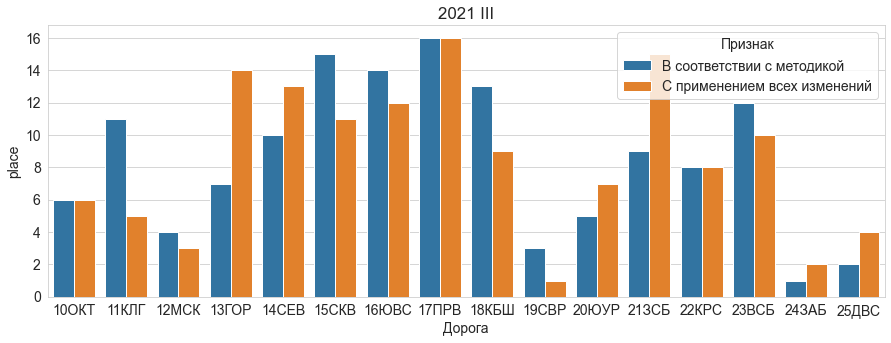

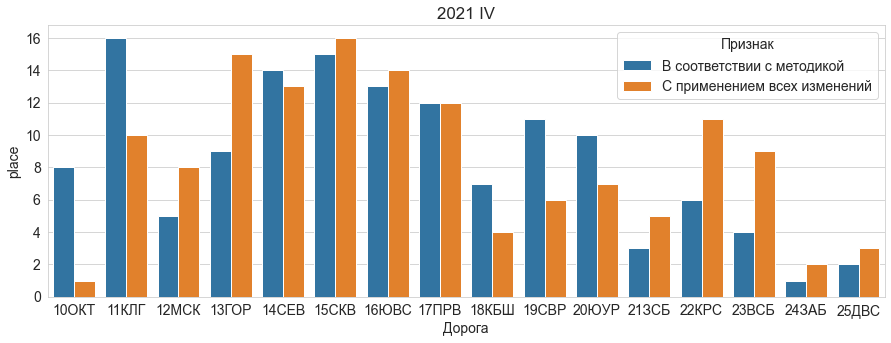

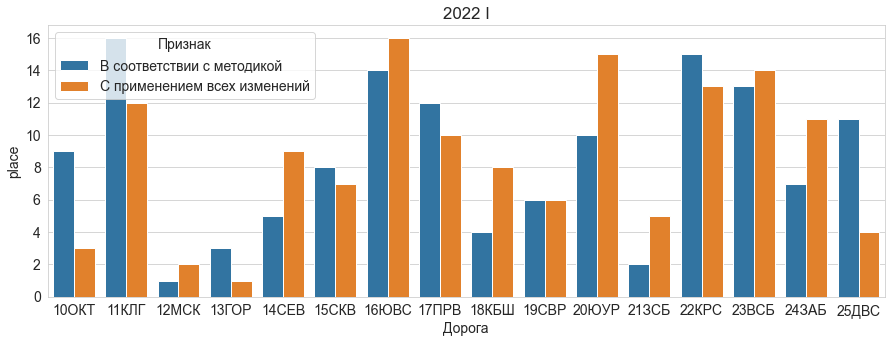

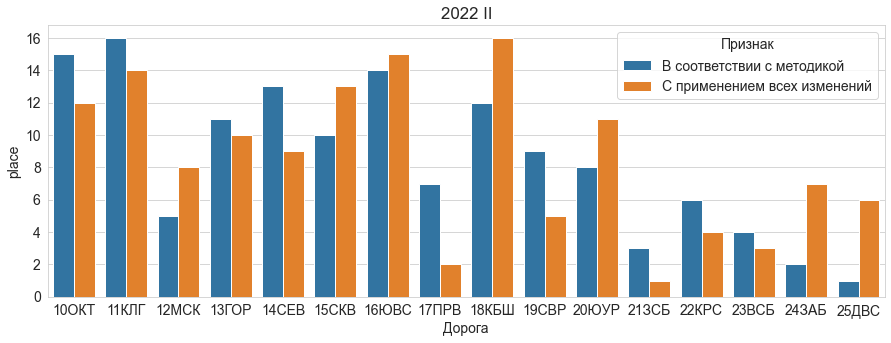

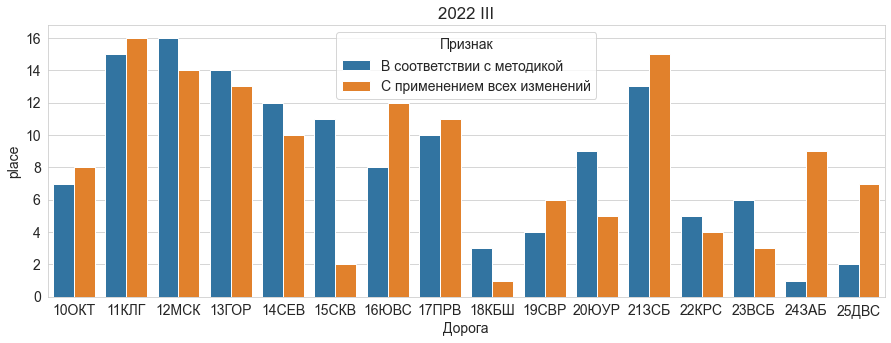

In [120]:
for i in xyz['Период'].unique():
    plt.figure(figsize=(15,5))
    sns.barplot(data=xyz[xyz['Период']==i], x='Дорога', y='place', hue='Признак')
    plt.title(i)

Text(0.5, 1.0, 'Средний рейтинг с применением всех изменений')

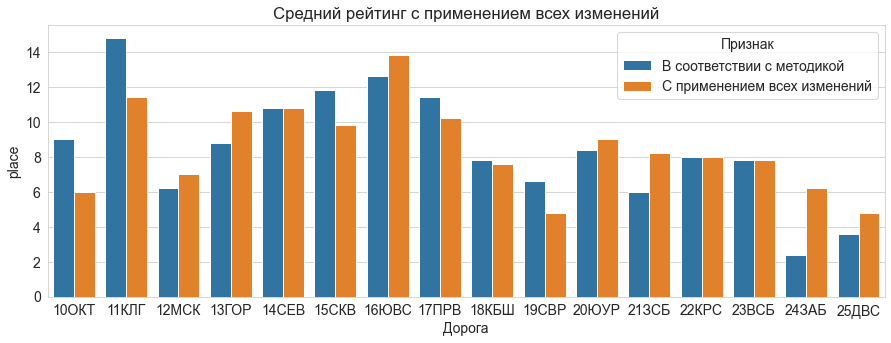

In [121]:
plt.figure(figsize=(15,5))
sns.barplot(data=xyz.groupby(['Дорога','Признак'],as_index=False)['place'].agg('mean'), x='Дорога', y='place', hue='Признак')
plt.title('Средний рейтинг с применением всех изменений')

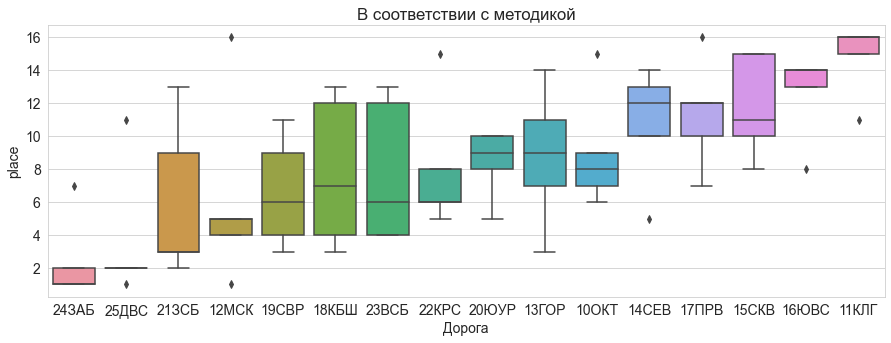

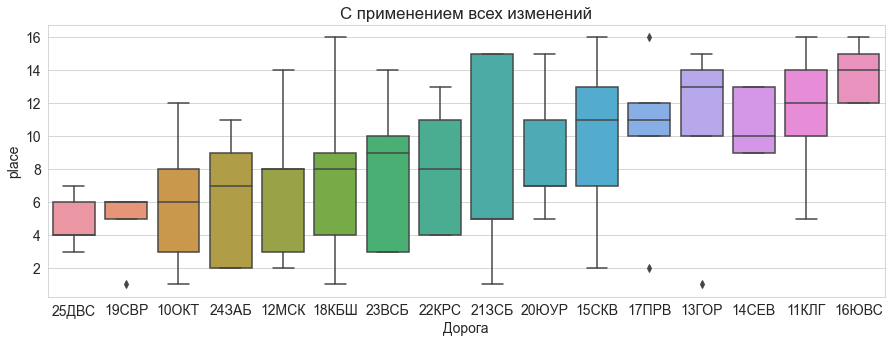

In [122]:
for i in xyz['Признак'].unique():
    plt.figure(figsize=(15,5))
    sns.boxplot(data=xyz[xyz['Признак']==i].sort_values('mean_rank'), x='Дорога', y='place')
    plt.title(i)

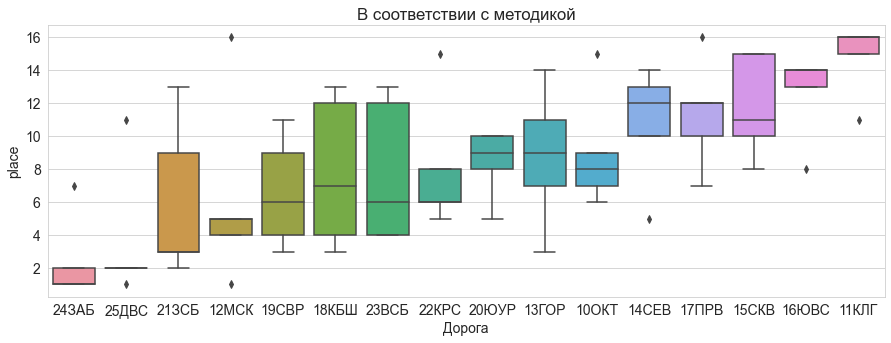

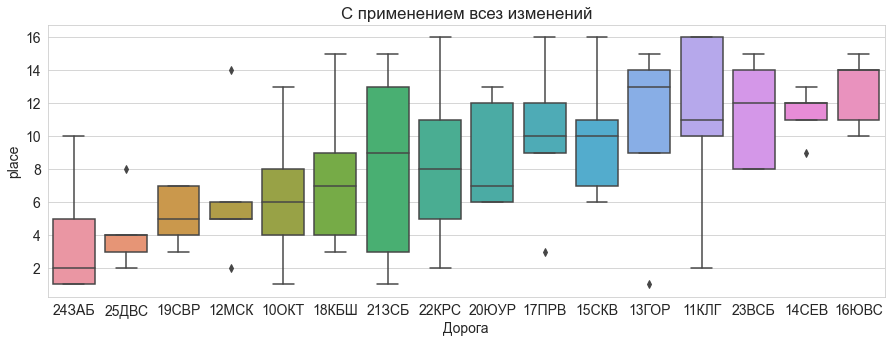

In [548]:
for i in xyz['Признак'].unique():
    plt.figure(figsize=(15,5))
    sns.boxplot(data=xyz[xyz['Признак']==i].sort_values('mean_rank'), x='Дорога', y='place')
    plt.title(i)

In [69]:
def ranking5(per, year=0):
    global df1_kvart2
    df_r_bir = df1_kvart2
    df_r_bir = df_r_bir[df_r_bir[('Период', '')] == per]
    for i in k2:
        #положительные в диапазоне 0.95-1.05, остальные - отрицательные
        if i in ['КЗ']:
            if sum(df_r_bir[(i, 'Цель')]) == sum(df_r_bir[(i, 'Факт')]):
                #для нулевых месяцев (январь, февраль)
                df_r_bir.loc[
                    (df_r_bir[(i, 'vip_inv')] >= 0) & (df_r_bir[(i, 'Факт')] == 0) & (df_r_bir[(i, 'Цель')] == 0),
                    (i, 'rank')] = 0
                df_r_bir.loc[
                    (df_r_bir[(i, 'vip_inv')] >= 0) & (df_r_bir[(i, 'Факт')] == 0) & (df_r_bir[(i, 'Цель')] == 0),
                    (i, 'rank')] = 0
            else:
                #присваиваем баллы показателям в диапазоне
                df_r_bir.loc[(df_r_bir[(i, 'vip')] <= 0.05), (i, 'rank')] = df_r_bir[
                    (df_r_bir[(i, 'vip')] <= 0.05)].groupby(
                    ('Месяц/Год', ''), as_index=False)[[(i, 'vip')]].rank(ascending=False)[(i, 'vip')]
                #присваиваем отрицательные ранги
                df_r_bir.loc[(df_r_bir[(i, 'vip')] > 0.05), (i, 'rank')] = - df_r_bir[
                    (df_r_bir[(i, 'vip')] > 0.05)].groupby(
                    ('Месяц/Год', ''), as_index=False)[[(i, 'vip')]].rank(ascending=True)[(i, 'vip')]

        #если больше 1 - отрицательные баллы от наименьшего, если меньше - положительные от наименьшего
        elif i in ['Себестоимость']:
            #присваиваем положительные баллы от большего к меньшему для выполнивших цель дорог
            df_r_bir.loc[(df_r_bir[(i, 'vip')] <= 0), (i, 'rank')] = df_r_bir[
                (df_r_bir[(i, 'vip')] <= 0)].groupby(
                ('Месяц/Год', ''), as_index=False)[[(i, 'vip')]].rank(ascending=True)[(i, 'vip')]
            #присваиваем отрицательные баллы
            df_r_bir.loc[(df_r_bir[(i, 'vip')] > 0), (i, 'rank')] = - df_r_bir[
                (df_r_bir[(i, 'vip')] > 0)].groupby(
                ('Месяц/Год', ''), as_index=False)[[(i, 'vip')]].rank(ascending=True)[(i, 'vip')]
            df_r_bir.loc[(df_r_bir[(i, 'Факт')] == 0) | (df_r_bir[(i, 'Цель')] == 0), (i, 'rank')] = np.nan



        #если x>=1 - среднее арифметическое от присвоенных баллов, если Цель<x<1 - остальные положительные баллы
        #если x<Цель - отрицательные баллы
        elif i in ['УШ']:
            df_r_bir.loc[(df_r_bir[(i, 'Факт')] < df_r_bir[(i, 'Цель')]), (i, 'rank')] = - df_r_bir[
                (df_r_bir[(i, 'Факт')] < df_r_bir[(i, 'Цель')])].groupby(
                ('Месяц/Год', ''), as_index=False)[[(i, 'vip')]].rank(ascending=False)[(i, 'vip')]

            df_r_bir.loc[(df_r_bir[(i, 'Факт')] > df_r_bir[(i, 'Цель')]), (i, 'rank')] = df_r_bir[
                (df_r_bir[(i, 'Факт')] > df_r_bir[(i, 'Цель')])].groupby(
                ('Месяц/Год', ''), as_index=False)[[(i, 'vip')]].rank(ascending=True)[(i, 'vip')]
            df_r_bir.loc[(df_r_bir[(i, 'Факт')] > 100), (i, 'rank')] = df_r_bir.loc[
                (df_r_bir[(i, 'Факт')] > 100), (i, 'rank')].mean()

        #положительные баллы - в первую очередь для тех, кто выполнил первоначальный план, даже при условии не выполнения скорректированного
        #положительные баллы во вторую очередь тем, кто выполнил скорректированный в меньшую сторону план при невыполнении первоначального
        #отрицательные баллы - если не выполнены ни первоначальный, ни скорректированный планы
        elif i in ['Погрузка грузов']:
            #отрицательные баллы
            df_r_bir.loc[(df_r_bir[(i, 'vip_sc')] < 0) & (df_r_bir[(i, 'vip')] < 0), (i, 'rank')] = - df_r_bir[
                (df_r_bir[(i, 'vip_sc')] < 0) & (df_r_bir[(i, 'vip')] < 0)].groupby(
                ('Месяц/Год', ''), as_index=False)[[(i, 'vip')]].rank(ascending=False)[(i, 'vip')]
            #если есть отрицательные баллы

            df_r_bir.loc[(df_r_bir[(i, 'vip_sc')] >= 0) & (df_r_bir[(i, 'vip')] < 0)
                         & (df_r_bir[(i, 'Цель (скорр. план)')] < df_r_bir[(i, 'Цель')]), (i, 'rank')] = df_r_bir[
                (df_r_bir[(i, 'vip_sc')] >= 0) & (df_r_bir[(i, 'vip')] < 0)
                & (df_r_bir[(i, 'Цель (скорр. план)')] < df_r_bir[(i, 'Цель')])].groupby(
                ('Месяц/Год', ''), as_index=False)[[(i, 'vip')]].rank(ascending=True)[(i, 'vip')]

            #положительные баллы, если выполнены оба плана
            #либо если выполнен только первоначальный, но не выполнен скорректированный (бывает повышают план в таком случае, но считают все равно по первоначальному)
            #если есть отрицательные баллы
            df_r_bir.loc[((df_r_bir[(i, 'vip')] >= 0) & (df_r_bir[(i, 'vip_sc')] > 0)) | (
                        (df_r_bir[(i, 'vip')] >= 0) & (df_r_bir[(i, 'vip_sc')] < 0) & (
                            df_r_bir[(i, 'Цель (скорр. план)')] > df_r_bir[(i, 'Цель')]))
            , (i, 'rank')] = df_r_bir[((df_r_bir[(i, 'vip')] >= 0) & (df_r_bir[(i, 'vip_sc')] > 0)) | (
                        (df_r_bir[(i, 'vip')] >= 0) & (df_r_bir[(i, 'vip_sc')] < 0) & (
                            df_r_bir[(i, 'Цель (скорр. план)')] > df_r_bir[(i, 'Цель')]))].groupby(
                ('Месяц/Год', ''), as_index=False)[[(i, 'vip')]].rank(ascending=True)[(i, 'vip')] + abs(
                df_r_bir[(i, 'rank')]).max()

    #             df_r_bir[(i,'rank')].update(df_r_bir[(i,'rank')])
    #             df_r_bir = df_r_bir.drop((i,'rank0'), axis=1)
    #положительные - x>=0, иначе отрицательные
        else:
            df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'Цель_right')],(i,'rank')]=-df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'Цель_right')],(i,'vip_inv')].rank(ascending=False)
            df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'Цель_left')]) & (df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'Цель_right')]),(i,'rank')]=df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>=df_r_bir.loc[:, (i, 'Цель_left')]) & (df_r_bir.loc[:, (i, 'Факт')]<=df_r_bir.loc[:, (i, 'Цель_right')]),(i,'Цель_мод')].rank(ascending=False)
            df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'Цель_left')],(i,'rank')]=df_r_bir.loc[df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'Цель_left')],(i,'vip_inv')].rank(ascending=True)+df_r_bir.loc[(df_r_bir.loc[:, (i, 'Факт')]>df_r_bir.loc[:, (i, 'Цель_left')]) & (df_r_bir.loc[:, (i, 'Факт')]<df_r_bir.loc[:, (i, 'Цель_right')]),(i,'rank')].max()

    for i in ['gruppk1']:
        #для нулевых месяцев по ДЗ (январь, февраль)
        df_r_bir.loc[:, (i, 'rank')] = df_r_bir.groupby(('Месяц/Год', ''), as_index=False)[[(i, 'vip_full')]].rank(ascending=True)[(i, 'vip_full')]

 #   display(df_r_bir)
    global df_r_full_stand
    df_r_full_stand = df_r_full_stand.append(df_r_bir)

In [70]:
df_r_full_stand = pd.DataFrame()
for per in df1_kvart2[('Период','')].unique():
    ranking5(per)

In [71]:
df_r_full_stand.loc[:,('rating','')] = 0
for i in k2+['gruppk1']:
    df_r_full_stand.loc[:,('rating','')] = df_r_full_stand.loc[:,('rating','')] + df_r_full_stand.loc[:,(i,'rank')] * weight_metr[i]
df_r_full_stand.sort_index(axis=1)

basic gruppk1                          modif  rating Вып.расп.пасс.  \
             rank       vip  vip_full                               vip   
0   16.20     5.0 -0.062222 -0.104475  10.863636  3.2250       0.005295   
5   26.06    16.0  0.350429  0.747586  13.855455  9.5375       0.019404   
10  19.62    11.0 -0.053814  0.023715  11.902727  5.8500       0.005091   
15  10.49    12.0  0.012315  0.040542   9.131818  7.9750       0.006744   
20  11.77     8.0 -0.193730 -0.022470   9.519091  7.3250       0.009376   
..    ...     ...       ...       ...        ...     ...            ...   
59   9.27     6.0  0.037636 -0.121696   8.669091  5.7875       0.010584   
64  11.92    10.0 -0.158336 -0.060540   9.234545  6.4375      -0.018014   
69   9.71     4.0 -0.146664 -0.243122   8.765455  3.5125      -0.008839   
74   8.71     1.0 -0.810519 -0.395894   8.552727  0.6500      -0.348398   
79  22.29     3.0 -0.223914 -0.271868  11.449091  2.1500      -0.036773   

                                                                          \
     vip_inv vip_inv_mean vip_inv_ok_neok vip_inv_ok_ok vip_inv_ok_ok_ok   
0   0.005295    -0.000727        0.005295         0.005            0.005   
5   0.019404     0.012657        0.019404         0.019            0.019   
10  0.005091    -0.002797        0.005091         0.005            0.005   
15  0.006744     0.002631        0.006744         0.007            0.007   
20  0.009376     0.007802        0.009376         0.009            0.009   
..       ...          ...             ...           ...              ...   
59  0.010584     0.009381        0.010584         0.011            0.011   
64 -0.018014    -0.003727       -0.018014        -0.018           -0.018   
69 -0.008839    -0.003276       -0.008839        -0.009           -0.009   
74 -0.348398    -0.158078       -0.348398        -0.348           -0.348   
79 -0.036773    -0.019000       -0.036773        -0.037           -0.037   

                                                                       \
   vip_inv_stand_gr vip_inv_stand_gr_full vip_inv_std vip_inv_std_min   
0          0.311861              0.285312    0.007356        0.002846   
5          0.607009              0.652135    0.005704        0.002846   
10         0.307592              0.259583    0.006625        0.002846   
15         0.342165              0.379056    0.004405        0.002846   
20         0.397225              0.460858    0.006380        0.002846   
..              ...                   ...         ...             ...   
59         0.422498              0.513764    0.002846        0.002846   
64        -0.175725              0.031778    0.008768        0.002846   
69         0.016210              0.084874    0.005276        0.002846   
74        -7.086888             -3.892970    0.118348        0.002846   
79        -0.568135             -0.334627    0.013421        0.002846   

                                                                         \
   vip_inv_stdnormed vip_ok_neok vip_ok_ok vip_ok_ok_ok    Факт Факт_ok   
0           0.001603    0.005295     0.005        0.005  98.539  98.539   
5           0.016023    0.019404     0.019        0.019  99.922  99.922   
10          0.000591    0.005091     0.005        0.005  98.519  98.519   
15          0.005288    0.006744     0.007        0.007  98.681  98.681   
20          0.008504    0.009376     0.009        0.009  98.939  98.939   
..               ...         ...       ...          ...     ...     ...   
59          0.010584    0.010584     0.011        0.011  99.017  99.017   
64         -0.008364   -0.018014    -0.018       -0.018  96.215  96.215   
69         -0.006277   -0.008839    -0.009       -0.009  97.114  97.114   
74         -0.162655   -0.348398    -0.348       -0.348  63.844  63.844   
79         -0.022768   -0.036773    -0.037       -0.037  94.377  94.377   

                  Вып.расп.приг.                                         \
     Цель Цель_ok            vip   vip

In [223]:
x=df_ranked[df_ranked['Кол-во месяцев в периоде']==3].loc[:,(['Дорога','Период','rating'],['','',''])]
x['Признак']='В соответствии с методикой'

In [224]:
y=df_r_biranked.loc[:,(['Дорога','Период','rating'],['','',''])]
y['Признак']='Стандартизация по показателям'

In [225]:
z=df_r_stdnormed.loc[:,(['Дорога','Период','rating'],['','',''])]
z['Признак']='Стандартизация по показателям и дорогам'

In [226]:
full = df_r_full.loc[:,(['Дорога','Период','rating'],['','',''])]
full['Признак']='Стандартизация по показателям и модификация ПФБ'

In [227]:
full_stand = df_r_full_stand.loc[:,(['Дорога','Период','rating'],['','',''])]
full_stand['Признак']='Стандартизация по показателям, дорогам и модификация ПФБ'

NameError: name 'df_r_full_stand' is not defined

In [269]:
xyz=pd.concat([x,full], axis=0)

In [270]:
xyz['place']=xyz.groupby([('Период',''),('Признак','')], as_index=False)['rating'].rank(ascending=True)

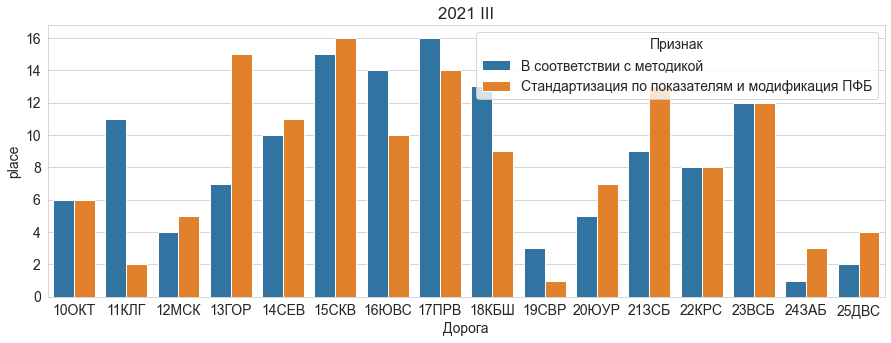

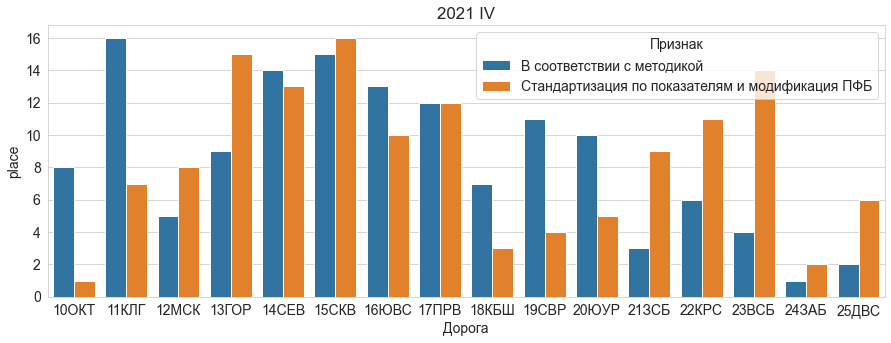

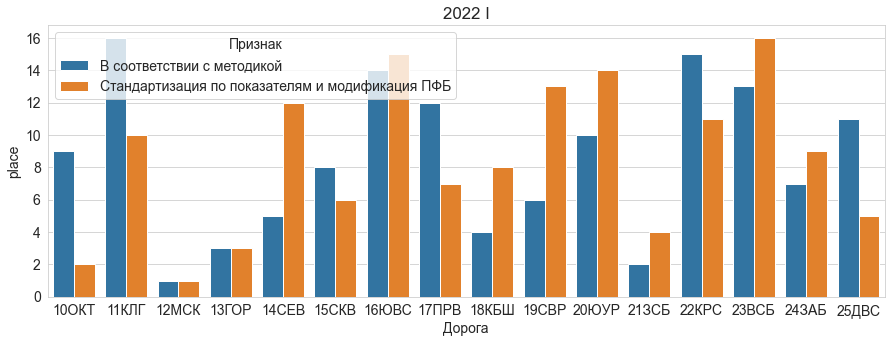

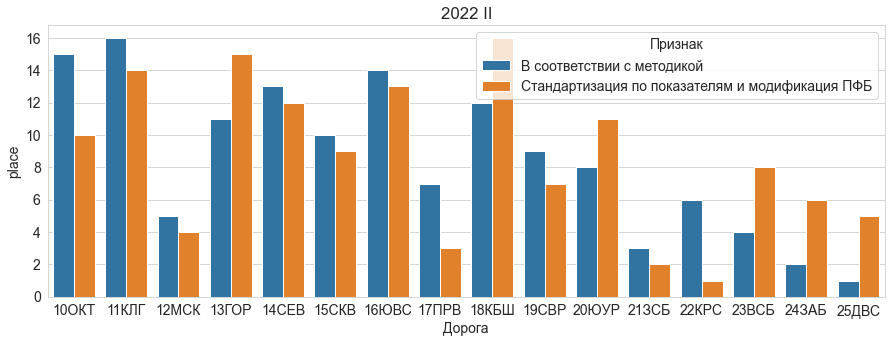

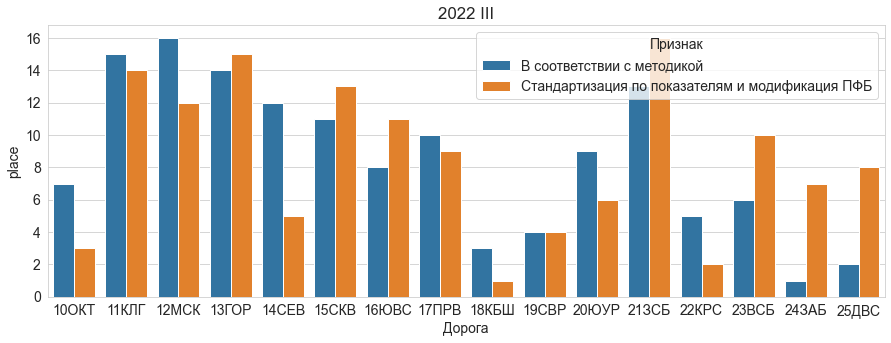

In [271]:
for i in xyz['Период'].unique():
    plt.figure(figsize=(15,5))
    sns.barplot(data=xyz[xyz['Период']==i], x='Дорога', y='place', hue='Признак')
    plt.title(i)


In [80]:
xyz=pd.concat([x,z,full_stand], axis=0)

In [266]:
xyz['place']=xyz.groupby([('Период',''),('Признак','')], as_index=False)['rating'].rank(ascending=True)
#xyz['place']=xyz.groupby([('Период',''),('Признак','')], as_index=False)['rating'].rank(ascending=True)

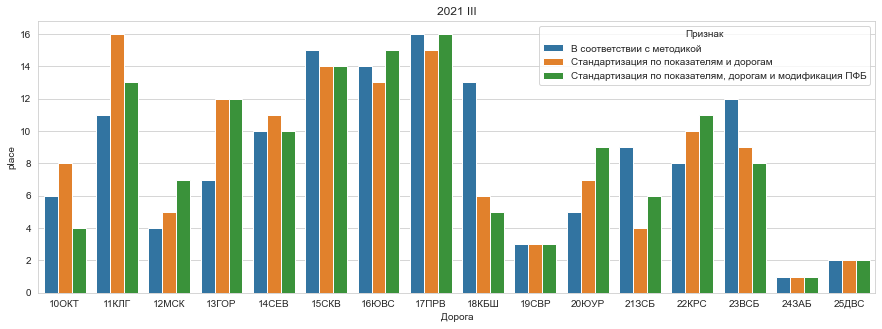

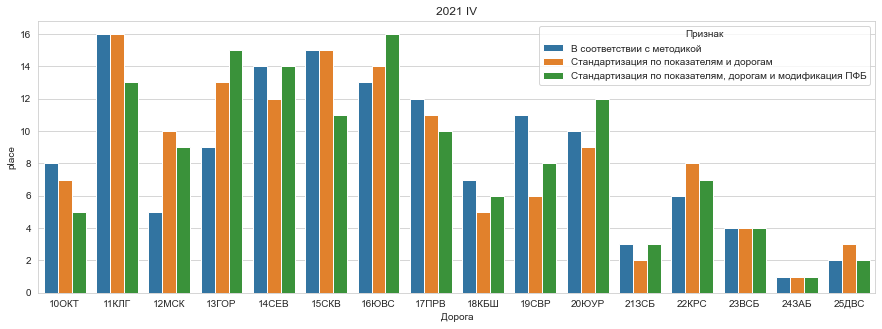

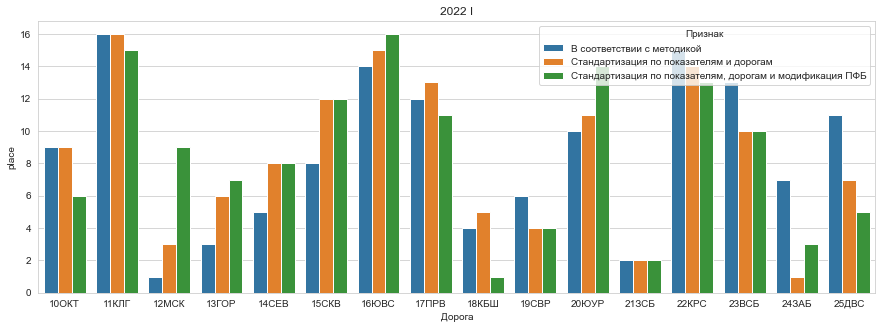

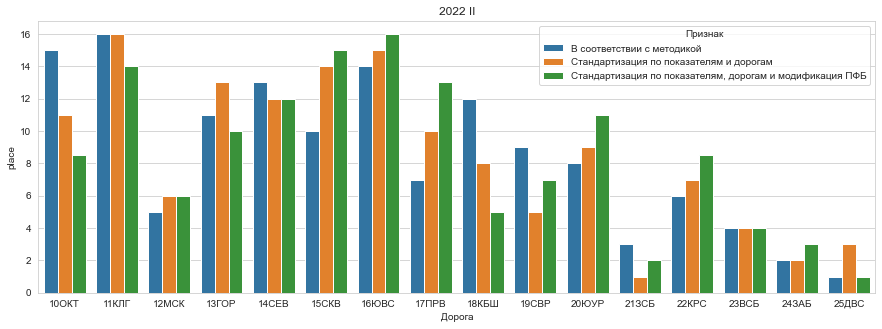

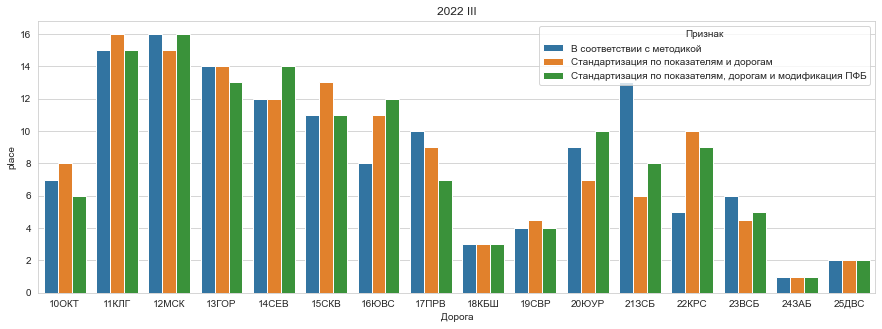

In [82]:
for i in xyz['Период'].unique():
    plt.figure(figsize=(15,5))
    sns.barplot(data=xyz[xyz['Период']==i], x='Дорога', y='place', hue='Признак')
    plt.title(i)


In [87]:
full = df_r_full.loc[:,(['Дорога','Период','rating'],['','',''])]
full['Признак']='Стандартизация по показателям и модификация ПФБ'

In [88]:
xyzz=pd.concat([x,y,z,full,full_stand], axis=0)

In [89]:
xyzz['place']=xyzz.groupby([('Период',''),('Признак','')], as_index=False)['rating'].rank(ascending=True)
xyzz['mean_rank'] = xyzz.groupby(['Дорога', 'Признак'])['place'].transform('mean')

In [273]:
#xyz['place'] = xyz.groupby([('Период',''),('Признак','')], as_index=False)['rating'].rank(ascending=True)
xyz['mean_rank'] = xyz.groupby(['Дорога', 'Признак'])['place'].transform('mean')

In [276]:
xyz[xyz['Дорога']=='13ГОР']

Дорога    Период     rating  \
                                  
83   13ГОР  2021 III   6.875000   
195  13ГОР   2021 IV   7.075000   
291  13ГОР    2022 I   4.600000   
387  13ГОР   2022 II   8.925000   
499  13ГОР  2022 III   8.175000   
15   13ГОР  2021 III  11.006250   
16   13ГОР   2021 IV   5.668750   
17   13ГОР    2022 I  -2.550000   
18   13ГОР   2022 II  11.282813   
19   13ГОР  2022 III   0.525000   

                                             Признак place mean_rank  
                                                                      
83                        В соответствии с методикой   7.0       8.8  
195                       В соответствии с методикой   9.0       8.8  
291                       В соответствии с методикой   3.0       8.8  
387                       В соответствии с методикой  11.0       8.8  
499                       В соответствии с методикой  14.0       8.8  
15   Стандартизация по показателям и модификация ПФБ  15.0      12.6  
16   Стандартизация по показателям и модификация ПФБ  15.0      12.6  
17   Стандартизация по показателям и модификация ПФБ   3.0      12.6  
18   Стандартизация по показателям и модификация ПФБ  15.0      12.6  
19   Стандартизация по показателям и модификация ПФБ  15.0      12.6

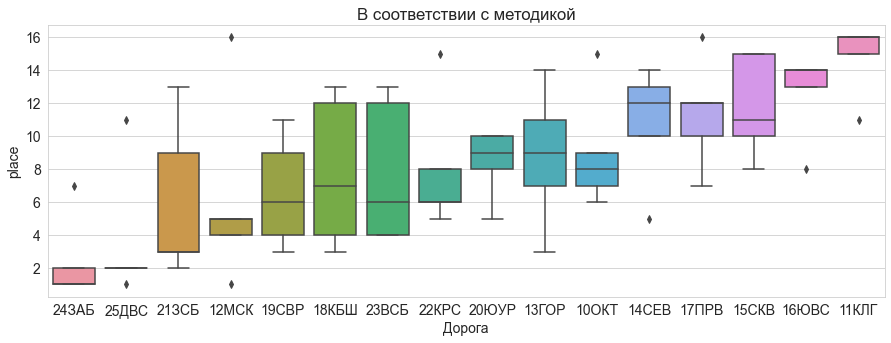

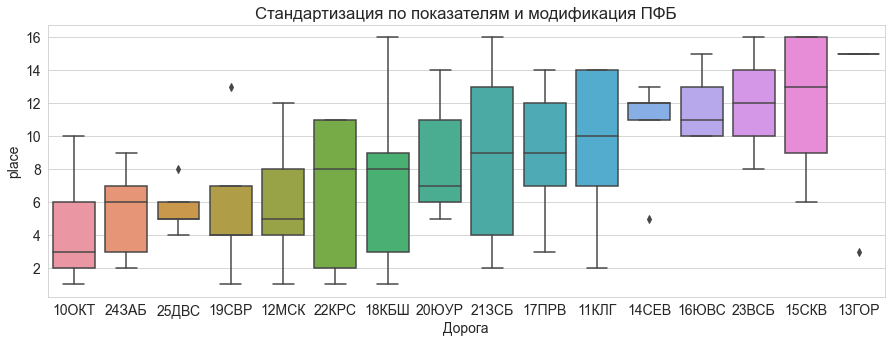

In [275]:
for i in xyz['Признак'].unique():
    plt.figure(figsize=(15,5))
    sns.boxplot(data=xyz[xyz['Признак']==i].sort_values('mean_rank'), x='Дорога', y='place')
    plt.title(i)
